In [531]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager
from copy import copy
import pandas as pd
import datetime

In [592]:
%matplotlib inline

label_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=20
)
tick_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=14
)
pub_font = font_manager.FontProperties(
#     family=['cmr10'],
    weight='regular',
    size=32
)
pub_font2 = font_manager.FontProperties(
#     family=['cmr10'],
    weight='regular',
    size=42
)
publish = True
if publish:
    matplotlib.rcParams.update(
        {
            'text.usetex': True,
            'font.family': 'cmr10',
            'mathtext.fontset': 'cm',
        }
    )

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [3]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+R+G+H),
        b*S*I/(S+E+I+R+G+H)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        e*I,
        m*I,
        g*E,
        e*I
    ]

In [4]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [5]:
the_dates = list(map(lambda t: datetime.datetime.strptime(t, "%d/%m/%Y"), raw_data.Date.values))
def time_conv(time: float):
    return the_dates[0] + datetime.timedelta(days=time)

In [554]:
date_tick = [datetime.date(2019, M, 1) for M in [10, 11, 12]] + [datetime.date(2020, 1, 1)]
date_tick_label = ['Oct\n2019', 'Nov', 'Dec', 'Jan\n2020']

ex_date_tick = date_tick + [datetime.date(2020,2,1)]
ex_date_label = date_tick_label + ['Feb']

In [6]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

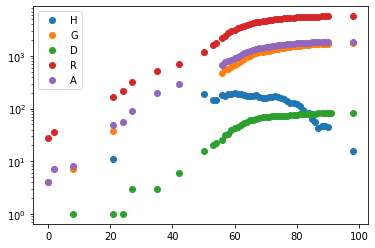

In [7]:
plt.semilogy(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

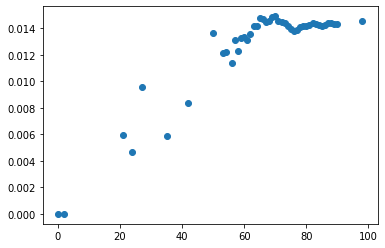

In [8]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [9]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
clip = 17
data_time = time[start:clip]
data_pd = data_pd[start:clip,:]

p0 = [2, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.25],
#     "time_span": [time[0], 150],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [10]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 50,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [11]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
fr_ex = ca.Function('fr_ex', [solver_setup['x']], [objective.regularisation])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [12]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 3e1

In [13]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

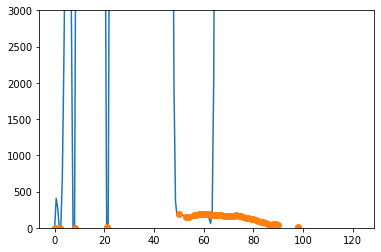

In [14]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [15]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

1700  3.8180856e+01 0.00e+00 3.52e-04  -9.0 5.07e+02    -  1.00e+00 1.00e+00h  1
1750  3.8180856e+01 0.00e+00 1.21e-04  -9.0 3.12e+02    -  1.00e+00 1.00e+00h  1
1800  3.8180856e+01 0.00e+00 2.16e-03  -9.0 5.29e+03    -  1.00e+00 2.50e-01h  3
1850  3.8180855e+01 0.00e+00 1.78e-03  -9.0 2.01e+04    -  1.00e+00 6.25e-02h  5
1900  3.8180855e+01 0.00e+00 7.60e-06  -9.0 9.69e+01    -  1.00e+00 1.00e+00h  1
1950  3.8180855e+01 0.00e+00 1.33e-03  -9.0 1.17e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  3.8180855e+01 0.00e+00 1.65e-03  -9.0 5.20e+03    -  1.00e+00 2.50e-01h  3
2050  3.8180855e+01 0.00e+00 3.68e-03  -9.0 4.07e+03    -  1.00e+00 5.00e-01h  2
2100  3.8180855e+01 0.00e+00 3.15e-03  -9.0 3.85e+03    -  1.00e+00 5.00e-01h  2
2150  3.8180855e+01 0.00e+00 1.61e-03  -9.0 1.13e+04    -  1.00e+00 1.25e-01h  4
2200  3.8180855e+01 0.00e+00 2.69e-04  -9.0 6.02e+02    -  1.00e+00 1.00e+00h  1
2250  3.8180855e+01 0.00e+00

 150  3.8386674e+01 0.00e+00 2.97e-01  -5.7 1.76e+03    -  1.00e+00 1.00e+00f  1
 200  3.8346520e+01 0.00e+00 7.10e-02  -5.7 1.32e+01    -  1.00e+00 1.00e+00f  1
 250  3.8343282e+01 0.00e+00 2.95e-02  -5.7 5.38e+00    -  1.00e+00 1.00e+00h  1
 300  3.8342407e+01 0.00e+00 3.24e-02  -5.7 2.04e+02    -  1.00e+00 3.12e-02h  6
 350  3.8342118e+01 0.00e+00 8.80e-04  -5.7 1.92e+00    -  1.00e+00 1.00e+00h  1
 400  3.8341579e+01 0.00e+00 1.71e-01  -8.6 4.45e+01    -  1.00e+00 1.00e+00h  1
 450  3.8341800e+01 0.00e+00 8.33e-01  -8.6 3.36e+02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.8341432e+01 0.00e+00 2.60e-02  -8.6 7.22e+02    -  1.00e+00 6.25e-02h  5
 550  3.8341408e+01 0.00e+00 3.08e-02  -8.6 2.70e+02    -  1.00e+00 2.50e-01h  3
 600  3.8341391e+01 0.00e+00 7.89e-05  -8.6 7.26e+00    -  1.00e+00 1.00e+00h  1
 650  3.8341377e+01 0.00e+00 1.74e-02  -8.6 8.71e+02    -  1.00e+00 1.25e-01h  4
 700  3.8341367e+01 0.00e+00

 650  3.8445523e+01 0.00e+00 5.00e-03  -8.6 2.51e+01    -  1.00e+00 1.00e+00h  1
 700  3.8445504e+01 0.00e+00 3.17e-02  -8.6 1.63e+02    -  1.00e+00 5.00e-01h  2
 750  3.8445491e+01 0.00e+00 2.36e-03  -8.6 3.08e+01    -  1.00e+00 1.00e+00h  1
 800  3.8445491e+01 0.00e+00 1.49e-01  -8.6 6.11e+02    -  1.00e+00 5.00e-01h  2
 850  3.8445476e+01 0.00e+00 1.55e-03  -8.6 4.05e+01    -  1.00e+00 1.00e+00h  1
 900  3.8445471e+01 0.00e+00 5.08e-03  -8.6 2.82e+03    -  1.00e+00 3.12e-02h  6
 950  3.8445467e+01 0.00e+00 4.18e-04  -8.6 3.24e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.8445464e+01 0.00e+00 2.38e-03  -8.6 9.06e+01    -  1.00e+00 1.00e+00h  1
1050  3.8445462e+01 0.00e+00 2.64e-03  -8.6 1.14e+02    -  1.00e+00 1.00e+00h  1
1100  3.8445459e+01 0.00e+00 5.75e-03  -8.6 2.23e+02    -  1.00e+00 1.00e+00h  1
1150  3.8445458e+01 0.00e+00 2.90e-03  -8.6 1.35e+03    -  1.00e+00 1.25e-01h  4
1200  3.8445457e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.8567588e+01 0.00e+00 4.62e-02  -9.0 1.95e+04    -  1.00e+00 1.56e-02h  7
In iteration 1036, 1 Slack too small, adjusting variable bound
In iteration 1040, 1 Slack too small, adjusting variable bound
1050  3.8567585e+01 0.00e+00 3.88e-03  -9.0 2.86e+02    -  1.00e+00 1.00e+00h  1
1100  3.8567584e+01 0.00e+00 4.24e-02  -9.0 1.79e+04    -  1.00e+00 1.56e-02h  7
1150  3.8567583e+01 0.00e+00 5.53e-03  -9.0 1.73e+03    -  1.00e+00 2.50e-01h  3
1200  3.8567583e+01 0.00e+00 5.12e-04  -9.0 1.53e+02    -  1.00e+00 1.00e+00h  1
1250  3.8567582e+01 0.00e+00 1.48e-02  -9.0 1.82e+03    -  1.00e+00 5.00e-01h  2
1300  3.8567582e+01 0.00e+00 3.21e-03  -9.0 4.74e+02    -  1.00e+00 1.00e+00h  1
1350  3.8567582e+01 0.00e+00 2.59e-03  -9.0 4.47e+02    -  1.00e+00 1.00e+00h  1
1400  3.8567582e+01 0.00e+00 2.00e-02  -9.0 8.86e+03    -  1.00e+00 6.25e-02h  5
1450  3.8567581e+01 0.00e+00 9.83e-05  -9.0 5.60e+01    -  1.00e

1200  3.8708393e+01 0.00e+00 8.19e-03  -8.6 1.43e+02    -  1.00e+00 1.00e+00h  1
1250  3.8708391e+01 0.00e+00 1.41e-02  -8.6 8.54e+02    -  1.00e+00 2.50e-01h  3
1300  3.8708389e+01 0.00e+00 1.17e-02  -8.6 2.33e+02    -  1.00e+00 1.00e+00h  1
1350  3.8708387e+01 0.00e+00 5.69e-03  -8.6 1.40e+03    -  1.00e+00 1.25e-01h  4
1400  3.8708386e+01 0.00e+00 1.40e-03  -8.6 1.05e+02    -  1.00e+00 1.00e+00h  1
1450  3.8708385e+01 0.00e+00 2.63e-03  -8.6 1.63e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.8708384e+01 0.00e+00 2.77e-02  -8.6 1.19e+03    -  1.00e+00 5.00e-01h  2
1550  3.8708383e+01 0.00e+00 1.47e-02  -8.6 4.90e+02    -  1.00e+00 1.00e+00H  1
1600  3.8708383e+01 0.00e+00 4.17e-03  -8.6 2.91e+02    -  1.00e+00 1.00e+00h  1
In iteration 1645, 1 Slack too small, adjusting variable bound
In iteration 1649, 1 Slack too small, adjusting variable bound
1650  3.8964962e+01 0.00e+00 3.48e+01  -9.0 3.40e+03 -10.7 3.19e

1350  3.8867700e+01 0.00e+00 1.80e-03  -8.6 7.70e+01    -  1.00e+00 1.00e+00h  1
1400  3.8867698e+01 0.00e+00 1.44e-03  -8.6 7.90e+01    -  1.00e+00 1.00e+00h  1
1450  3.8867697e+01 0.00e+00 4.13e-04  -8.6 4.89e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.8867696e+01 0.00e+00 5.31e-03  -8.6 1.94e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1536

                                   (scaled)                 (unscaled)
Objective...............:   3.8867695005020082e+01    3.8867695005020082e+01
Dual infeasibility......:   2.2525292213640528e-10    2.2525292213640528e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035681054596e-09    2.5059035681054596e-09
Overall NLP error.......:   2.5059035681054596e-09    2.5059035681054596e-09


Number of objective function evaluations             = 2975
Number of objective gradient evaluations    

 100  4.1086863e+01 0.00e+00 4.93e+01  -2.5 3.36e+03 -11.3 6.74e-01 1.00e+00f  1
 150  4.0286530e+01 0.00e+00 2.93e+00  -5.7 6.63e+04 -12.6 1.24e-01 4.67e-02f  4
 200  3.9619401e+01 0.00e+00 3.70e+00  -5.7 2.81e+03 -12.0 1.00e+00 1.00e+00f  1
 250  3.9264611e+01 0.00e+00 2.50e+00  -5.7 5.59e+01    -  1.00e+00 1.00e+00f  1
 300  3.9251627e+01 0.00e+00 7.50e-01  -5.7 4.49e+01    -  1.00e+00 2.50e-01f  3
 350  3.9248314e+01 0.00e+00 7.52e-02  -5.7 2.10e+00    -  1.00e+00 1.00e+00h  1
 400  3.9246991e+01 0.00e+00 2.31e-01  -5.7 4.89e+01    -  1.00e+00 1.25e-01h  4
 450  3.9246372e+01 0.00e+00 2.52e-02  -5.7 3.36e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9246050e+01 0.00e+00 8.64e-02  -5.7 8.76e+00    -  1.00e+00 1.00e+00h  1
 550  3.9245861e+01 0.00e+00 2.35e-02  -5.7 6.18e+00    -  1.00e+00 1.00e+00h  1
 600  3.9247976e+01 0.00e+00 4.55e+00  -8.6 2.41e+02    -  1.00e+00 5.00e-01h  2
 650  3.9245239e+01 0.00e+00

 200  3.9501660e+01 0.00e+00 2.00e+00  -5.7 6.68e+01    -  1.00e+00 1.00e+00f  1
 250  3.9476986e+01 0.00e+00 8.57e-01  -5.7 1.54e+01    -  1.00e+00 1.00e+00f  1
 300  3.9471722e+01 0.00e+00 8.61e-02  -5.7 2.11e+00    -  1.00e+00 1.00e+00f  1
 350  3.9469817e+01 0.00e+00 7.70e-02  -5.7 2.44e+00    -  1.00e+00 1.00e+00h  1
 400  3.9468915e+01 0.00e+00 4.94e-01  -5.7 1.93e+01    -  1.00e+00 5.00e-01h  2
 450  3.9468458e+01 0.00e+00 3.66e-03  -5.7 1.37e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9505730e+01 0.00e+00 1.97e+01  -5.7 2.51e+02 -11.6 8.96e-01 1.42e-14h 47
 550  3.9468004e+01 0.00e+00 2.32e-02  -5.7 5.96e+00    -  1.00e+00 1.00e+00h  1
 600  3.9467592e+01 0.00e+00 1.60e-01  -8.6 1.55e+02    -  1.00e+00 1.25e-01h  4
 650  3.9467485e+01 0.00e+00 1.09e-01  -8.6 2.25e+01    -  1.00e+00 1.00e+00h  1
 700  3.9467423e+01 0.00e+00 2.34e-02  -8.6 1.34e+01    -  1.00e+00 1.00e+00h  1
 750  3.9467372e+01 0.00e+00

1750  3.9741565e+01 0.00e+00 1.89e-02  -8.6 1.27e+02    -  1.00e+00 1.00e+00h  1
1800  3.9741563e+01 0.00e+00 1.94e-03  -8.6 4.52e+01    -  1.00e+00 1.00e+00h  1
1850  3.9741562e+01 0.00e+00 2.05e-02  -8.6 3.09e+02    -  1.00e+00 5.00e-01h  2
1900  3.9741561e+01 0.00e+00 4.09e-03  -8.6 7.88e+01    -  1.00e+00 1.00e+00h  1
1950  3.9741559e+01 0.00e+00 4.56e-04  -8.6 2.95e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 1957

                                   (scaled)                 (unscaled)
Objective...............:   3.9741559139500716e+01    3.9741559139500716e+01
Dual infeasibility......:   7.9247703345924527e-10    7.9247703345924527e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035599871989e-09    2.5059035599871989e-09
Overall NLP error.......:   2.5059035599871989e-09    2.5059035599871989e-09


Number of objective fun

  50  4.2468156e+01 0.00e+00 8.72e+01  -2.5 7.05e+02 -10.6 1.00e+00 1.00e+00f  1
 100  4.2595087e+01 0.00e+00 4.24e+01  -2.5 2.18e+04    -  4.77e-01 1.54e-01f  3
 150  4.2707871e+01 0.00e+00 5.17e+00  -3.8 1.05e+04    -  7.51e-01 7.98e-01f  1
 200  4.2132065e+01 0.00e+00 6.32e+00  -5.7 1.47e+04 -11.2 2.55e-01 5.73e-02f  4
 250  4.1224754e+01 0.00e+00 1.53e+01  -5.7 8.30e+03    -  3.35e-01 5.09e-01f  1
 300  4.0553481e+01 0.00e+00 4.51e+00  -5.7 9.27e+01    -  1.00e+00 5.00e-01f  2
 350  4.0538237e+01 0.00e+00 9.09e-01  -5.7 2.01e+01    -  1.00e+00 1.00e+00f  1
 400  4.0533849e+01 0.00e+00 3.47e-01  -5.7 3.88e+00    -  1.00e+00 1.00e+00h  1
 450  4.0532096e+01 0.00e+00 3.60e-01  -5.7 5.20e+00    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.0531183e+01 0.00e+00 8.04e-02  -5.7 2.19e+00    -  1.00e+00 1.00e+00h  1
 550  4.0530673e+01 0.00e+00 4.08e-01  -5.7 1.32e+01    -  1.00e+00 5.00e-01h  2
 600  4.0530368e+01 0.00e+00

 300  4.2625863e+01 0.00e+00 8.59e+00  -5.7 6.62e+02 -10.3 1.00e+00 3.38e-01f  1
 350  4.1706822e+01 0.00e+00 5.23e+00  -5.7 5.76e+02    -  1.00e+00 5.00e-01f  2
 400  4.1057483e+01 0.00e+00 1.27e+00  -5.7 1.82e+01    -  1.00e+00 1.00e+00f  1
 450  4.1044630e+01 0.00e+00 2.07e+00  -5.7 1.31e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1040632e+01 0.00e+00 6.56e-01  -5.7 7.82e+00    -  1.00e+00 5.00e-01h  2
 550  4.1038946e+01 0.00e+00 5.76e-01  -5.7 5.15e+01    -  1.00e+00 6.25e-02f  5
 600  4.1038053e+01 0.00e+00 2.08e-01  -5.7 2.89e+00    -  1.00e+00 1.00e+00h  1
 650  4.1037595e+01 0.00e+00 6.76e-02  -5.7 2.22e+00    -  1.00e+00 1.00e+00h  1
 700  4.1037302e+01 0.00e+00 2.51e-01  -5.7 4.30e+01    -  1.00e+00 1.25e-01h  4
 750  4.1037080e+01 0.00e+00 1.27e-01  -5.7 8.07e+01    -  1.00e+00 6.25e-02h  5
 800  4.1036958e+01 0.00e+00 6.83e-02  -5.7 7.08e+01    -  1.00e+00 6.25e-02h  5
 850  4.1036870e+01 0.00e+00

 450  4.1627930e+01 0.00e+00 3.55e-01  -5.7 1.62e+01    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1627121e+01 0.00e+00 9.68e-01  -5.7 3.83e+01    -  1.00e+00 1.25e-01h  4
 550  4.1626857e+01 0.00e+00 3.05e+00  -5.7 2.26e+01    -  1.00e+00 5.00e-01h  2
 600  4.1626351e+01 0.00e+00 4.45e-02  -5.7 1.80e+00    -  1.00e+00 1.00e+00h  1
 650  4.1626168e+01 0.00e+00 2.20e-02  -5.7 1.57e+00    -  1.00e+00 1.00e+00h  1
 700  4.1626043e+01 0.00e+00 1.19e-02  -5.7 1.39e+00    -  1.00e+00 1.00e+00h  1
 750  4.1625964e+01 0.00e+00 5.55e-01  -5.7 2.16e+01    -  1.00e+00 5.00e-01h  2
 800  4.1625897e+01 0.00e+00 7.59e-03  -5.7 1.46e+00    -  1.00e+00 1.00e+00h  1
 850  4.1625853e+01 0.00e+00 5.56e-04  -5.7 4.56e-01    -  1.00e+00 1.00e+00h  1
 900  4.1625827e+01 0.00e+00 4.88e-04  -5.7 4.43e-01    -  1.00e+00 1.00e+00h  1
 950  4.1625300e+01 0.00e+00 9.58e-02  -8.6 8.61e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 900  4.2970467e+01 0.00e+00 1.38e-01  -5.7 3.19e+01    -  1.00e+00 5.00e-01h  2
 950  4.2970411e+01 0.00e+00 4.60e-02  -5.7 1.08e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.2970372e+01 0.00e+00 1.08e-01  -5.7 3.61e+01    -  1.00e+00 5.00e-01h  2
1050  4.2970349e+01 0.00e+00 6.77e-05  -5.7 4.95e-01    -  1.00e+00 1.00e+00h  1
1100  4.2969942e+01 0.00e+00 1.17e-01  -8.6 2.67e+01    -  1.00e+00 1.00e+00h  1
1150  4.2969899e+01 0.00e+00 3.31e-03  -8.6 5.58e+00    -  1.00e+00 1.00e+00h  1
1200  4.2969863e+01 0.00e+00 1.05e-02  -8.6 1.13e+01    -  1.00e+00 1.00e+00h  1
1250  4.2969833e+01 0.00e+00 1.60e-01  -8.6 4.04e+02    -  1.00e+00 1.25e-01h  4
1300  4.2969810e+01 0.00e+00 6.22e-02  -8.6 3.73e+01    -  1.00e+00 1.00e+00h  1
1350  4.2969791e+01 0.00e+00 2.54e-01  -8.6 1.72e+02    -  1.00e+00 5.00e-01h  2
1400  4.2969774e+01 0.00e+00 1.07e-02  -8.6 2.06e+01    -  1.00e+00 1.00e+00h  1
1450  4.2969761e+01 0.00e+00

1050  4.3812532e+01 0.00e+00 5.96e-02  -5.7 6.44e+00  -7.6 1.00e+00 1.00e+00h  1
1100  4.3812405e+01 0.00e+00 2.53e-01  -5.7 3.04e+01    -  1.00e+00 5.00e-01h  2
1150  4.3812312e+01 0.00e+00 1.21e-02  -5.7 4.09e+00    -  1.00e+00 1.00e+00h  1
1200  4.3812244e+01 0.00e+00 5.41e-03  -5.7 3.14e+00    -  1.00e+00 1.00e+00h  1
1250  4.3812189e+01 0.00e+00 6.97e-03  -5.7 3.97e+00    -  1.00e+00 1.00e+00h  1
1300  4.3812150e+01 0.00e+00 5.87e-02  -5.7 2.40e+01    -  1.00e+00 5.00e-01h  2
1350  4.3811816e+01 0.00e+00 2.42e-01  -8.6 2.80e+01    -  1.00e+00 1.00e+00f  1
1400  4.3811756e+01 0.00e+00 1.07e-02  -8.6 7.19e+00    -  1.00e+00 1.00e+00h  1
1450  4.3811712e+01 0.00e+00 1.57e-01  -8.6 3.17e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.3811675e+01 0.00e+00 2.07e-01  -8.6 3.34e+02    -  1.00e+00 1.25e-01h  4
1550  4.3811644e+01 0.00e+00 1.42e-01  -8.6 3.18e+02    -  1.00e+00 1.25e-01h  4
1600  4.3811619e+01 0.00e+00

1450  4.4754666e+01 0.00e+00 1.56e-02  -5.7 5.93e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.4754641e+01 0.00e+00 4.52e-02  -5.7 1.08e+01    -  1.00e+00 1.00e+00h  1
1550  4.4754300e+01 0.00e+00 3.06e-02  -8.6 1.03e+01    -  1.00e+00 1.00e+00h  1
1600  4.4754227e+01 0.00e+00 2.12e-01  -8.6 6.58e+01    -  1.00e+00 5.00e-01h  2
1650  4.4754184e+01 0.00e+00 4.13e-02  -8.6 1.87e+01    -  1.00e+00 1.00e+00h  1
1700  4.4754159e+01 0.00e+00 1.52e-01  -8.6 4.08e+01    -  1.00e+00 1.00e+00h  1
1750  4.4754135e+01 0.00e+00 1.91e-01  -8.6 5.23e+01    -  1.00e+00 1.00e+00h  1
1800  4.4754117e+01 0.00e+00 1.72e-02  -8.6 1.79e+01    -  1.00e+00 1.00e+00h  1
1850  4.4754101e+01 0.00e+00 7.39e-02  -8.6 4.16e+01    -  1.00e+00 1.00e+00h  1
1900  4.4754088e+01 0.00e+00 1.61e-02  -8.6 2.18e+01    -  1.00e+00 1.00e+00h  1
1950  4.4754076e+01 0.00e+00 1.33e-01  -8.6 2.69e+02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr 

 150  4.8108956e+01 0.00e+00 4.27e-01  -5.7 2.37e+02 -12.1 1.00e+00 1.00e+00f  1
 200  4.8104364e+01 0.00e+00 4.60e+00  -5.7 2.33e+03 -13.4 1.00e+00 2.50e-01f  3
 250  4.8096621e+01 0.00e+00 1.95e+00  -5.7 1.05e+02  -9.7 1.00e+00 1.00e+00f  1
 300  4.8083651e+01 0.00e+00 9.13e+00  -5.7 1.97e+03 -11.9 1.00e+00 2.79e-01f  2
 350  4.8074955e+01 0.00e+00 3.46e-02  -5.7 2.99e+01  -9.0 1.00e+00 1.00e+00h  1
 400  4.8069812e+01 0.00e+00 7.86e-02  -5.7 1.99e+03    -  1.00e+00 1.00e+00h  1
 450  4.8069386e+01 0.00e+00 6.58e-03  -8.6 3.94e+02 -12.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 459

                                   (scaled)                 (unscaled)
Objective...............:   4.8069344276476272e+01    4.8069344276476272e+01
Dual infeasibility......:   9.8438004148625045e-10    9.8438004148625045e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

 250  5.2694954e+01 0.00e+00 1.22e+01  -5.7 1.63e+03 -11.9 1.00e+00 2.50e-01f  3
 300  5.2637819e+01 0.00e+00 2.04e+01  -5.7 6.59e+02 -11.7 1.00e+00 1.00e+00f  1
 350  5.2611500e+01 0.00e+00 2.28e+00  -5.7 4.69e+02 -11.2 1.00e+00 1.00e+00f  1
 400  5.2601659e+01 0.00e+00 4.10e-02  -8.6 1.06e+01  -9.4 2.12e-01 1.00e+00f  1

Number of Iterations....: 415

                                   (scaled)                 (unscaled)
Objective...............:   5.2601547775247660e+01    5.2601547775247660e+01
Dual infeasibility......:   1.5548664967351993e-09    1.5548664967351993e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5171225205678464e-09    2.5171225205678464e-09
Overall NLP error.......:   2.5171225205678464e-09    2.5171225205678464e-09


Number of objective function evaluations             = 739
Number of objective gradient evaluations             = 416
Number of equality constraint evaluations            = 0
Number of i

 300  5.9627411e+01 0.00e+00 4.12e-01  -3.8 8.84e+01 -11.4 1.00e+00 1.00e+00f  1
 350  5.9611653e+01 0.00e+00 4.67e+00  -3.8 8.25e+02    -  1.00e+00 5.00e-01f  2
 400  5.9584052e+01 0.00e+00 9.43e+00  -3.8 5.87e+02    -  1.00e+00 5.00e-01f  2
 450  5.9535803e+01 0.00e+00 1.56e+01  -3.8 3.75e+02 -12.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.9479645e+01 0.00e+00 1.52e+01  -3.8 2.90e+02 -12.0 1.00e+00 1.00e+00f  1
 550  5.9427787e+01 0.00e+00 1.32e+01  -3.8 1.47e+04    -  6.75e-01 6.25e-02f  5
 600  5.9377133e+01 0.00e+00 1.61e+00  -5.7 1.22e+02 -10.0 1.00e+00 1.00e+00f  1
 650  5.9368186e+01 0.00e+00 8.83e-02  -5.7 3.33e+03    -  7.89e-01 2.50e-01h  3

Number of Iterations....: 678

                                   (scaled)                 (unscaled)
Objective...............:   5.9367875715593911e+01    5.9367875715593911e+01
Dual infeasibility......:   4.7535309022350702e-12    4.7535309022350702e-12
Constraint vio

 650  6.6477967e+01 0.00e+00 6.78e-01  -8.6 1.25e+03 -13.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 665

                                   (scaled)                 (unscaled)
Objective...............:   6.6477924585714362e+01    6.6477924585714362e+01
Dual infeasibility......:   6.1176166354925954e-09    6.1176166354925954e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059783136270656e-09    2.5059783136270656e-09
Overall NLP error.......:   6.1176166354925954e-09    6.1176166354925954e-09


Number of objective function evaluations             = 1243
Number of objective gradient evaluations             = 666
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1243
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 666
Number of Lagrangian Hessian evaluations             = 665
Total CPU secs in 

 150  8.1309821e+01 0.00e+00 9.03e+01  -3.8 4.56e+02 -11.0 1.00e+00 1.00e+00f  1
 200  8.1285199e+01 0.00e+00 8.99e+00  -3.8 4.57e+02 -11.2 1.00e+00 1.00e+00f  1
 250  8.1251143e+01 0.00e+00 4.16e+00  -3.8 1.88e+02 -11.0 1.00e+00 1.00e+00f  1
 300  8.1198652e+01 0.00e+00 5.31e+01  -3.8 7.78e+02 -11.8 1.00e+00 5.00e-01f  2
 350  8.1123841e+01 0.00e+00 3.34e+01  -3.8 2.69e+02 -11.3 1.00e+00 1.00e+00f  1
 400  8.1053496e+01 0.00e+00 1.70e+01  -3.8 4.39e+02 -11.7 1.00e+00 1.00e+00f  1
 450  8.1012345e+01 0.00e+00 1.50e+01  -3.8 1.53e+02 -11.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.0966127e+01 0.00e+00 5.52e+00  -5.7 1.53e+02 -11.1 1.00e+00 1.00e+00f  1
 550  8.0963619e+01 0.00e+00 1.58e-05  -8.6 1.96e-01    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 558

                                   (scaled)                 (unscaled)
Objective...............:   8.0963618638154585e+01    8.0963618638154585e+01
Dual infea

 500  9.1959139e+01 0.00e+00 1.62e+01  -3.8 1.50e+04    -  1.00e+00 1.25e-01f  4
 550  9.1930092e+01 0.00e+00 8.29e+01  -5.7 5.03e+03    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 576

                                   (scaled)                 (unscaled)
Objective...............:   9.1929593477631627e+01    9.1929593477631627e+01
Dual infeasibility......:   2.3837811505809676e-11    2.3837811505809676e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035613624466e-09    2.5059035613624466e-09
Overall NLP error.......:   2.5059035613624466e-09    2.5059035613624466e-09


Number of objective function evaluations             = 1050
Number of objective gradient evaluations             = 577
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1050
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

 150  1.1142996e+02 0.00e+00 1.20e+01  -2.5 8.17e+01    -  1.00e+00 1.00e+00h  1
 200  1.1105299e+02 0.00e+00 1.16e+02  -3.8 4.24e+02  -9.7 1.00e+00 1.00e+00f  1
 250  1.1099611e+02 0.00e+00 3.19e+01  -3.8 1.84e+02 -10.5 1.00e+00 1.00e+00f  1
 300  1.1097631e+02 0.00e+00 1.78e+00  -3.8 2.84e+01  -9.5 1.00e+00 1.00e+00f  1
 350  1.1095752e+02 0.00e+00 9.07e+00  -3.8 1.70e+02 -10.3 1.00e+00 5.00e-01f  2
 400  1.1093239e+02 0.00e+00 1.38e+01  -3.8 8.46e+02 -11.1 1.00e+00 1.00e+00f  1
 450  1.1090091e+02 0.00e+00 1.14e+01  -3.8 1.18e+03 -10.5 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1085019e+02 0.00e+00 1.14e+01  -3.8 2.58e+02 -10.0 1.00e+00 1.00e+00f  1
 550  1.1077144e+02 0.00e+00 2.94e+00  -3.8 1.67e+02  -9.5 1.00e+00 1.00e+00f  1
 600  1.1056044e+02 0.00e+00 4.23e+01  -3.8 5.81e+02  -9.9 1.00e+00 5.00e-01f  2
 650  1.1005553e+02 0.00e+00 1.57e+02  -3.8 1.01e+02  -8.4 1.00e+00 1.00e+00f  1
 700  1.0987964e+02 0.00e+00

 200  1.2594238e+02 0.00e+00 3.82e+01  -3.8 9.85e+01  -8.8 1.00e+00 1.00e+00f  1
 250  1.2570533e+02 0.00e+00 1.35e+02  -3.8 2.17e+03  -9.1 1.00e+00 1.25e-01f  4
 300  1.2546237e+02 0.00e+00 8.69e+01  -3.8 1.19e+03  -8.6 1.00e+00 1.25e-01f  4
 350  1.2533938e+02 0.00e+00 5.22e+00  -3.8 1.71e+02  -9.4 1.00e+00 1.00e+00f  1
 400  1.2529552e+02 0.00e+00 1.54e+01  -3.8 1.10e+03 -10.7 1.00e+00 1.25e-01f  4
 450  1.2524750e+02 0.00e+00 9.87e-01  -3.8 4.91e+01  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.2516597e+02 0.00e+00 4.40e-03  -3.8 2.74e+00  -7.8 1.00e+00 1.00e+00f  1
 550  1.2497535e+02 0.00e+00 2.16e-01  -3.8 1.10e+02  -9.1 1.00e+00 1.00e+00f  1
 600  1.2465101e+02 0.00e+00 1.80e+00  -3.8 8.89e+01  -8.5 1.00e+00 1.00e+00f  1
 650  1.2390854e+02 0.00e+00 2.20e+01  -3.8 5.28e+02  -8.9 1.00e+00 5.00e-01f  2
 700  1.2306948e+02 0.00e+00 1.21e+01  -3.8 2.39e+03    -  1.00e+00 1.00e+00f  1
 750  1.2308471e+02 0.00e+00

 450  1.4306296e+02 0.00e+00 1.02e+01  -3.8 1.83e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.4293714e+02 0.00e+00 6.20e-01  -3.8 5.47e+01  -9.1 1.00e+00 1.00e+00f  1
 550  1.4279255e+02 0.00e+00 5.03e-01  -3.8 2.86e+01  -8.6 1.00e+00 1.00e+00f  1
 600  1.4252626e+02 0.00e+00 6.47e-02  -3.8 1.65e+01  -8.1 1.00e+00 1.00e+00f  1
 650  1.4201327e+02 0.00e+00 4.44e+00  -3.8 9.52e+01  -8.5 1.00e+00 1.00e+00f  1
 700  1.3998286e+02 0.00e+00 4.33e-01  -3.8 2.32e+01  -7.0 1.00e+00 1.00e+00f  1
 750  1.3889515e+02 0.00e+00 2.22e-07  -8.6 3.66e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 751

                                   (scaled)                 (unscaled)
Objective...............:   1.3889514901164674e+02    1.3889514901164674e+02
Dual infeasibility......:   8.2240037283083019e-10    8.2240037283083019e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

Complementarity.........:   2.5061448393278283e-09    2.5061448393278283e-09
Overall NLP error.......:   2.5061448393278283e-09    2.5061448393278283e-09


Number of objective function evaluations             = 1203
Number of objective gradient evaluations             = 661
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1203
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 661
Number of Lagrangian Hessian evaluations             = 660
Total CPU secs in IPOPT (w/o function evaluations)   =      5.266
Total CPU secs in NLP function evaluations           =      1.121

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  90.16ms ( 74.94us)  90.30ms ( 75.06us)      1203
       nlp_g  |  41.84ms ( 34.78us)  41.84ms ( 34.78us)      1203
    nlp_grad  | 193.00us (193.00us) 193.12us (193.12us)         1
  nlp_

  50  2.5019445e+02 0.00e+00 2.87e+03  -1.0 1.25e+04    -  4.00e-01 1.05e-01f  4
 100  2.4874350e+02 0.00e+00 1.80e+03  -1.0 3.51e+02  -7.8 1.00e+00 1.00e+00f  1
 150  2.5006077e+02 0.00e+00 1.61e+03  -1.0 5.23e+02    -  1.00e+00 5.00e-01f  2
 200  2.3866086e+02 0.00e+00 8.37e+02  -1.7 3.83e+02    -  1.00e+00 5.00e-01f  2
 250  2.3820267e+02 0.00e+00 2.53e+02  -1.7 8.80e+01  -8.6 1.00e+00 1.00e+00f  1
 300  2.3722355e+02 0.00e+00 1.23e+02  -1.7 5.25e+01  -8.3 1.00e+00 1.00e+00f  1
 350  2.3545262e+02 0.00e+00 1.02e+02  -1.7 3.96e+01  -7.7 1.00e+00 1.00e+00f  1
 400  2.3266579e+02 0.00e+00 2.73e+02  -1.7 4.91e+03    -  1.00e+00 1.25e-01f  4
 450  2.3059112e+02 0.00e+00 6.79e+01  -1.7 3.27e+01 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.2784148e+02 0.00e+00 8.75e+01  -2.5 9.48e+01  -7.9 1.00e+00 1.00e+00f  1
 550  2.2718590e+02 0.00e+00 1.15e+02  -2.5 9.31e+01  -7.6 1.00e+00 1.00e+00f  1
 600  2.2629397e+02 0.00e+00


Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:   2.4324145886150836e+02    2.4324145886150836e+02
Dual infeasibility......:   7.7456087771308645e-09    7.7456087771308645e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8270982183628199e-09    1.8270982183628199e-09
Overall NLP error.......:   7.7456087771308645e-09    7.7456087771308645e-09


Number of objective function evaluations             = 160
Number of objective gradient evaluations             = 81
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 160
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 81
Number of Lagrangian Hessian evaluations             = 80
Total CPU secs in IPOPT (w/o function evaluations)   =      0.498
Total CPU secs in NLP function evaluati

        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.2918957e+02 0.00e+00 1.40e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  4.2635725e+02 0.00e+00 1.80e+01  -3.8 7.12e+03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:   4.2633003554607512e+02    4.2633003554607512e+02
Dual infeasibility......:   4.1446710433654526e-11    4.1446710433654526e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8341454546336354e-09    2.8341454546336354e-09
Overall NLP error.......:   2.8341454546336354e-09    2.8341454546336354e-09


Number of objective function evaluations             = 133
Number of object

Number of inequality constraint evaluations          = 61
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 47
Number of Lagrangian Hessian evaluations             = 46
Total CPU secs in IPOPT (w/o function evaluations)   =      0.259
Total CPU secs in NLP function evaluations           =      0.076

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.76ms ( 78.05us)   4.71ms ( 77.17us)        61
       nlp_g  |   2.25ms ( 36.80us)   2.24ms ( 36.74us)        61
    nlp_grad  | 196.00us (196.00us) 196.07us (196.07us)         1
  nlp_grad_f  |   7.77ms (161.92us)   7.79ms (162.33us)        48
  nlp_hess_l  |  57.91ms (  1.26ms)  57.95ms (  1.26ms)        46
   nlp_jac_g  |   2.52ms ( 52.56us)   2.50ms ( 52.10us)        48
       total  | 337.01ms (337.01ms) 336.62ms (336.62ms)         1
Solving for p=6.135907273413176
This is Ipopt version 3.12.3, running with lin

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2324080e+03 0.00e+00 2.64e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   1.2166758861448313e+03    1.2166758861448313e+03
Dual infeasibility......:   2.0664204165983262e-10    2.0664204165983262e-10
Const

  50  1.8319179e+03 0.00e+00 8.89e-03  -5.7 3.35e+01    -  4.43e-01 1.00e+00f  1

Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:   1.8319177758776950e+03    1.8319177758776950e+03
Dual infeasibility......:   1.2572083573776590e-09    1.2572083573776590e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.5778384374338571e-09    4.5778384374338571e-09
Overall NLP error.......:   4.5778384374338571e-09    4.5778384374338571e-09


Number of objective function evaluations             = 93
Number of objective gradient evaluations             = 57
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 93
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 57
Number of Lagrangian Hessian evaluations             = 56
Total CPU secs in IPOPT (w


Number of Iterations....: 273

                                   (scaled)                 (unscaled)
Objective...............:   2.3058170272111324e+03    2.3058170272111324e+03
Dual infeasibility......:   1.2448919500617044e-10    1.2448919500617044e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   8.4115204247328695e-09    8.4115204247328695e-09
Overall NLP error.......:   8.4115204247328695e-09    8.4115204247328695e-09


Number of objective function evaluations             = 451
Number of objective gradient evaluations             = 274
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 451
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 274
Number of Lagrangian Hessian evaluations             = 273
Total CPU secs in IPOPT (w/o function evaluations)   =      1.290
Total CPU secs in NLP function eval


Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:   2.8964023242545304e+03    2.8964023242545304e+03
Dual infeasibility......:   3.7846076179785434e-10    3.7846076179785434e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   8.8426051522993396e-09    8.8426051522993396e-09
Overall NLP error.......:   8.8426051522993396e-09    8.8426051522993396e-09


Number of objective function evaluations             = 66
Number of objective gradient evaluations             = 57
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 66
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 57
Number of Lagrangian Hessian evaluations             = 56
Total CPU secs in IPOPT (w/o function evaluations)   =      0.346
Total CPU secs in NLP function evaluation


Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:   3.5175148808924523e+03    3.5175148808924523e+03
Dual infeasibility......:   2.2201140890760760e-09    2.2201140890760760e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5307561856693359e-09    2.5307561856693359e-09
Overall NLP error.......:   2.5307561856693359e-09    2.5307561856693359e-09


Number of objective function evaluations             = 85
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 85
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations             = 63
Total CPU secs in IPOPT (w/o function evaluations)   =      0.417
Total CPU secs in NLP function evaluation

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3296773e+03 0.00e+00 7.07e+01  -1.0 0.00e+00    -  0.00e+00 0.

        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0507623e+03 0.00e+00 7.65e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   5.0156106409263484e+03    5.0156106409263484e+03
Dual infeasibility......:   9.0311571810159440e-09    9.0311571810159440e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909339292e-10    9.0909090909339292e-10
Overall NLP error.......:   9.0311571810159440e-09    9.0311571810159440e-09


Number of objective function evaluations             = 67
Number of objective gradient evaluations             = 44
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 67
Number of equality constraint Jacobian evaluations   

  50  5.8948897e+03 0.00e+00 1.01e+04  -1.0 3.56e+03    -  7.28e-01 2.50e-01f  3
 100  5.8876675e+03 0.00e+00 5.37e-01  -1.7 2.45e-03  -1.3 1.00e+00 1.00e+00f  1
 150  5.8873419e+03 0.00e+00 4.93e+01  -2.5 8.74e+01    -  1.00e+00 2.50e-01f  3
 200  5.8872474e+03 0.00e+00 2.68e-02  -5.7 9.30e-03  -3.9 1.00e+00 1.00e+00h  1
 250  5.8871700e+03 0.00e+00 2.88e+01  -5.7 1.59e+01  -7.4 1.00e+00 1.00e+00f  1
 300  5.8870746e+03 0.00e+00 8.05e+00  -5.7 6.60e-01  -5.8 1.00e+00 1.00e+00f  1
 350  5.8869727e+03 0.00e+00 1.94e-02  -5.7 2.04e-03  -3.4 1.00e+00 1.00e+00h  1
 400  5.8868908e+03 0.00e+00 8.85e+00  -5.7 1.38e-02  -2.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 446

                                   (scaled)                 (unscaled)
Objective...............:   5.8868336004219063e+03    5.8868336004219063e+03
Dual infeasibility......:   3.0760743885441697e-08    3.0760743885441697e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

1300  6.0944852e+03 0.00e+00 4.11e+02  -5.7 3.04e+04    -  1.00e+00 3.91e-03f  9
1350  6.0944499e+03 0.00e+00 9.43e+02  -5.7 4.83e+04    -  9.80e-01 3.91e-03f  9
1400  6.0944141e+03 0.00e+00 4.09e+02  -5.7 3.40e+04    -  1.00e+00 3.91e-03f  9
1450  6.0943809e+03 0.00e+00 4.09e+02  -5.7 3.60e+04    -  1.00e+00 3.91e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  6.0943487e+03 0.00e+00 4.04e+02  -5.7 3.79e+04    -  1.00e+00 3.91e-03f  9
1550  6.0943191e+03 0.00e+00 3.18e+02  -5.7 3.99e+04    -  1.00e+00 3.48e-03f  9
1600  6.0942796e+03 0.00e+00 7.82e+02  -5.7 4.27e+04    -  1.00e+00 5.52e-03f  8
1650  6.0942443e+03 0.00e+00 4.57e+02  -5.7 4.57e+04    -  1.00e+00 4.24e-03f  8
1700  6.0942183e+03 0.00e+00 2.75e+02  -5.7 4.78e+04    -  1.00e+00 3.33e-03f  8
1750  6.0941836e+03 0.00e+00 4.33e+02  -5.7 5.10e+04    -  1.00e+00 4.25e-03f  7
1800  6.0941551e+03 0.00e+00 4.82e+02  -5.7 5.19e+04    -  1.00e+00 4.72e-03f  6
1850  6.0941314e+03 0.00e+00

 100  6.2180672e+03 0.00e+00 2.26e+04  -1.0 8.74e-01  -1.7 1.00e+00 2.50e-01f  3
 150  6.2167803e+03 0.00e+00 3.14e+03  -1.0 8.71e-01  -3.8 1.00e+00 1.00e+00f  1
 200  6.2159816e+03 0.00e+00 1.39e+03  -1.0 1.06e-01  -1.8 1.00e+00 1.00e+00f  1
 250  6.2151544e+03 0.00e+00 2.14e+01  -1.0 8.27e-02  -2.8 1.00e+00 1.00e+00f  1
 300  6.2123926e+03 0.00e+00 1.28e+04  -1.7 6.68e+03    -  9.81e-01 7.81e-03f  8
 350  6.2117037e+03 0.00e+00 5.67e+03  -2.5 4.14e+03    -  1.00e+00 7.81e-03f  8
 400  6.2113187e+03 0.00e+00 9.52e-03  -3.8 2.42e-03  -2.0 1.00e+00 1.00e+00f  1
 450  6.2110278e+03 0.00e+00 3.56e-01  -3.8 2.06e-02  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.2109001e+03 0.00e+00 5.02e+03  -3.8 1.15e+03    -  1.00e+00 1.53e-02f  7
 550  6.2108138e+03 0.00e+00 3.20e+03  -3.8 4.84e+02    -  1.00e+00 1.56e-02f  7
 600  6.2107657e+03 0.00e+00 3.93e+03  -3.8 2.60e+02    -  1.00e+00 3.12e-02f  6
 650  6.2107442e+03 0.00e+00

 350  6.2763911e+03 0.00e+00 1.48e+04  -2.5 1.27e+03    -  1.00e+00 1.56e-02f  7
 400  6.2759867e+03 0.00e+00 7.55e+03  -3.8 1.58e+04    -  1.00e+00 1.32e-02f  5
 450  6.2757791e+03 0.00e+00 4.62e+03  -3.8 1.41e+03    -  1.00e+00 1.79e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.2756882e+03 0.00e+00 3.74e+03  -5.7 1.25e+02    -  1.00e+00 3.12e-02f  6
 550  6.2756699e+03 0.00e+00 2.11e+03  -5.7 4.79e+01    -  1.00e+00 6.25e-02f  5
 600  6.2756672e+03 0.00e+00 6.63e-01  -5.7 3.94e-02    -  1.00e+00 1.00e+00h  1
 650  6.2756672e+03 0.00e+00 5.08e-06  -8.6 2.11e-08    -  1.00e+00 1.00e+00F  1
 700  6.2756672e+03 0.00e+00 8.44e-07  -8.6 1.11e-07    -  1.00e+00 1.00e+00F  1
 750  6.2756672e+03 0.00e+00 1.26e-06  -8.6 1.77e-07    -  1.00e+00 1.00e+00H  1
 800  6.2756672e+03 0.00e+00 3.03e-07  -8.6 3.80e-08    -  1.00e+00 1.00e+00H  1
 850  6.2756672e+03 0.00e+00 5.63e-06  -8.6 4.91e-09    -  1.00e+00 1.00e+00F  1
 900  6.2756672e+03 0.00e+00

2500  6.3543585e+03 0.00e+00 3.21e-07  -8.6 4.42e-08    -  1.00e+00 1.00e+00H  1
2550  6.3543585e+03 0.00e+00 4.48e-06  -8.6 6.66e-08    -  1.00e+00 1.00e+00H  1
2600  6.3543585e+03 0.00e+00 2.99e-06  -8.6 1.37e-07    -  1.00e+00 6.10e-05f 15
2650  6.3543585e+03 0.00e+00 5.20e-06  -8.6 1.42e-07    -  1.00e+00 3.91e-03f  9
2700  6.3543585e+03 0.00e+00 6.69e-06  -8.6 2.08e-07    -  1.00e+00 1.00e+00F  1
2750  6.3543585e+03 0.00e+00 4.03e-07  -8.6 6.13e-08    -  1.00e+00 1.00e+00H  1
2800  6.3543585e+03 0.00e+00 2.72e-06  -8.6 1.72e-07    -  1.00e+00 1.00e+00H  1
2850  6.3543585e+03 0.00e+00 2.54e-06  -8.6 2.07e-07    -  1.00e+00 1.00e+00H  1
2900  6.3543585e+03 0.00e+00 4.42e-06  -8.6 2.13e-07    -  1.00e+00 1.00e+00H  1
2950  6.3543585e+03 0.00e+00 4.84e-06  -8.6 2.06e-07    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.3543585e+03 0.00e+00 5.75e-06  -8.6 3.84e-08    -  1.00e+00 1.00e+00F  1

Number of Iterations....: 3

2700  6.4526859e+03 0.00e+00 6.36e-06  -8.6 2.89e-07    -  1.00e+00 1.00e+00w  1
2750  6.4526859e+03 0.00e+00 4.56e-06  -8.6 4.59e-08    -  1.00e+00 1.00e+00w  1
2800  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
2850  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
2900  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
2950  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.4526859e+03 0.00e+00 5.23e-06  -8.6 1.86e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   6.4526859216180028e+03    6.4526859216180028e+03
Dual infeasibility......:   5.2268671516257420e-06    5.2268671516257420e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity..

  50  6.7465867e+03 0.00e+00 9.05e+03  -1.0 5.47e-01  -2.4 1.00e+00 1.00e+00f  1
 100  6.7416583e+03 0.00e+00 3.50e+03  -1.0 2.29e-01  -3.1 1.00e+00 1.00e+00f  1
 150  6.7408960e+03 0.00e+00 4.94e+03  -1.0 7.05e-02  -1.7 1.00e+00 1.00e+00f  1
 200  6.7404273e+03 0.00e+00 2.46e+04  -1.0 9.96e+01  -4.7 1.00e+00 3.12e-02f  6
 250  6.7401676e+03 0.00e+00 2.29e+02  -1.0 1.62e-02  -1.4 1.00e+00 1.00e+00f  1
 300  6.7399132e+03 0.00e+00 9.28e+02  -1.0 1.15e+00  -3.9 1.00e+00 1.00e+00f  1
 350  6.7396997e+03 0.00e+00 1.63e+04  -1.0 2.53e+00  -4.2 1.00e+00 1.00e+00f  1
 400  6.7372282e+03 0.00e+00 1.63e+00  -1.7 1.28e-03  -0.9 1.00e+00 1.00e+00f  1
 450  6.7365362e+03 0.00e+00 4.34e+03  -2.5 1.18e+00  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.7359772e+03 0.00e+00 5.19e+00  -2.5 2.81e-03  -1.8 1.00e+00 1.00e+00f  1
 550  6.7353431e+03 0.00e+00 2.39e+02  -3.8 1.63e-02  -1.6 1.00e+00 1.00e+00f  1
 600  6.7349973e+03 0.00e+00

 250  6.9396036e+03 0.00e+00 9.75e+03  -1.0 3.01e+00  -4.4 1.00e+00 1.25e-01f  4
 300  6.9393531e+03 0.00e+00 5.42e+03  -1.0 7.17e-02  -2.5 1.00e+00 1.00e+00f  1
 350  6.9393884e+03 0.00e+00 2.67e+02  -1.0 1.56e-02  -1.8 1.00e+00 1.00e+00f  1
 400  6.9394905e+03 0.00e+00 1.04e+00  -1.0 1.22e-03  -1.1 1.00e+00 1.00e+00f  1
 450  6.9371114e+03 0.00e+00 9.37e+02  -1.7 1.14e-01  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.9366061e+03 0.00e+00 4.72e+00  -2.5 2.01e-03  -1.5 1.00e+00 1.00e+00f  1
 550  6.9358392e+03 0.00e+00 3.88e+04  -3.8 4.83e+04    -  1.00e+00 5.64e-03f  5
 600  6.9351364e+03 0.00e+00 1.84e+04  -3.8 1.14e+04    -  1.00e+00 1.93e-02f  3
 650  6.9349714e+03 0.00e+00 8.34e-01  -3.8 8.95e-04  -2.3 1.00e+00 1.00e+00f  1
 700  6.9348519e+03 0.00e+00 6.26e+03  -5.7 1.75e+03    -  1.00e+00 3.50e-03f  3
 750  6.9347980e+03 0.00e+00 2.32e-04  -5.7 3.46e-04  -2.3 1.00e+00 1.00e+00f  1
 800  6.9347495e+03 0.00e+00

 650  7.1867788e+03 0.00e+00 1.36e+04  -3.8 1.30e+03    -  1.00e+00 8.36e-03f  6
 700  7.1866907e+03 0.00e+00 1.96e-03  -5.7 4.46e-04  -2.0 1.00e+00 1.00e+00f  1
 750  7.1866450e+03 0.00e+00 2.27e-04  -5.7 4.95e-04  -2.2 1.00e+00 1.00e+00f  1
 800  7.1865938e+03 0.00e+00 2.66e-03  -5.7 4.95e-04  -2.4 1.00e+00 1.00e+00f  1
 850  7.1865707e+03 0.00e+00 3.09e-04  -5.7 4.75e-04  -2.6 1.00e+00 1.00e+00f  1
 900  7.1865568e+03 0.00e+00 1.19e-03  -5.7 3.60e-04  -2.8 1.00e+00 1.00e+00f  1
 950  7.1865520e+03 0.00e+00 2.54e-05  -5.7 1.81e-04  -2.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.1865514e+03 0.00e+00 1.27e-05  -8.6 3.46e-07    -  1.00e+00 1.00e+00h  1
1050  7.1865514e+03 0.00e+00 2.26e-06  -8.6 1.73e-07    -  1.00e+00 1.91e-06f 20
1100  7.1865514e+03 0.00e+00 1.70e-05  -8.6 8.95e-08    -  1.00e+00 1.00e+00H  1
1150  7.1865514e+03 0.00e+00 1.51e-05  -8.6 6.36e-08    -  1.00e+00 2.50e-01h  3
1200  7.1865514e+03 0.00e+00

 900  7.5022783e+03 0.00e+00 1.45e+00  -5.7 1.83e-03  -3.1 1.00e+00 1.00e+00f  1
 950  7.5022551e+03 0.00e+00 3.50e-04  -5.7 2.04e-04  -2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.5022485e+03 0.00e+00 8.83e-04  -5.7 4.49e-04  -3.0 1.00e+00 1.00e+00h  1
1050  7.5022478e+03 0.00e+00 1.86e-05  -8.6 1.54e-07    -  1.00e+00 1.00e+00H  1
1100  7.5022478e+03 0.00e+00 4.36e-05  -8.6 3.29e-07    -  1.00e+00 1.00e+00h  1
1150  7.5022478e+03 0.00e+00 6.26e-06  -8.6 4.37e-07    -  1.00e+00 1.00e+00H  1
1200  7.5022478e+03 0.00e+00 2.01e-05  -8.6 7.56e-08    -  1.00e+00 1.00e+00H  1
1250  7.5022478e+03 0.00e+00 3.36e-05  -8.6 2.86e-07    -  1.00e+00 3.81e-06f 19
1300  7.5022478e+03 0.00e+00 7.86e-06  -8.6 2.22e-07    -  1.00e+00 9.77e-04f 11
1350  7.5022478e+03 0.00e+00 9.54e-06  -8.6 3.48e-08    -  1.00e+00 1.53e-05f 17
1400  7.5022478e+03 0.00e+00 9.54e-06  -8.6 3.48e-08    -  1.00e+00 1.53e-05f 17
1450  7.5022478e+03 0.00e+00

In [16]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

In [350]:
fsvals.shape

(100, 2)

Text(0, 0.5, '$|| \\mathcal{D}x-f(x;\\theta) ||^2$')

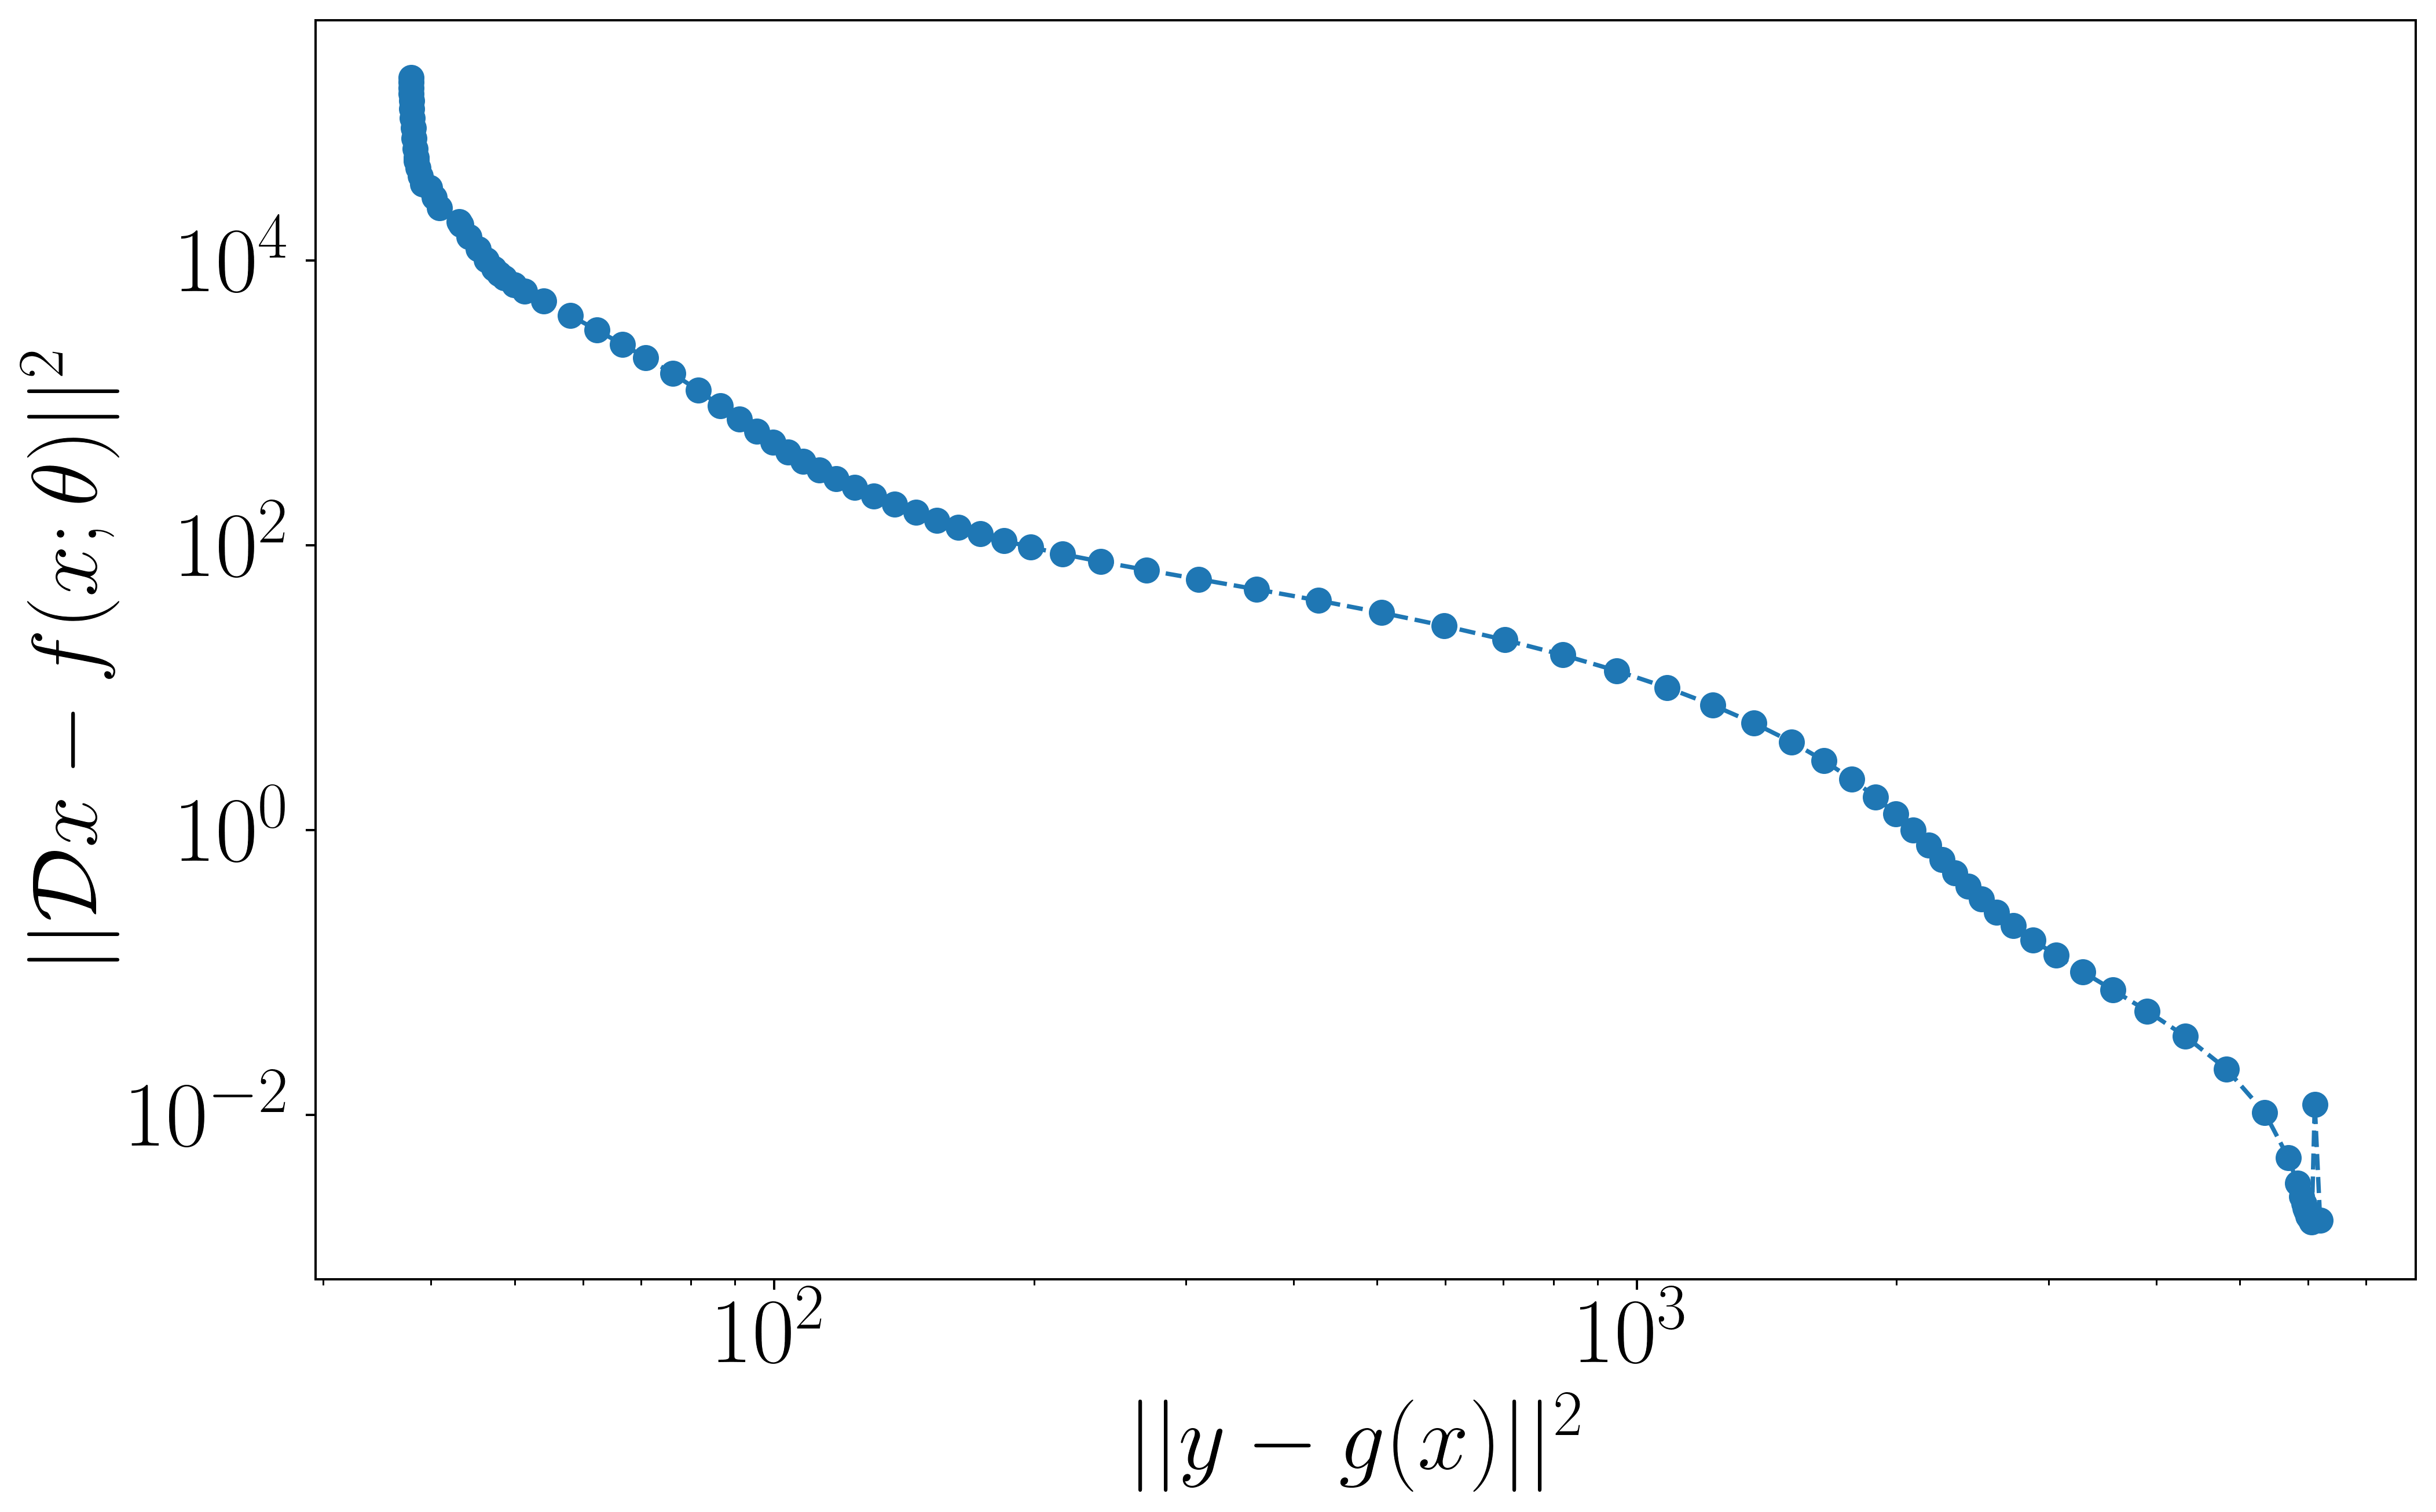

In [542]:
idx = 50
plt.figure(figsize=[13,8],dpi=360)
plt.loglog(*fsvals.T, 'o--',markersize=8)
plt.xticks(font_properties=pub_font)
plt.yticks(font_properties=pub_font)
plt.xlabel(r"$|| y-g(x) ||^2$", font_properties=pub_font)
plt.ylabel(r"$|| \mathcal{D}x-f(x;\theta) ||^2$", font_properties=pub_font)
# plt.loglog(*fsvals[idx], 'ro')

In [352]:
dfsvlas = np.gradient(np.log10(fsvals), axis=0, edge_order=2)
d2fsvals = np.gradient(dfsvlas, axis=0, edge_order=2)
curv = (dfsvlas[:,0]*d2fsvals[:,1] - dfsvlas[:,1]*d2fsvals[:,0])/(dfsvlas[:,0]**2 + dfsvlas[:,1]**2)**(3/2)

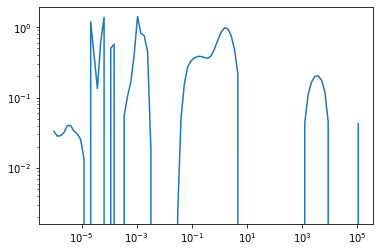

In [359]:
plt.loglog(prange[:-8], curv[:-8])

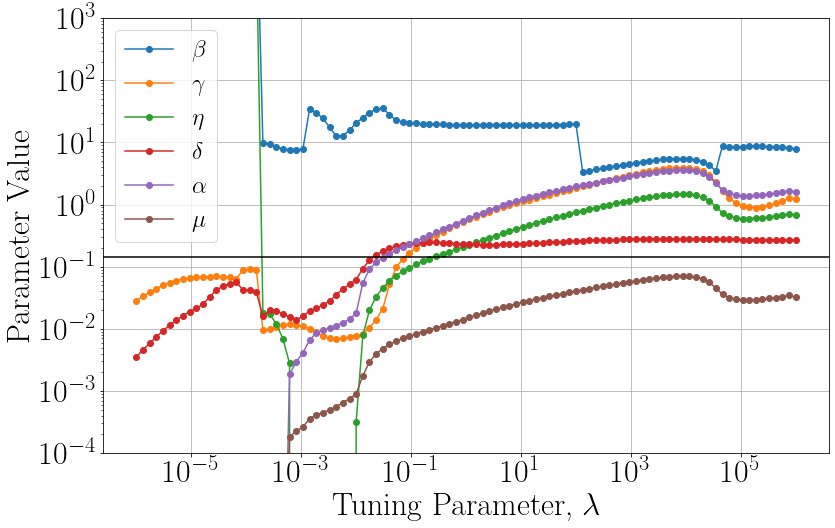

In [563]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
# for q in p0:
#     plt.axhline(q, color='k')
plt.axhline(1/7, color='k', alpha=1)
plt.xscale('log')
plt.xlabel('Tuning Parameter, $\\lambda$', font_properties=pub_font)
plt.ylabel('Parameter Value', font_properties=pub_font)
plt.xticks(font_properties=pub_font)
plt.yticks(font_properties=pub_font)
plt.yscale('log')
# plt.axvline(prange[idx], color='r')
plt.legend(fontsize=24)
plt.ylim([1e-4, 1e3])
plt.grid(True)
# plt.fill([10**-1, 10**2, 10**2, 10**-1],[1e-4, 1e-4, 1e3, 1e3],
#         alpha=0.2, color='goldenrod')

1.68381


(0, 10)

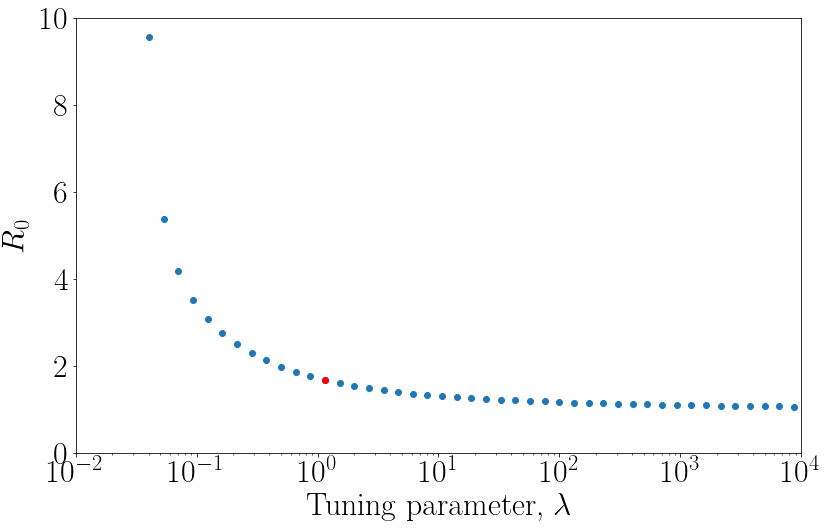

In [551]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
    N = sum(x[0] for x in getx(sol['x']))
    return (b)/(e+a+m) *( getx(sol['x'])[0][0] / N)
plt.figure(figsize=[13,8], )
plt.plot(prange, [r0(sol) for sol in sols], 'o')
plt.plot(prange[idx], r0(sols[idx]), 'ro')
print(r0(sols[idx]))
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r"Tuning parameter, $\lambda$", font_properties=pub_font)
plt.ylabel("$R_0$", font_properties=pub_font)
plt.xticks(font_properties=pub_font)
plt.yticks(font_properties=pub_font)
plt.xlim([1e-2, 1e4])
plt.ylim([0,10])

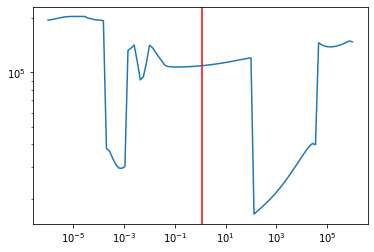

In [320]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')

(DM(19.3124), DM(0.579463), DM(0.225398), DM(0.230009), DM(0.610375), DM(0.0152926))


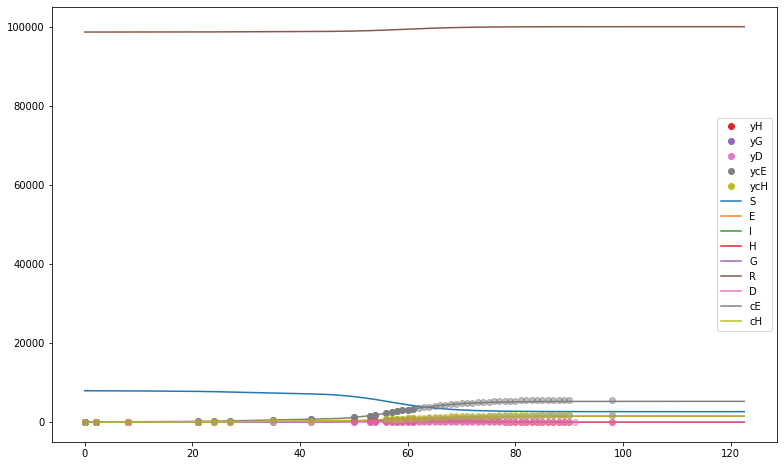

In [492]:
fig, ax=plt.subplots(figsize=[13, 8])
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time[start:clip], data_dots[start:clip], 'o', color=dColours[clr])
for clr, data_stripe in zip(dColours, getx(sols[idx]['x'])):
    ax.plot(model.observation_times, data_stripe, color=clr)
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time, data_dots, 'o', alpha=0.5, color=dColours[clr])
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
# plt.ylim([1e-5, 8000])
# plt.yscale('log')
print(getp(sols[idx]['x']))

In [498]:
from operator import itemgetter

(DM(19.3124), DM(0.579463), DM(0.225398), DM(0.230009), DM(0.610375), DM(0.0152926))


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.]),
 <a list of 8 Text yticklabel objects>)

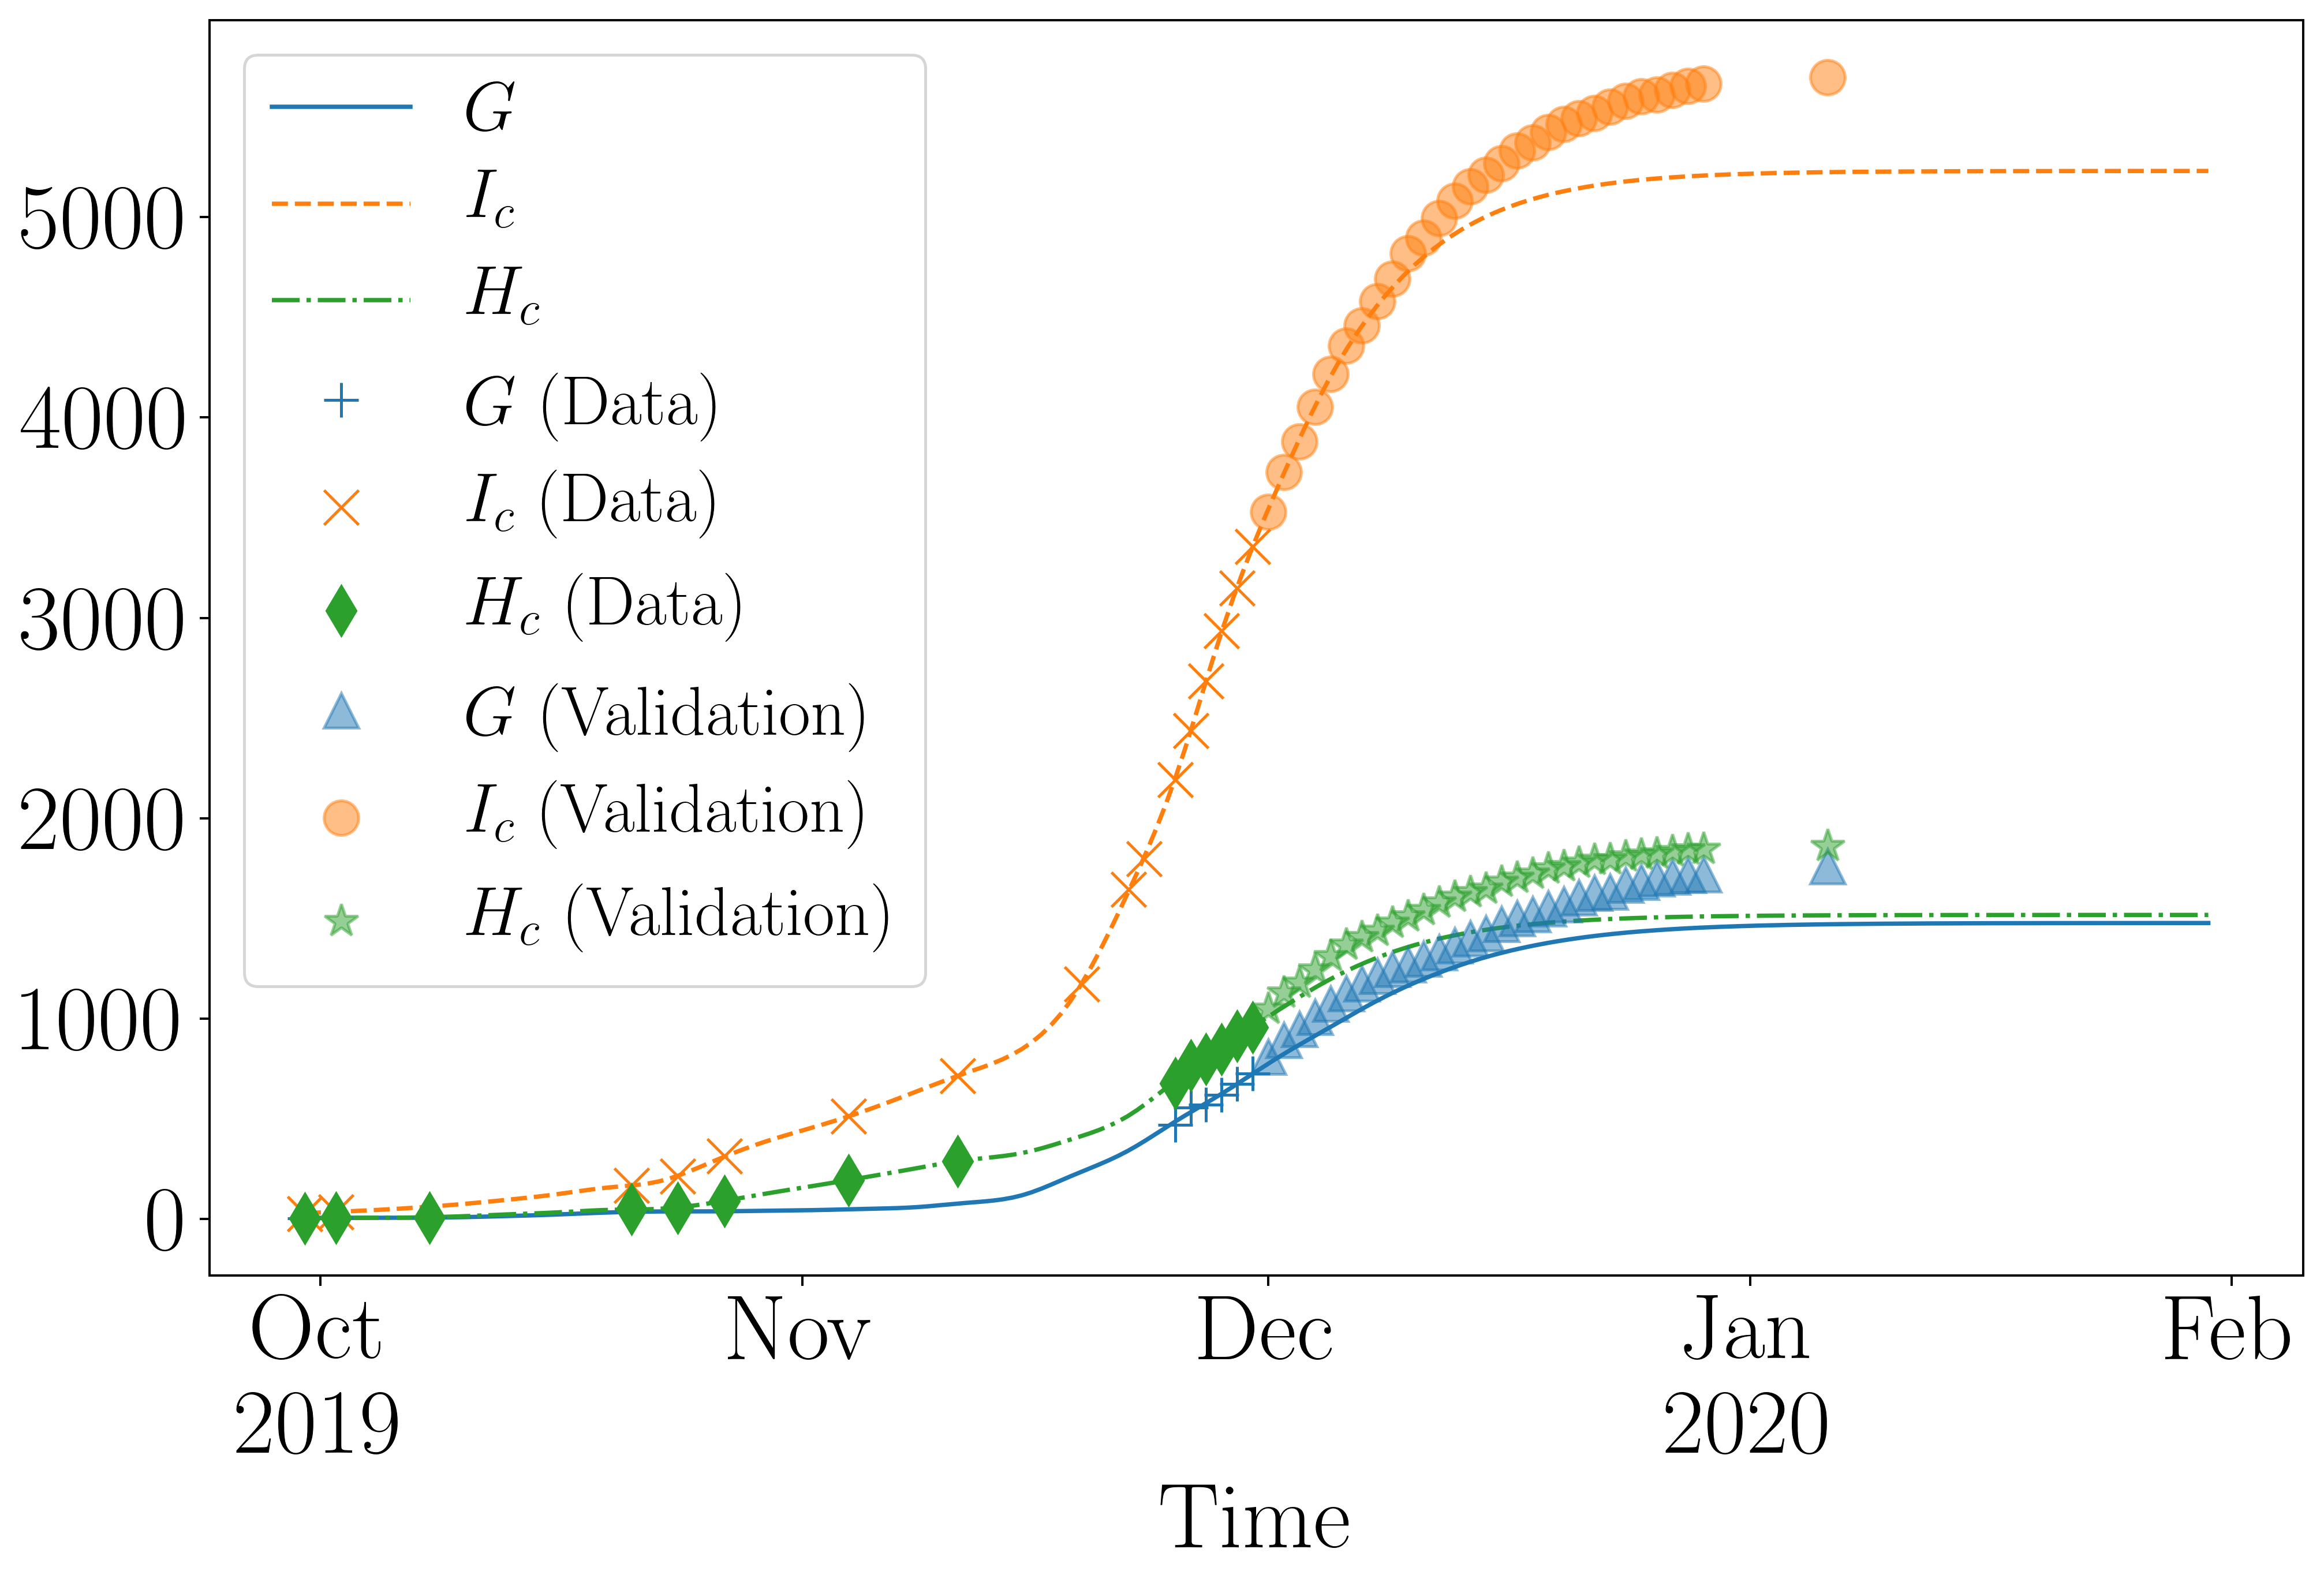

In [562]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=360)
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
lstyle = ['-', '--', '-.']
markersfuture = ['^', 'o', '*']
markersnow = ['+', 'x', 'd']
for clr, data_stripe in enumerate(itemgetter(4, 7,8)(getx(sols[idx]['x']))):
    ax.plot(list(map(time_conv, model.observation_times)), data_stripe, color=dColours[clr], linestyle=lstyle[clr])
for clr, data_dots in enumerate([G,cE,cH]):
    ax.plot(the_dates[start:clip], data_dots[start:clip], markersnow[clr], color=dColours[clr], markersize=12)
for clr, data_dots in enumerate([G,cE,cH]):
    ax.plot(the_dates[clip:], data_dots[clip:], markersfuture[clr], alpha=0.5, color=dColours[clr], markersize=12)
plt.legend(["$G$", "$I_c$", "$H_c$", 
            "$G$ (Data)", "$I_c$ (Data)", "$H_c$ (Data)",
            "$G$ (Validation)", "$I_c$ (Validation)", "$H_c$ (Validation)"], 
           fontsize=24)
# plt.ylim([1e-5, 8000])
# plt.yscale('log')
print(getp(sols[idx]['x']))
plt.xticks(ex_date_tick, ex_date_label, font_properties=pub_font)
plt.xlabel('Time', font_properties=pub_font)
plt.yticks(font_properties=pub_font)

(DM(19.3124), DM(0.579463), DM(0.225398), DM(0.230009), DM(0.610375), DM(0.0152926))


([<matplotlib.axis.YTick at 0x7fa0980e7d90>,
 <a list of 5 Text yticklabel objects>)

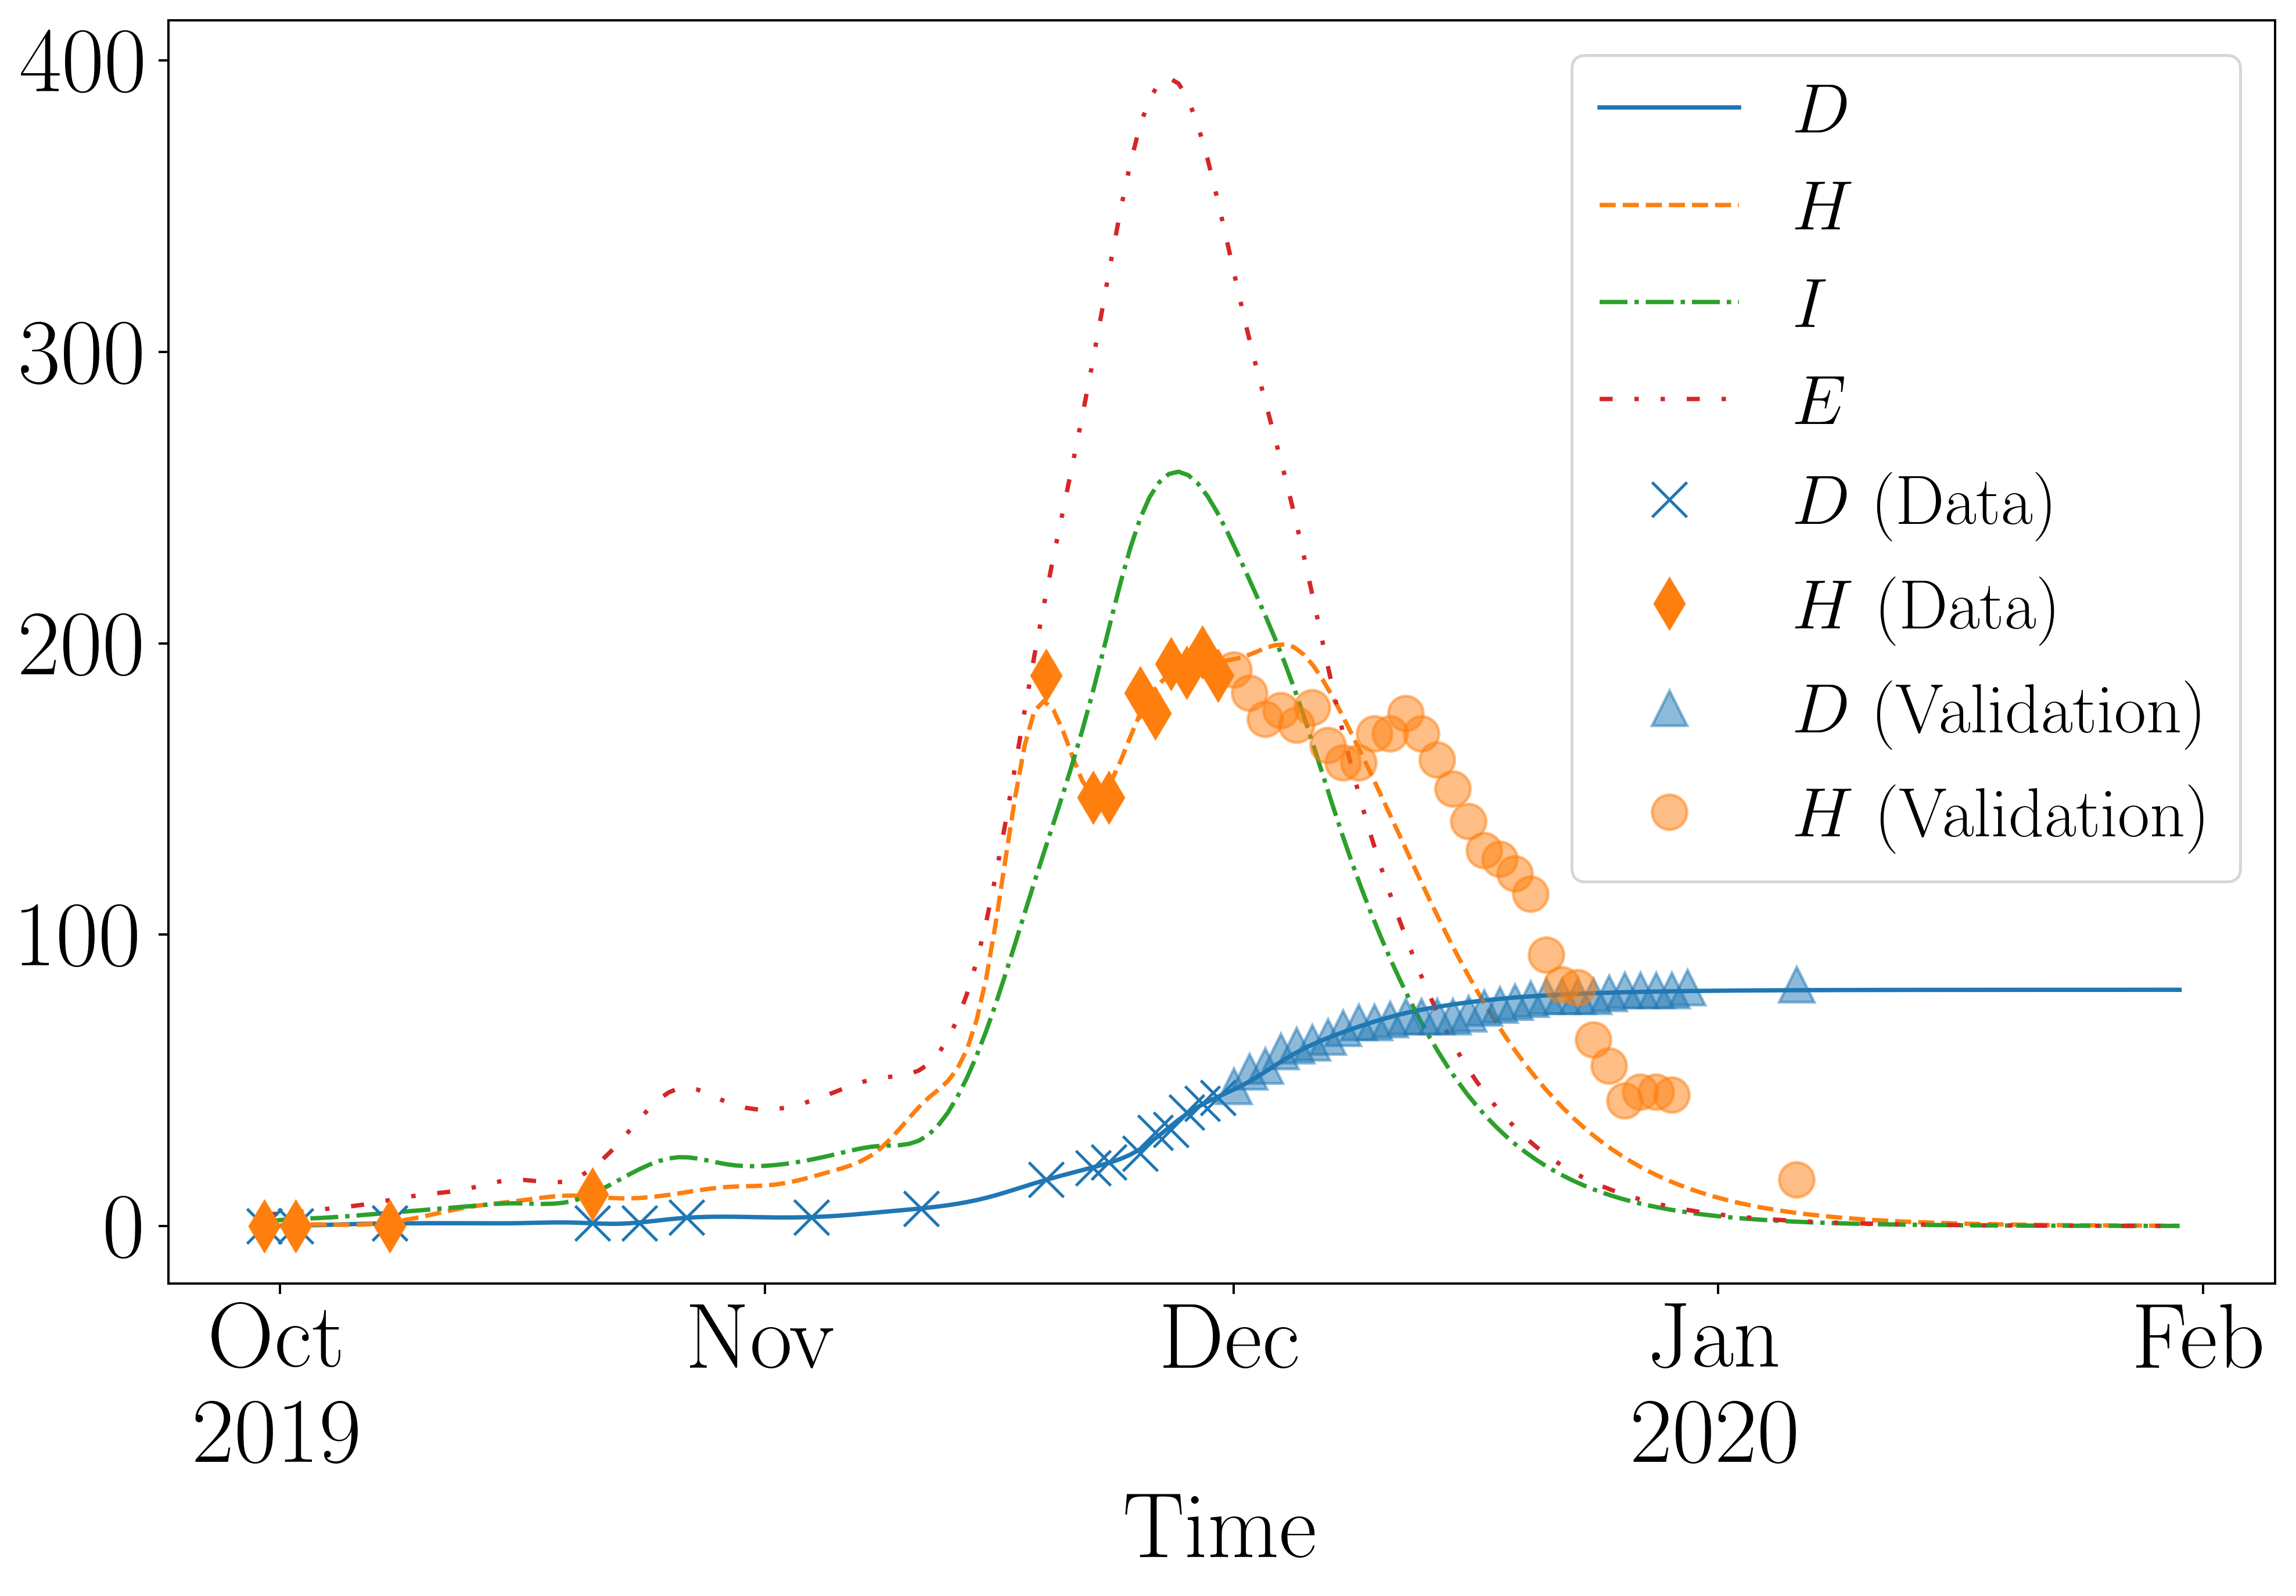

In [561]:
ig, ax=plt.subplots(figsize=[13, 8], dpi=360)
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
lstyle = ['-', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
markersfuture = ['^', 'o',]
markersnow = ['x', 'd']
for clr, data_stripe in enumerate(itemgetter(6, 3, 2, 1)(getx(sols[idx]['x']))):
    ax.plot(list(map(time_conv, model.observation_times)), data_stripe, color=dColours[clr], linestyle=lstyle[clr])
for clr, data_dots in enumerate([D, H]):
    ax.plot(the_dates[start:clip], data_dots[start:clip], markersnow[clr], color=dColours[clr], markersize=12)
for clr, data_dots in enumerate([D, H]):
    ax.plot(the_dates[clip:], data_dots[clip:], markersfuture[clr], alpha=0.5, color=dColours[clr], markersize=12)
plt.legend(["$D$", "$H$", "$I$", "$E$", 
            "$D$ (Data)", "$H$ (Data)", 
            "$D$ (Validation)", "$H$ (Validation)",], 
           fontsize=24)
# plt.ylim([1e-5, 8000])
# plt.yscale('log')
print(getp(sols[idx]['x']))
plt.xticks(ex_date_tick, ex_date_label, font_properties=pub_font)
plt.xlabel('Time', font_properties=pub_font)
plt.yticks([0, 100, 200,300,400], font_properties=pub_font)

In [322]:
print(list(zip("bgedam", getp(sols[idx]['x']))))

[(lbl, yyy[np.argmin(np.abs(model.observation_times-65))]) for lbl, yyy in zip('seihgrdEH', getx(sols[idx]['x'])) ]

[('b', DM(19.3124)), ('g', DM(0.579463)), ('e', DM(0.225398)), ('d', DM(0.230009)), ('a', DM(0.610375)), ('m', DM(0.0152926))]


[('s', DM(3500.33)),
 ('e', DM(257.881)),
 ('i', DM(193.494)),
 ('h', DM(199.609)),
 ('g', DM(925.549)),
 ('r', DM(99647.9)),
 ('d', DM(57.1339)),
 ('E', DM(4093.51)),
 ('H', DM(1165.75))]

81.0681


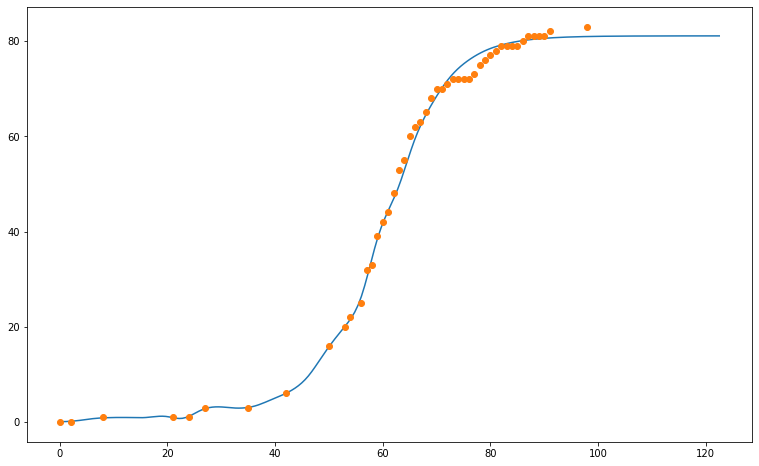

In [323]:
plt.figure(figsize=[13,8])
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')
print(getx(sols[idx]['x'])[6][-1])

(0, 6000)

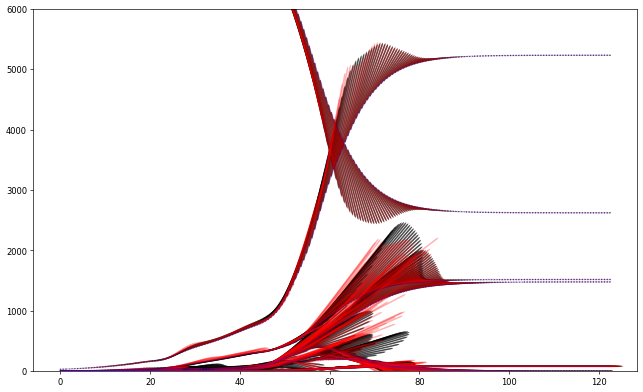

In [324]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
plt.plot(model.observation_times, xx.T, alpha=0.2, color='b')
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.7)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), 
              np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)
plt.ylim([0, 6000])

Text(0.5, 1.0, 'Discrepancy in derivatives (Fitted - Expected)/(State Size)')

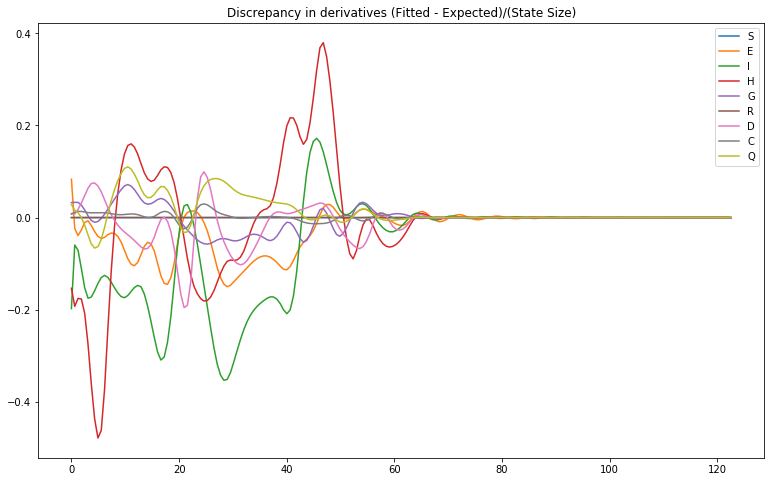

In [344]:
plt.figure(figsize=[13,8])
for i, xxi in enumerate(xx):
    plt.plot(model.observation_times, 
             (np.gradient(xxi, model.observation_times)-dxxdt[:,i])/(xxi+1), )
# plt.yscale('log')
# plt.ylim([-150, 150])
plt.legend('SEIHGRDCQ')
plt.title('Discrepancy in derivatives (Fitted - Expected)/(State Size)')

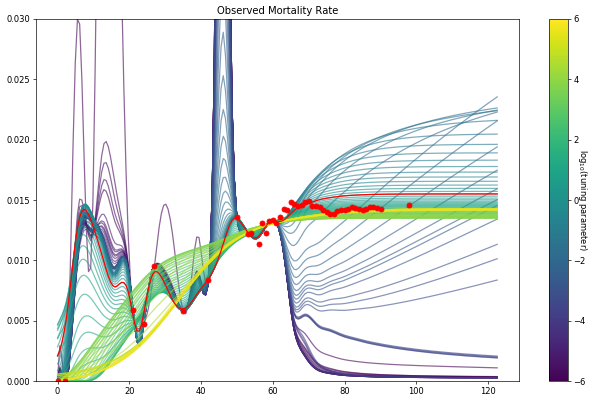

In [326]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (0, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6]/getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.6)
plt.ylim(0, 0.03)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.title("Observed Mortality Rate")
plt.plot(time, D/cE, 'ro')
plt.plot(model.observation_times, getx(sols[idx]['x'])[6]/getx(sols[idx]['x'])[-2],'r')

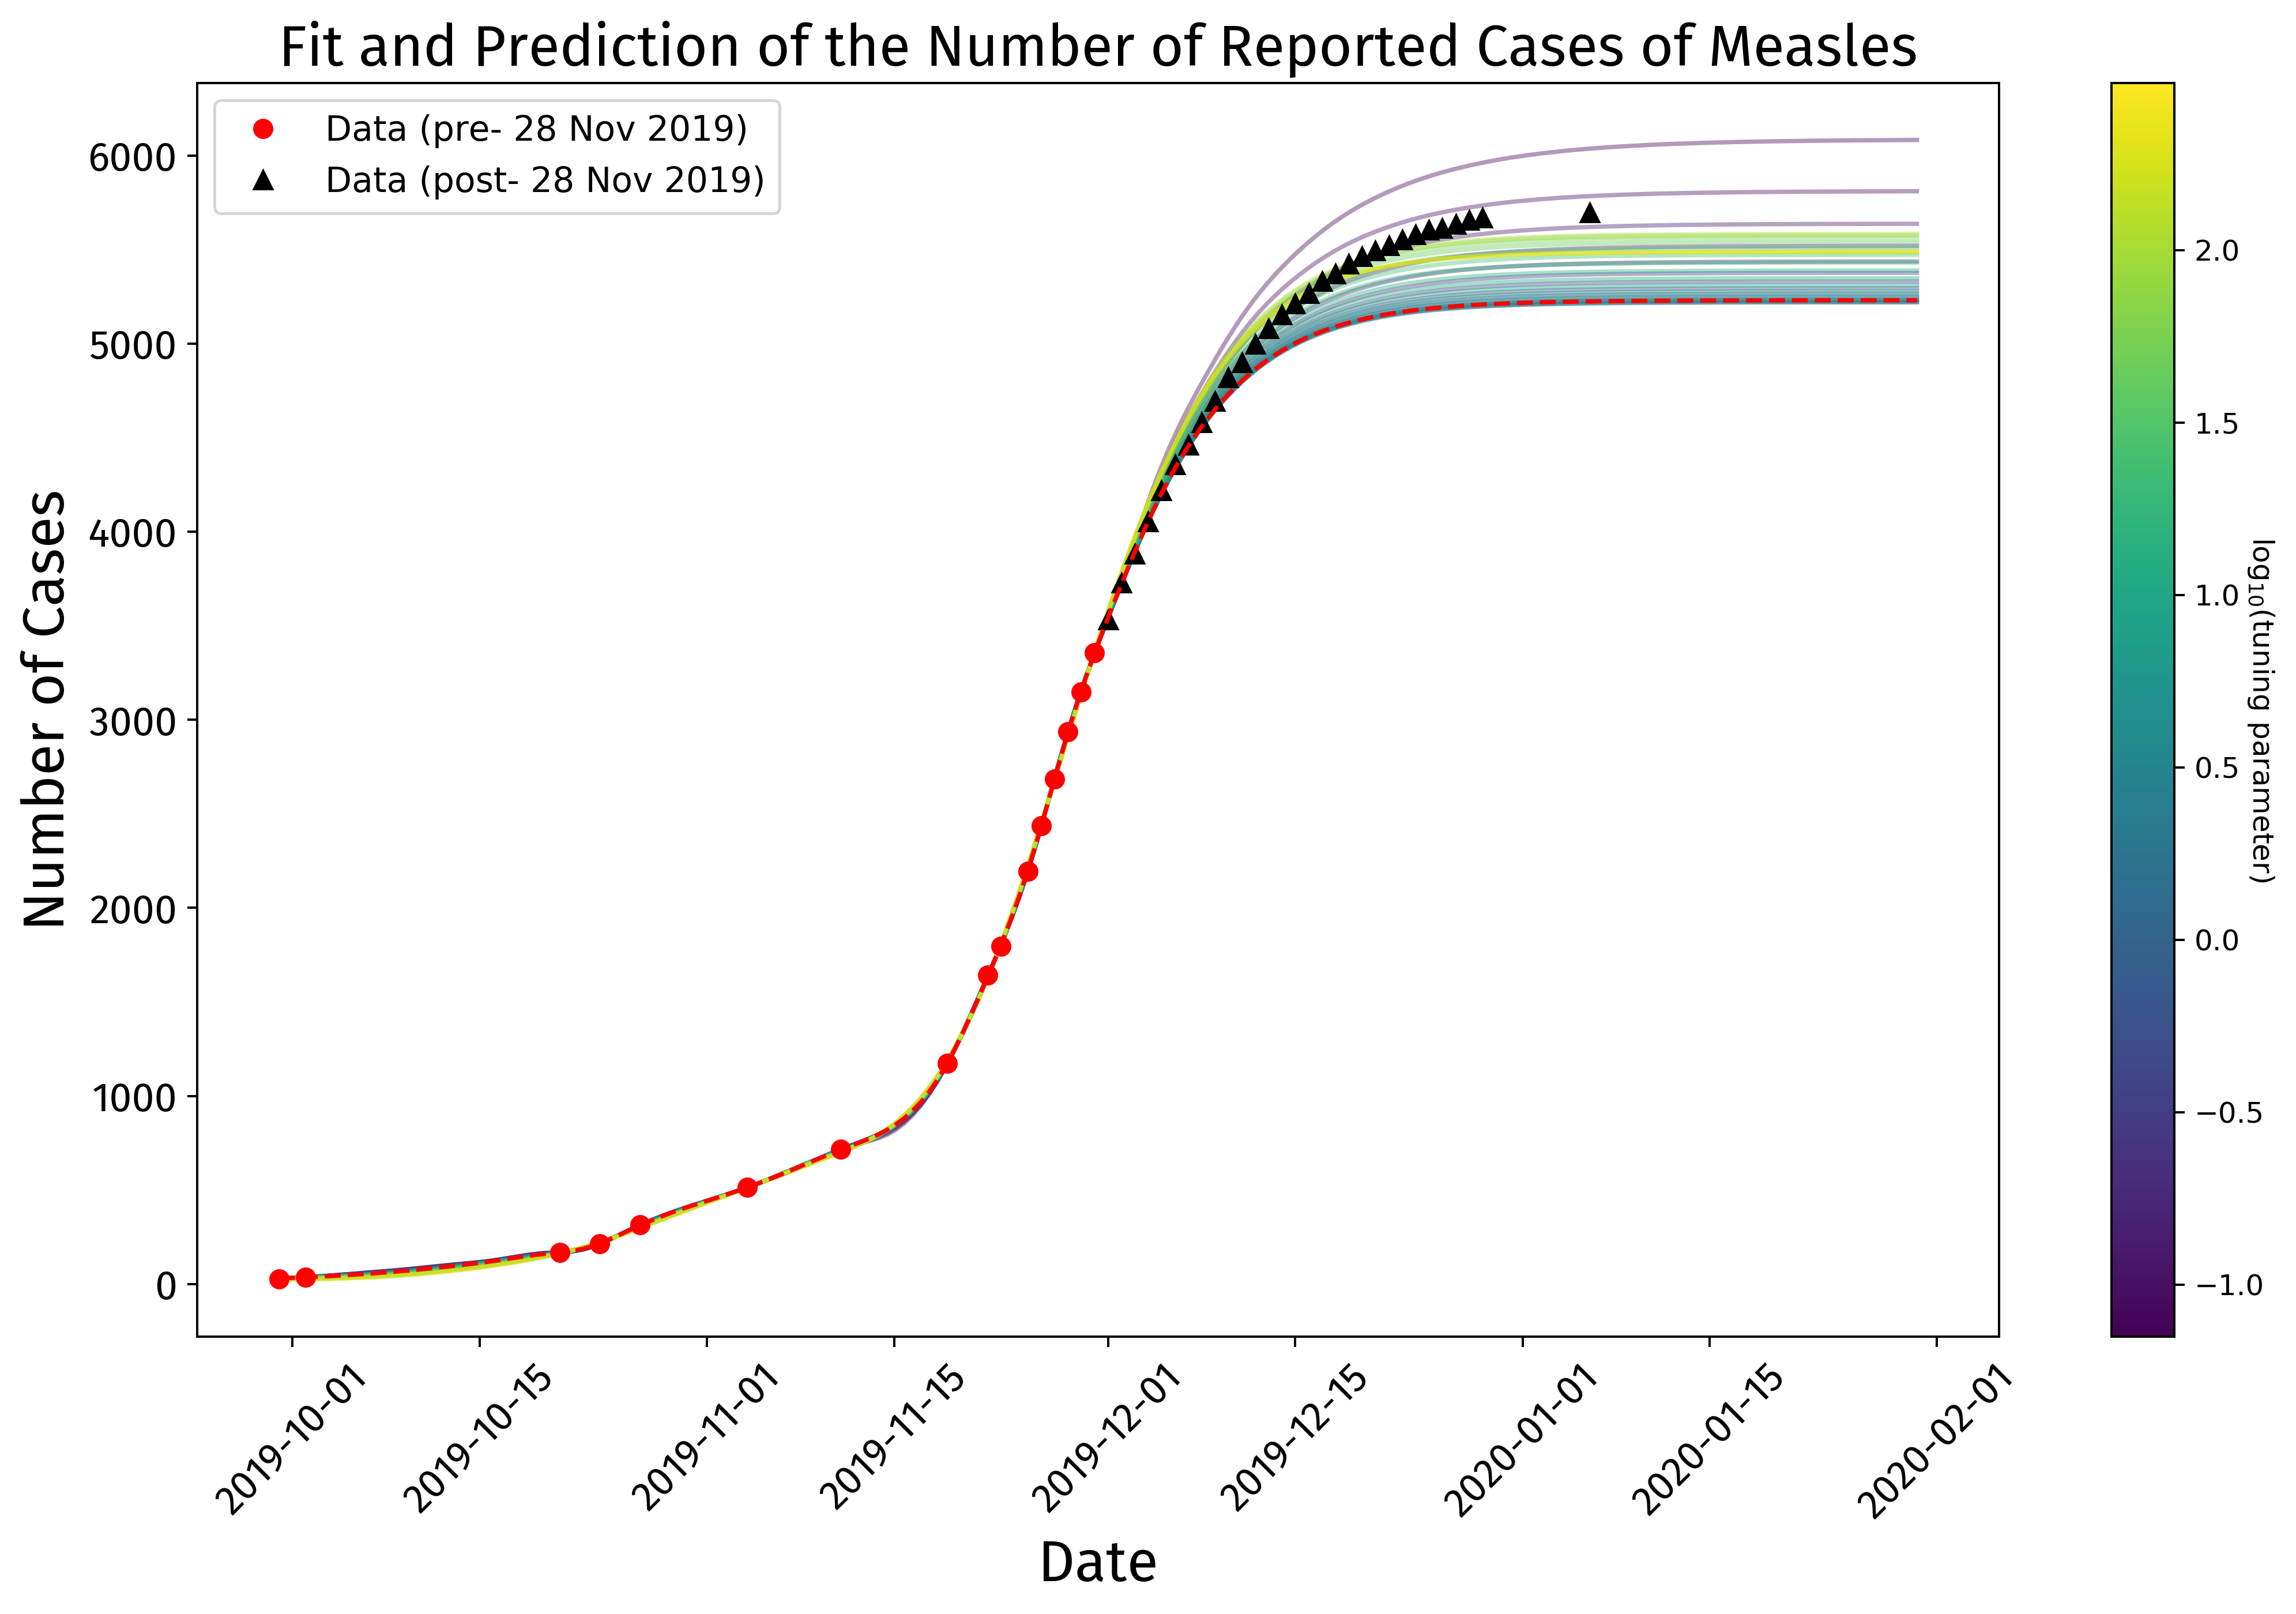

In [327]:
# %matplotlib notebook

plt.figure(figsize=[14,8], dpi=360)

i0, i1 = (40, -30)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[i0:i1:]):
    plt.plot(list(map(time_conv, model.observation_times)), getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(the_dates[start:clip], cE[start:clip], 'ro', label='Data (pre- 28 Nov 2019)')
plt.plot(the_dates[clip:], cE[clip:], 'k^', label='Data (post- 28 Nov 2019)')
plt.title("Fit and Prediction of the Number of Reported Cases of Measles", 
          font_properties=label_font)
plt.xlabel("Date", font_properties=label_font)
plt.ylabel("Number of Cases", font_properties=label_font)
plt.xticks(rotation=45, font_properties=tick_font)
plt.yticks(font_properties=tick_font)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend(fontsize='large')
# plt.ylim([0,10000])

plt.plot(list(map(time_conv, model.observation_times)), getx(sols[idx]['x'])[-2], '--', color='r')

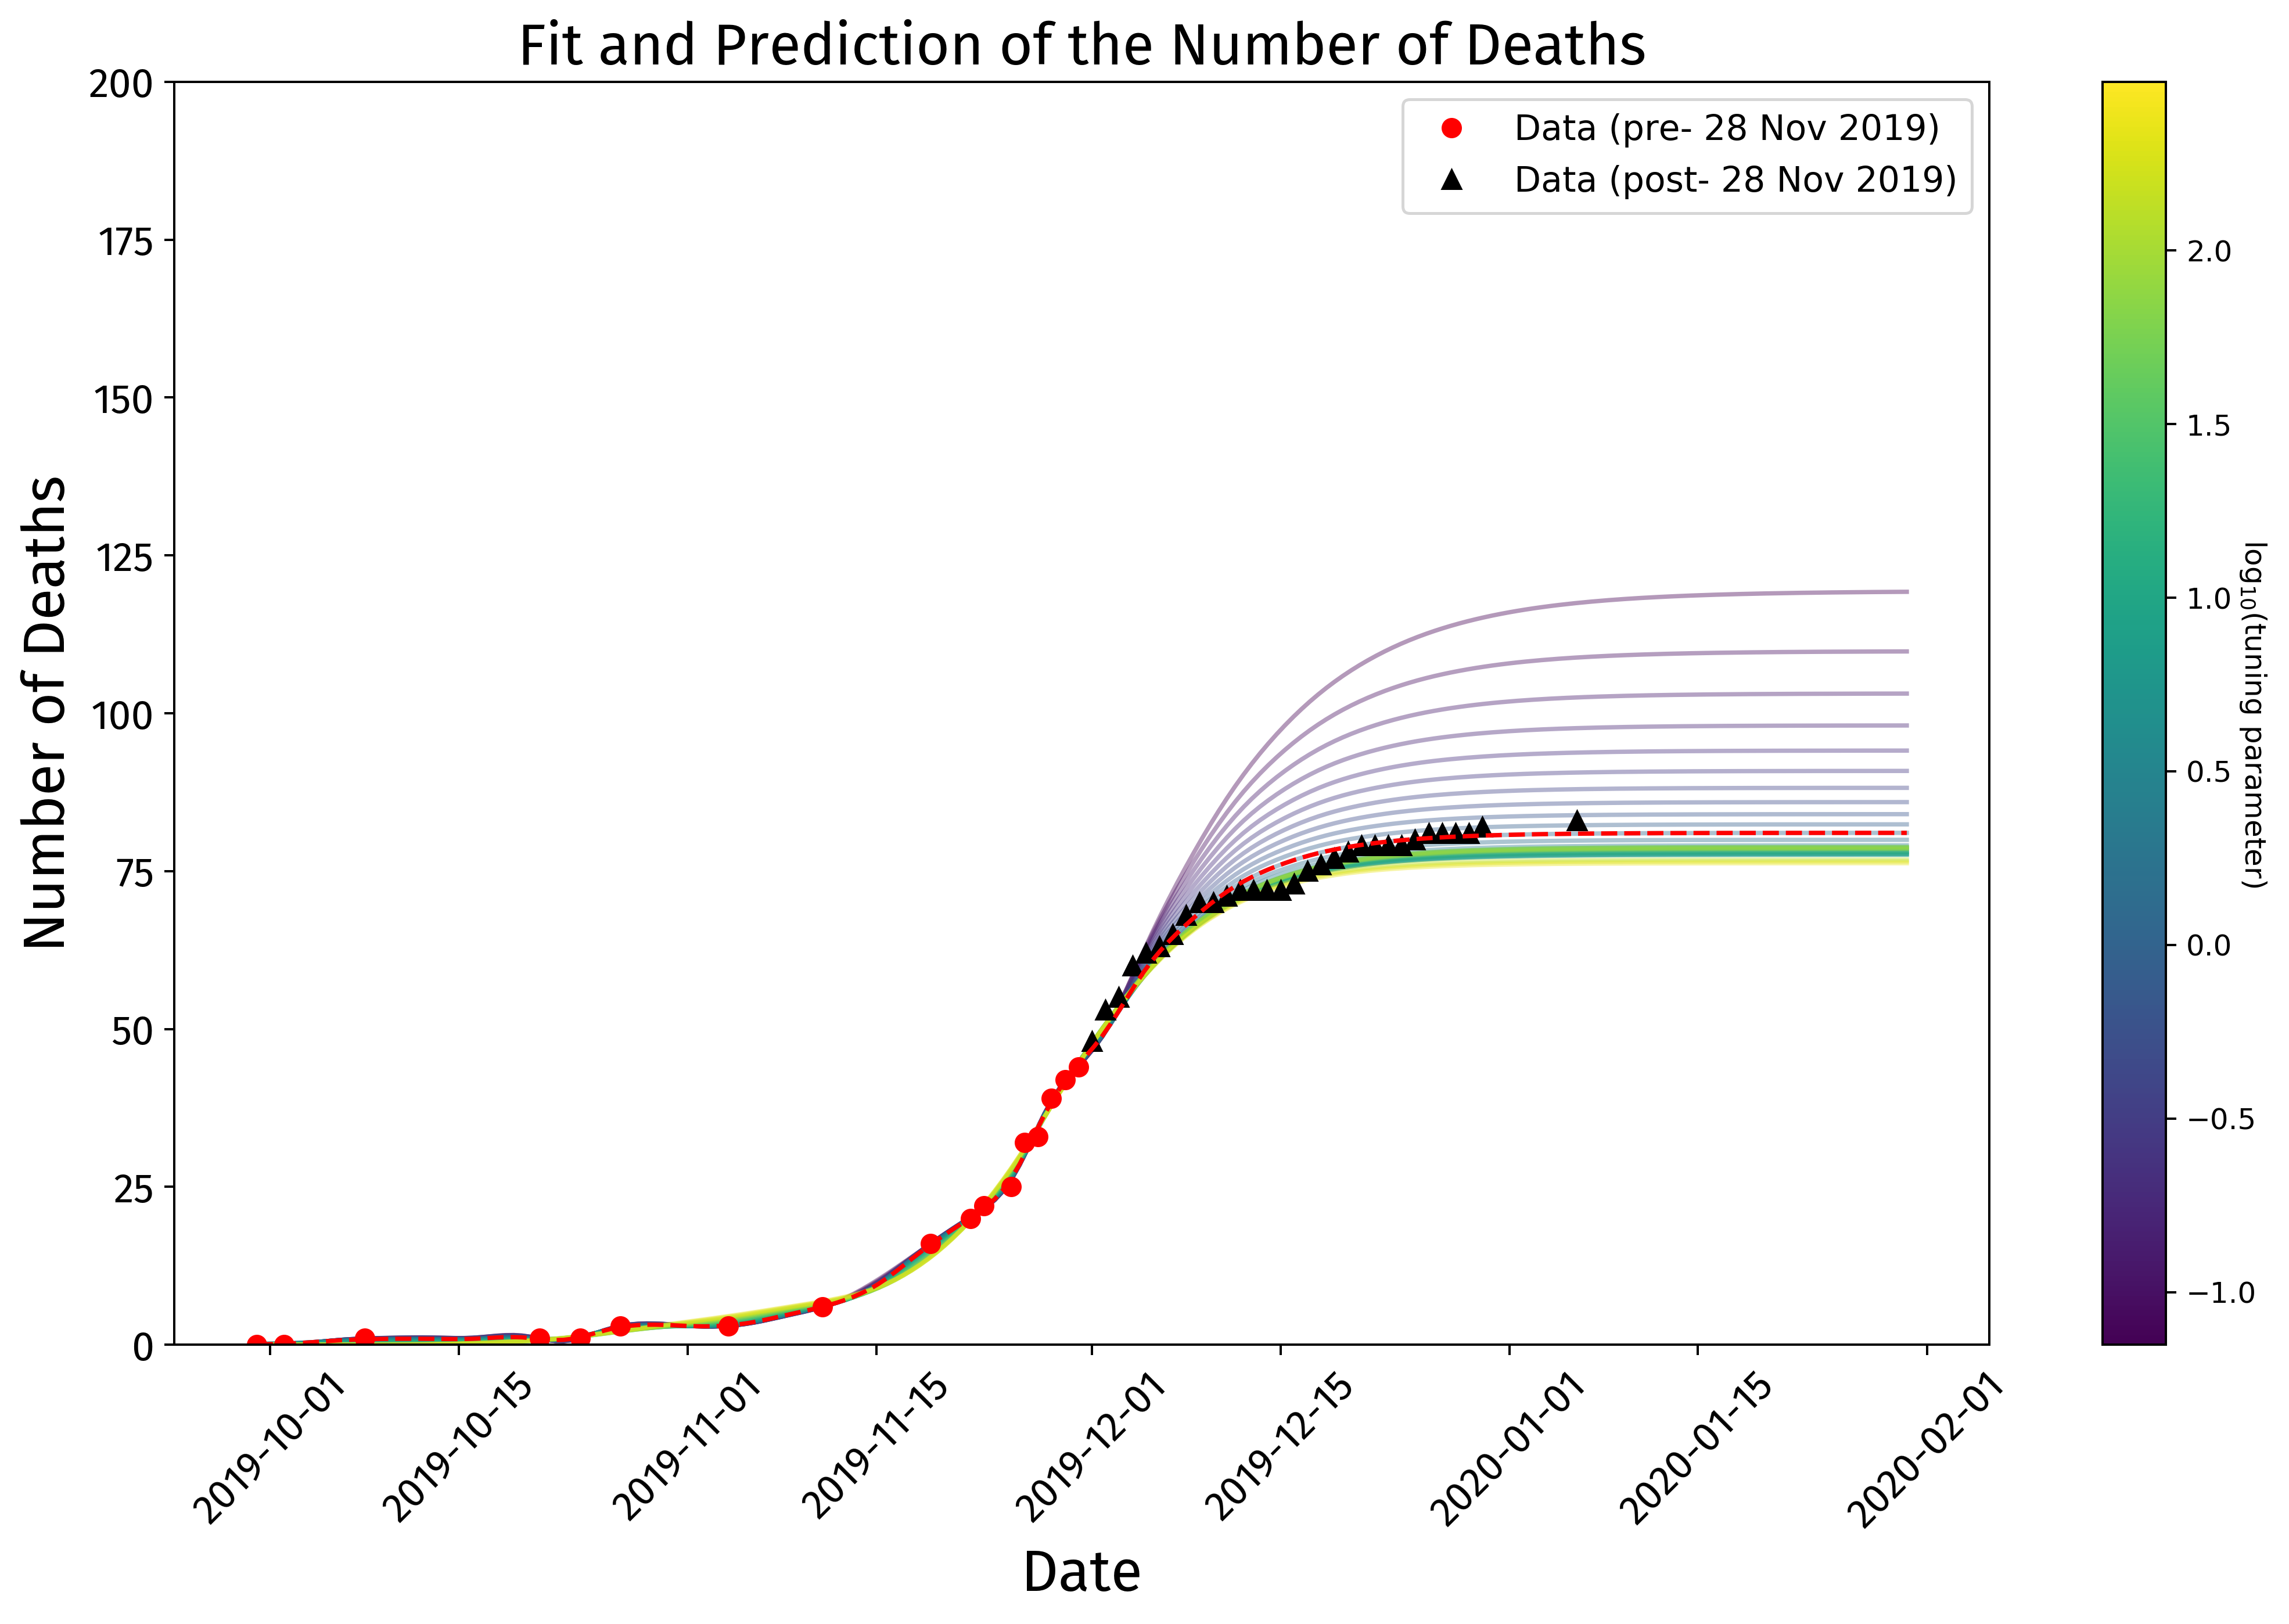

In [328]:
plt.figure(figsize=[14,8], dpi=360)

i0, i1 = (40, -30)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(list(map(time_conv, model.observation_times)), getx(sols[i+i0]['x'])[6], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(the_dates[start:clip], D[start:clip], 'ro', label='Data (pre- 28 Nov 2019)')
plt.plot(the_dates[clip:], D[clip:], 'k^', label='Data (post- 28 Nov 2019)')
plt.title("Fit and Prediction of the Number of Deaths", font_properties=label_font)
plt.xlabel("Date", font_properties=label_font)
plt.ylabel("Number of Deaths", font_properties=label_font)
plt.xticks(rotation=45, font_properties=tick_font)
plt.yticks(font_properties=tick_font)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend(fontsize='large')
plt.ylim([0, 200])

plt.plot(list(map(time_conv, model.observation_times)), getx(sols[idx]['x'])[6], '--', color='r')

array([5487.78491823, 5487.78491823])

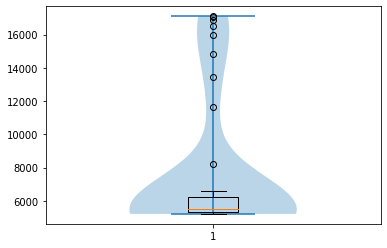

In [29]:
plt.violinplot([getx(s['x'])[-2][-1] for s in sols[30:-30]])
bx=plt.boxplot([getx(s['x'])[-2][-1] for s in sols[30:-30]])
bx['medians'][0].get_ydata()
# plt.yscale('log')

In [30]:
np.min([getx(sols[i]['x'])[-2][-1] for i in range(100)])

5218.791952846286

In [31]:
np.unique(bx['boxes'][0].get_ydata())

array([5306.15825719, 6209.09870011])

(0, 10000)

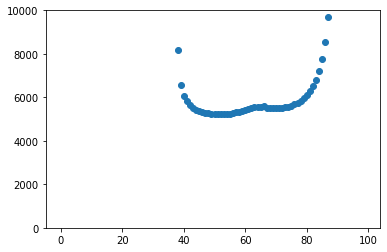

In [32]:
plt.plot([getx(s['x'])[-2][-1] for s in sols],'o')
# cumul reports
plt.ylim([0,10000])

(0, 100)

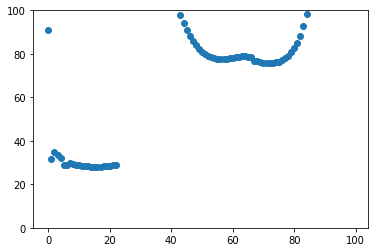

In [33]:
plt.plot([getx(sols[i]['x'])[6][-1] for i in range(100)],'o')
plt.ylim([0, 100])

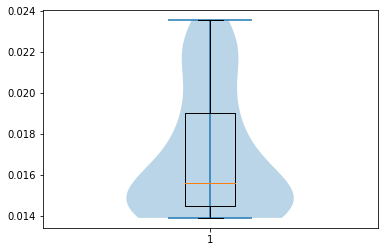

In [34]:
plt.violinplot([(getx(s['x'])[6]/getx(s['x'])[-2])[-1] for s in sols[30:-30]])
bx = plt.boxplot([(getx(s['x'])[6]/getx(s['x'])[-2])[-1] for s in sols[30:-30]])


In [35]:
np.unique(bx['boxes'][0].get_ydata())

array([0.01445975, 0.0190225 ])

In [36]:
morts = [getx(s['x'])[6][-1] for s in sols[30:-30]]
print(np.min(morts))
print(np.median(morts))

76.26511775271
81.74159802654333


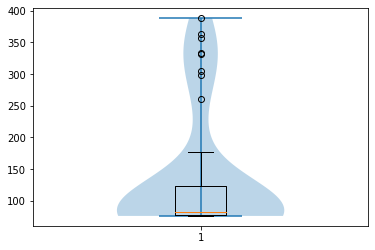

In [37]:
plt.violinplot(morts)
bx = plt.boxplot(morts)


In [38]:
np.unique(bx['boxes'][0].get_ydata())

array([ 78.3904815, 123.1217895])

In [39]:
from scipy import interpolate

print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-2].toarray().flatten())(data_time[-1]+1))
print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-3].toarray().flatten())(data_time[-1]+1))

3541.095765129437
46.65833541997346


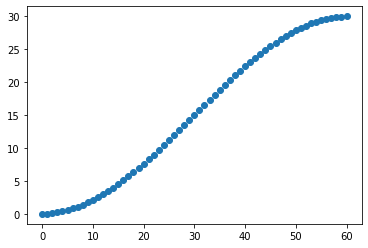

In [453]:
def chebspace(a, b, num=100):
    return np.array([(a+b)/2+(b-a)/2*np.cos((2*(num-k)-1)/(2*num)*np.pi) for k in range(num)])
bcrange = chebspace(0,30, num=61)
plt.plot(bcrange, 'o')

In [468]:
pref = sols[idx]['x']
bprofile = []
brange1 = np.linspace(0,2,num=11)
brange2 = np.linspace(2.5, 30, num=56)
brange = np.concatenate([brange1, brange2])
for b in brange:
    lbxp = copy(lbx)
    lbxp[-6] = b
    ubxp = [np.inf]*len(lbxp)
    ubxp[-6] = b
    psolve_opts = {
        'x0': pref,
        'p': [prange[idx], alpha],
        'lbx': lbxp,
        'ubx': ubxp,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f'b={b}')
    bprofile.append(solver(**psolve_opts))

b=0.0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7022

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


 250  4.5018065e+02 0.00e+00 3.00e+00  -3.8 2.99e+02 -10.3 1.00e+00 1.00e+00f  1
 300  4.2689656e+02 0.00e+00 5.52e+00  -3.8 1.23e+02 -10.1 1.00e+00 1.00e+00f  1
 350  4.1063109e+02 0.00e+00 9.55e+00  -3.8 2.37e+04    -  1.00e+00 6.25e-02f  5
 400  4.0150836e+02 0.00e+00 1.35e-03  -5.7 2.10e+00  -8.3 1.00e+00 1.00e+00h  1
 450  3.9628591e+02 0.00e+00 3.95e-01  -5.7 3.54e+02 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9392316e+02 0.00e+00 1.50e-03  -8.6 2.86e+01 -10.4 9.94e-01 6.18e-01f  1
 550  3.9206028e+02 0.00e+00 4.40e-03  -8.6 6.19e+00  -9.3 1.00e+00 1.00e+00h  1
 600  3.8251970e+02 0.00e+00 3.79e-01  -8.6 3.61e+02  -8.9 1.89e-01 6.25e-02f  5

Number of Iterations....: 625

                                   (scaled)                 (unscaled)
Objective...............:   1.6836036677119008e+00    3.7799675419998653e+02
Dual infeasibility......:   9.3106039801085853e-13    2.0903839493920367e-10
Constraint vio

 200  4.7447051e+02 0.00e+00 1.41e+01  -3.8 1.55e+03 -11.1 1.00e+00 2.50e-01f  3
 250  4.5707173e+02 0.00e+00 1.90e+01  -3.8 8.44e+02  -9.5 1.00e+00 2.50e-01f  3
 300  4.2455204e+02 0.00e+00 2.20e+01  -3.8 7.59e+02 -10.8 1.00e+00 1.00e+00f  1
 350  3.8294529e+02 0.00e+00 3.72e+00  -3.8 1.23e+04    -  1.00e+00 2.50e-01f  3
 400  3.6759034e+02 0.00e+00 3.16e+00  -5.7 1.85e+04    -  7.99e-01 1.25e-01f  4
 450  3.6063173e+02 0.00e+00 6.40e-01  -5.7 5.44e+02 -10.4 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.5809823e+02 0.00e+00 9.43e-03  -8.6 7.84e+02 -11.6 1.00e+00 1.00e+00f  1
 550  3.4702184e+02 0.00e+00 4.92e-03  -8.6 2.57e+00  -7.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 569

                                   (scaled)                 (unscaled)
Objective...............:   1.5583043464409623e+00    3.3876542468526821e+02
Dual infeasibility......:   9.7772573484437860e-10    2.1255133796344091e-07
Constraint vio

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7022

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1739427e+04 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.

 200  4.7149851e+02 0.00e+00 2.14e+01  -3.8 2.15e+06 -12.2 8.46e-03 2.66e-04f  7
 250  4.6297166e+02 0.00e+00 1.82e+00  -3.8 1.77e+03 -12.4 1.00e+00 5.00e-01f  2
 300  4.4092723e+02 0.00e+00 2.04e+01  -3.8 1.21e+03 -10.8 1.00e+00 5.00e-01f  2
 350  4.0119858e+02 0.00e+00 1.82e+01  -3.8 8.15e+02 -10.3 1.00e+00 2.50e-01f  3
 400  3.6531075e+02 0.00e+00 1.02e+00  -3.8 3.38e+02 -10.5 1.00e+00 1.00e+00f  1
 450  3.5694248e+02 0.00e+00 3.86e-01  -5.7 6.93e+00  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.5093615e+02 0.00e+00 3.42e-02  -8.6 7.91e+01 -10.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 547

                                   (scaled)                 (unscaled)
Objective...............:   1.6273159414775540e+00    3.3444955971308394e+02
Dual infeasibility......:   7.2129776790251458e-11    1.4824270736141724e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  50  5.4365965e+03 0.00e+00 2.52e+03  -1.0 1.05e+04    -  1.00e+00 2.50e-01f  3
 100  4.7161755e+02 0.00e+00 2.96e+01  -3.8 4.87e+02 -11.2 1.00e+00 1.00e+00f  1
 150  4.6541829e+02 0.00e+00 1.55e+00  -3.8 9.80e+01 -11.1 1.00e+00 1.00e+00h  1
 200  4.6182795e+02 0.00e+00 1.13e-01  -3.8 1.83e+04    -  1.00e+00 1.75e-02f  6
 250  4.5694949e+02 0.00e+00 7.61e+00  -3.8 1.84e+02 -11.2 1.00e+00 1.00e+00f  1
 300  4.4366736e+02 0.00e+00 4.01e+01  -3.8 2.13e+02 -10.0 1.00e+00 1.00e+00f  1
 350  3.9382574e+02 0.00e+00 1.51e+01  -3.8 1.91e+02  -9.0 1.00e+00 1.00e+00f  1
 400  3.5521800e+02 0.00e+00 7.76e-01  -5.7 2.54e+01  -8.0 1.00e+00 1.00e+00f  1
 450  3.4524065e+02 0.00e+00 3.81e-06  -5.7 2.36e+00  -8.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 477

                                   (scaled)                 (unscaled)
Objective...............:   1.7810977052902732e+00    3.3433889746837411e+02
Dual infea

 100  5.3090997e+02 0.00e+00 6.73e+01  -3.8 2.34e+03  -9.1 7.29e-01 1.10e-01f  3
 150  4.6057183e+02 0.00e+00 1.37e+01  -3.8 1.72e+03 -12.1 1.00e+00 2.50e-01f  3
 200  4.4789368e+02 0.00e+00 1.91e+01  -3.8 8.14e+02 -11.3 1.00e+00 5.00e-01f  2
 250  4.2603980e+02 0.00e+00 4.52e+01  -3.8 1.18e+03    -  1.00e+00 5.00e-01f  2
 300  3.9424914e+02 0.00e+00 2.98e+00  -3.8 7.51e+01  -8.8 1.00e+00 1.00e+00f  1
 350  3.4322792e+02 0.00e+00 2.61e+00  -3.8 9.95e+03    -  1.00e+00 5.00e-01f  2
 400  3.4215851e+02 0.00e+00 1.76e-01  -5.7 1.80e+01  -9.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 425

                                   (scaled)                 (unscaled)
Objective...............:   1.9675020657660480e+00    3.3429425173639663e+02
Dual infeasibility......:   2.8161647405962681e-09    4.7848879099270858e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5859893312649736e-09    4.3938015798572633e-07
Overall NLP error.....

  50  4.6315001e+03 0.00e+00 5.66e+03  -1.0 8.71e+03    -  1.00e+00 5.00e-01f  2
 100  4.6485650e+02 0.00e+00 4.33e+00  -3.8 3.11e+02 -11.0 1.00e+00 1.00e+00f  1
 150  4.5230254e+02 0.00e+00 1.13e+02  -3.8 2.15e+03 -12.1 1.00e+00 1.00e+00f  1
 200  4.3536113e+02 0.00e+00 2.17e+01  -3.8 7.38e+03 -11.1 1.00e+00 9.27e-02f  4
 250  4.0617240e+02 0.00e+00 3.00e+00  -3.8 1.01e+02  -9.5 1.00e+00 1.00e+00f  1
 300  3.8125490e+02 0.00e+00 1.71e+00  -3.8 1.86e+03    -  1.00e+00 5.00e-01f  2
 350  3.4142035e+02 0.00e+00 8.09e-01  -5.7 5.89e+04    -  4.33e-01 9.77e-02f  3

Number of Iterations....: 378

                                   (scaled)                 (unscaled)
Objective...............:   2.1976889191238405e+00    3.3427030802822202e+02
Dual infeasibility......:   2.4765239946019344e-09    3.7668135435878902e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5817761491026234e-09    3.9269029438639114e-07
Overall NLP error.....

  50  1.3067872e+03 0.00e+00 2.85e+00  -1.7 5.75e+01  -7.4 1.00e+00 1.00e+00f  1
 100  4.5973882e+02 0.00e+00 4.78e+01  -3.8 4.22e+02 -11.1 1.00e+00 1.00e+00f  1
 150  4.4547926e+02 0.00e+00 5.78e+01  -3.8 2.29e+03 -11.9 1.00e+00 5.00e-01f  2
 200  4.1520156e+02 0.00e+00 5.24e+01  -3.8 1.28e+03    -  1.00e+00 2.50e-01f  3
 250  4.0016322e+02 0.00e+00 5.14e+00  -3.8 9.00e+01  -9.3 1.00e+00 1.00e+00f  1
 300  3.7736783e+02 0.00e+00 6.64e+00  -3.8 1.18e+02  -8.5 1.00e+00 1.00e+00f  1
 350  3.3427203e+02 0.00e+00 1.05e-01  -5.7 2.12e+03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 359

                                   (scaled)                 (unscaled)
Objective...............:   2.4889878478555842e+00    3.3425539921695577e+02
Dual infeasibility......:   2.1746030265723091e-09    2.9203549684325421e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5772255722263050e-09    3.4610517012320663e-07
Overall NLP error.....

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7022

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8344529e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.

  50  3.2939403e+03 0.00e+00 8.56e-02  -1.0 1.29e+01    -  1.00e+00 1.00e+00h  1
 100  4.5914675e+02 0.00e+00 1.63e+02  -3.8 1.21e+03 -11.3 1.00e+00 1.00e+00f  1
 150  4.4336233e+02 0.00e+00 1.30e+02  -3.8 1.18e+03 -11.2 1.00e+00 5.00e-01f  2
 200  4.1907583e+02 0.00e+00 2.50e+00  -3.8 8.36e+01  -9.3 1.00e+00 1.00e+00f  1
 250  4.0234657e+02 0.00e+00 1.82e+00  -3.8 6.83e+01  -9.3 1.00e+00 1.00e+00f  1
 300  3.8934921e+02 0.00e+00 2.26e+00  -3.8 6.58e+01  -8.4 1.00e+00 1.00e+00f  1
 350  3.3937221e+02 0.00e+00 2.68e+00  -3.8 9.77e+03    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 375

                                   (scaled)                 (unscaled)
Objective...............:   3.3871067469477185e+00    3.3423784749299659e+02
Dual infeasibility......:   1.5277538905327630e-09    1.5075792114638178e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5638985717696729e-09    2.5300411349329441e-07
Overall NLP error.....

 250  4.0453972e+02 0.00e+00 3.67e+00  -3.8 1.05e+02  -9.5 1.00e+00 1.00e+00f  1
 300  3.9495539e+02 0.00e+00 5.36e+01  -3.8 2.88e+02    -  1.00e+00 1.00e+00f  1
 350  3.6216152e+02 0.00e+00 4.63e+00  -3.8 7.77e+03    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 392

                                   (scaled)                 (unscaled)
Objective...............:   4.1328381197868724e+00    3.3423224814400709e+02
Dual infeasibility......:   1.1696434518031615e-09    9.4591791183741643e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5543328445419251e-09    2.0657484866195314e-07
Overall NLP error.......:   2.5543328445419251e-09    2.0657484866195314e-07


Number of objective function evaluations             = 794
Number of objective gradient evaluations             = 393
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 794
Number of equality constraint Jac

 200  4.1937301e+02 0.00e+00 5.19e+01  -3.8 5.81e+02 -10.6 1.00e+00 1.00e+00f  1
 250  4.0176034e+02 0.00e+00 7.30e+01  -5.7 2.78e+03    -  4.94e-01 2.50e-01f  3
 300  3.9203526e+02 0.00e+00 1.23e+02  -5.7 3.74e+03    -  1.00e+00 1.90e-01f  3
 350  3.4849192e+02 0.00e+00 1.25e+01  -5.7 8.76e+01  -8.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 384

                                   (scaled)                 (unscaled)
Objective...............:   5.2997188337347616e+00    3.3422785489920676e+02
Dual infeasibility......:   7.5570428801241782e-10    4.7658645872450758e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5407011315863326e-09    1.6022983780663452e-07
Overall NLP error.......:   2.5407011315863326e-09    1.6022983780663452e-07


Number of objective function evaluations             = 731
Number of objective gradient evaluations             = 385
Number of equality constraint evaluations            = 0
Number of i

 100  4.7165580e+02 0.00e+00 9.55e+02  -2.5 1.56e+03 -11.4 1.00e+00 1.00e+00f  1
 150  4.4689790e+02 0.00e+00 3.54e+02  -3.8 1.46e+03 -11.1 1.00e+00 5.00e-01f  2
 200  4.2055349e+02 0.00e+00 1.03e+02  -3.8 2.94e+03 -11.0 1.00e+00 2.50e-01f  3
 250  4.0395604e+02 0.00e+00 1.53e-01  -3.8 5.66e+00  -7.9 1.00e+00 1.00e+00f  1
 300  3.9751626e+02 0.00e+00 8.28e+01  -3.8 1.84e+04    -  4.80e-01 1.47e-02f  5
 350  3.8205599e+02 0.00e+00 6.41e-01  -3.8 3.69e+01  -7.5 1.00e+00 1.00e+00f  1
 400  3.3439293e+02 0.00e+00 1.82e+00  -5.7 9.43e+02    -  9.74e-01 1.00e+00f  1

Number of Iterations....: 410

                                   (scaled)                 (unscaled)
Objective...............:   7.3848540482107587e+00    3.3422431608737821e+02
Dual infeasibility......:   3.7509802472758406e-10    1.6976216450842086e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5256057250353241e-09    1.1430406622062027e-07
Overall NLP error.....

 250  4.1025093e+02 0.00e+00 7.95e+01  -3.8 7.00e+02  -9.3 1.00e+00 2.50e-01f  3
 300  4.0215017e+02 0.00e+00 1.06e+00  -3.8 3.03e+01  -8.5 1.00e+00 1.00e+00f  1
 350  3.9437050e+02 0.00e+00 3.23e-01  -3.8 1.28e+01  -7.6 1.00e+00 1.00e+00f  1
 400  3.6411691e+02 0.00e+00 7.47e+00  -3.8 3.75e+01  -7.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 446

                                   (scaled)                 (unscaled)
Objective...............:   1.2175219492388527e+01    3.3422140451315215e+02
Dual infeasibility......:   4.3631383095798816e-09    1.1977231415208344e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0211385826632095e-09    2.8031229458625068e-08
Overall NLP error.......:   4.3631383095798816e-09    1.1977231415208344e-07


Number of objective function evaluations             = 899
Number of objective gradient evaluations             = 447
Number of equality constraint evaluations            = 0
Number of i

 300  4.0866580e+02 0.00e+00 8.56e-01  -2.5 1.66e+01  -8.5 1.00e+00 1.00e+00f  1
 350  4.0211181e+02 0.00e+00 7.91e+01  -2.5 1.25e+02  -8.9 1.00e+00 1.00e+00f  1
 400  3.8237994e+02 0.00e+00 6.79e+01  -2.5 5.16e+03    -  1.00e+00 5.00e-01f  2
 450  3.3437698e+02 0.00e+00 9.37e-02  -3.8 3.63e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 461

                                   (scaled)                 (unscaled)
Objective...............:   3.4656247461330253e+01    3.3421896729659346e+02
Dual infeasibility......:   1.4449125351433681e-09    1.3934491201575200e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5903338500687541e-09    2.4980739916789515e-08
Overall NLP error.......:   2.5903338500687541e-09    2.4980739916789515e-08


Number of objective function evaluations             = 1003
Number of objective gradient evaluations     

        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5140784e+02 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  6.4057221e+02 0.00e+00 5.10e+03  -1.0 6.58e+02  -8.0 1.00e+00 1.00e+00f  1
 100  6.1534150e+02 0.00e+00 3.07e+02  -1.0 3.85e+02    -  1.00e+00 1.00e+00f  1
 150  4.4852120e+02 0.00e+00 8.99e+02  -2.5 5.55e+02  -8.8 1.00e+00 1.00e+00f  1
 200  4.3125558e+02 0.00e+00 2.48e+02  -2.5 3.68e+02 -10.1 1.00e+00 1.00e+00f  1
 250  4.1530946e+02 0.00e+00 1.14e+03  -2.5 1.31e+05    -  2.56e-01 5.16e-03f  6
 300  4.0842762e+02 0.00e+00 5.46e+01  -2.5 1.27e+02  -9.3 1.00e+00 1.00e+00f  1
 350  4.0123733e+02 0.00e+00 1.45e+01  -2.5 4.39e+01  -8.3 1.00e+00 1.00e+00f  1
 400  3.8703681e+02 0.00e+00 5.55e+01  -2.5 5.99e+01  -7.9 1.00e+00 1.00e+00f 

 100  4.6576459e+02 0.00e+00 1.56e+03  -2.5 9.13e+02 -10.8 1.00e+00 1.00e+00f  1
 150  4.4904358e+02 0.00e+00 3.29e+02  -2.5 1.68e+03    -  1.00e+00 5.00e-01f  2
 200  4.2805410e+02 0.00e+00 2.97e+02  -3.8 2.45e+02  -8.9 1.00e+00 1.00e+00f  1
 250  4.0961465e+02 0.00e+00 4.48e-01  -3.8 3.89e+01  -8.7 1.00e+00 1.00e+00f  1
 300  4.0262080e+02 0.00e+00 4.64e-02  -3.8 7.47e+00  -7.9 1.00e+00 1.00e+00f  1
 350  3.9458027e+02 0.00e+00 1.32e+00  -3.8 3.01e+01  -7.9 1.00e+00 1.00e+00f  1
 400  3.6785938e+02 0.00e+00 1.53e+01  -3.8 5.65e+01  -7.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 446

                                   (scaled)                 (unscaled)
Objective...............:   1.2877428563120978e+01    3.3443222347426098e+02
Dual infeasibility......:   5.6424833898753924e-10    1.4653766136173945e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5372646279426787e-09    6.5893827087153366e-08
Overall NLP error.....

 100  4.6936851e+02 0.00e+00 9.73e+02  -2.5 1.78e+03 -11.3 1.00e+00 1.00e+00f  1
 150  4.4231870e+02 0.00e+00 2.96e+02  -3.8 7.72e+02 -10.8 1.00e+00 1.00e+00f  1
 200  4.1957699e+02 0.00e+00 1.08e+03  -3.8 4.62e+03 -11.2 1.00e+00 5.00e-01f  2
 250  4.0748788e+02 0.00e+00 2.22e+01  -3.8 6.10e+01  -8.6 1.00e+00 1.00e+00f  1
 300  4.0249677e+02 0.00e+00 6.61e-01  -3.8 8.37e+01  -9.2 1.00e+00 1.00e+00f  1
 350  3.9396801e+02 0.00e+00 7.96e-02  -3.8 9.59e+00  -7.4 1.00e+00 1.00e+00f  1
 400  3.6106275e+02 0.00e+00 6.16e+01  -3.8 2.77e+04    -  5.55e-01 9.41e-02f  3

Number of Iterations....: 443

                                   (scaled)                 (unscaled)
Objective...............:   7.6476333054732484e+00    3.3479460779158677e+02
Dual infeasibility......:   2.2799595899746222e-09    9.9811032539953252e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5975946131726008e-09    1.1371631392110051e-07
Overall NLP error.....

 100  4.6263602e+02 0.00e+00 5.71e+02  -3.8 2.69e+03 -11.7 1.00e+00 5.00e-01f  2
 150  4.3523445e+02 0.00e+00 1.01e+02  -3.8 3.53e+02 -10.7 1.00e+00 1.00e+00f  1
 200  4.1374619e+02 0.00e+00 6.36e+02  -3.8 1.47e+04    -  1.00e+00 1.25e-01f  4
 250  4.0689184e+02 0.00e+00 1.94e-01  -3.8 1.45e+01  -8.8 1.00e+00 1.00e+00f  1
 300  4.0216192e+02 0.00e+00 2.64e+01  -3.8 2.17e+02  -9.8 1.00e+00 1.00e+00f  1
 350  3.9348687e+02 0.00e+00 3.85e+01  -3.8 6.72e+03    -  1.00e+00 2.50e-01f  3
 400  3.5391845e+02 0.00e+00 2.44e+01  -3.8 9.84e+03    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 439

                                   (scaled)                 (unscaled)
Objective...............:   5.4445436812467074e+00    3.3530042313642696e+02
Dual infeasibility......:   4.2137027254591999e-09    2.5949948967882381e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6385375327752503e-09    1.6249346189436827e-07
Overall NLP error.....

        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9601284e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  1.6658443e+03 0.00e+00 5.55e+02  -1.7 5.73e+02  -8.0 1.00e+00 1.00e+00f  1
 100  4.8523622e+02 0.00e+00 7.84e+01  -2.5 3.41e+02    -  1.00e+00 1.00e+00f  1
 150  4.3669702e+02 0.00e+00 2.12e+01  -3.8 4.14e+03 -11.7 1.00e+00 5.00e-01f  2
 200  4.1781263e+02 0.00e+00 7.01e+02  -3.8 4.31e+03 -11.5 1.00e+00 5.00e-01f  2
 250  4.0902867e+02 0.00e+00 1.01e+02  -3.8 4.76e+05    -  6.19e-02 1.22e-03f  6
 300  4.0290733e+02 0.00e+00 2.93e-01  -3.8 2.42e+01  -9.0 1.00e+00 1.00e+00f  1
 350  3.9583793e+02 0.00e+00 3.23e+00  -3.8 7.10e+01  -9.0 1.00e+00 1.00e+00f  1
 400  3.6861566e+02 0.00e+00 4.02e+01  -3.8 1.77e+05    -  7.77e-02 1.34e-02f 

 200  4.1968171e+02 0.00e+00 6.45e+01  -3.8 1.38e+03 -11.3 1.00e+00 2.50e-01f  3
 250  4.0958040e+02 0.00e+00 2.39e+02  -3.8 9.86e+02 -11.4 1.00e+00 1.00e+00f  1
 300  4.0457758e+02 0.00e+00 1.15e+02  -3.8 2.50e+03    -  1.00e+00 2.50e-01f  3
 350  3.9743838e+02 0.00e+00 3.15e+01  -3.8 9.83e+03    -  9.48e-01 2.93e-02f  5
 400  3.7896155e+02 0.00e+00 2.21e-01  -3.8 3.86e+01  -7.9 1.00e+00 1.00e+00f  1
 450  3.3665864e+02 0.00e+00 2.42e-03  -8.6 1.51e+02    -  9.96e-01 8.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 455

                                   (scaled)                 (unscaled)
Objective...............:   3.4635755217847226e+00    3.3665579782595336e+02
Dual infeasibility......:   7.7824596235382820e-09    7.5644666534093695e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.1512186818228547e-09    3.0629505052815207e-07
Overall NLP error.....

 100  4.6143801e+02 0.00e+00 9.69e+02  -3.8 8.69e+02  -9.5 1.00e+00 1.00e+00f  1
 150  4.3222230e+02 0.00e+00 1.22e+02  -3.8 5.53e+04    -  4.94e-01 3.08e-02f  6
 200  4.1563678e+02 0.00e+00 4.97e+00  -3.8 2.65e+02 -11.0 1.00e+00 1.00e+00f  1
 250  4.0949151e+02 0.00e+00 4.55e+01  -3.8 4.85e+02 -12.0 1.00e+00 1.00e+00f  1
 300  4.0476213e+02 0.00e+00 7.96e+00  -3.8 1.63e+02 -10.2 1.00e+00 1.00e+00f  1
 350  3.9832391e+02 0.00e+00 2.83e+01  -3.8 2.12e+04    -  4.51e-01 1.35e-02f  5
 400  3.8347409e+02 0.00e+00 9.04e+00  -3.8 3.15e+02  -9.4 1.00e+00 2.50e-01f  3
 450  3.3752205e+02 0.00e+00 6.08e-03  -5.7 9.67e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 458

                                   (scaled)                 (unscaled)
Objective...............:   2.9343714337815046e+00    3.3747045107379188e+02
Dual infeasibility......:   8.8115691064839377e-09    1.0133837069156948e-06
Constraint vio

In [469]:
ffff = ca.Function('getobj', [solver_setup['x'], objective.rho, objective.alpha], [objective.objective])
minf = ffff(sols[idx]['x'], prange[idx], alpha)

alsominf = min([s['f']-fr_ex(s['x']) for s in bprofile])

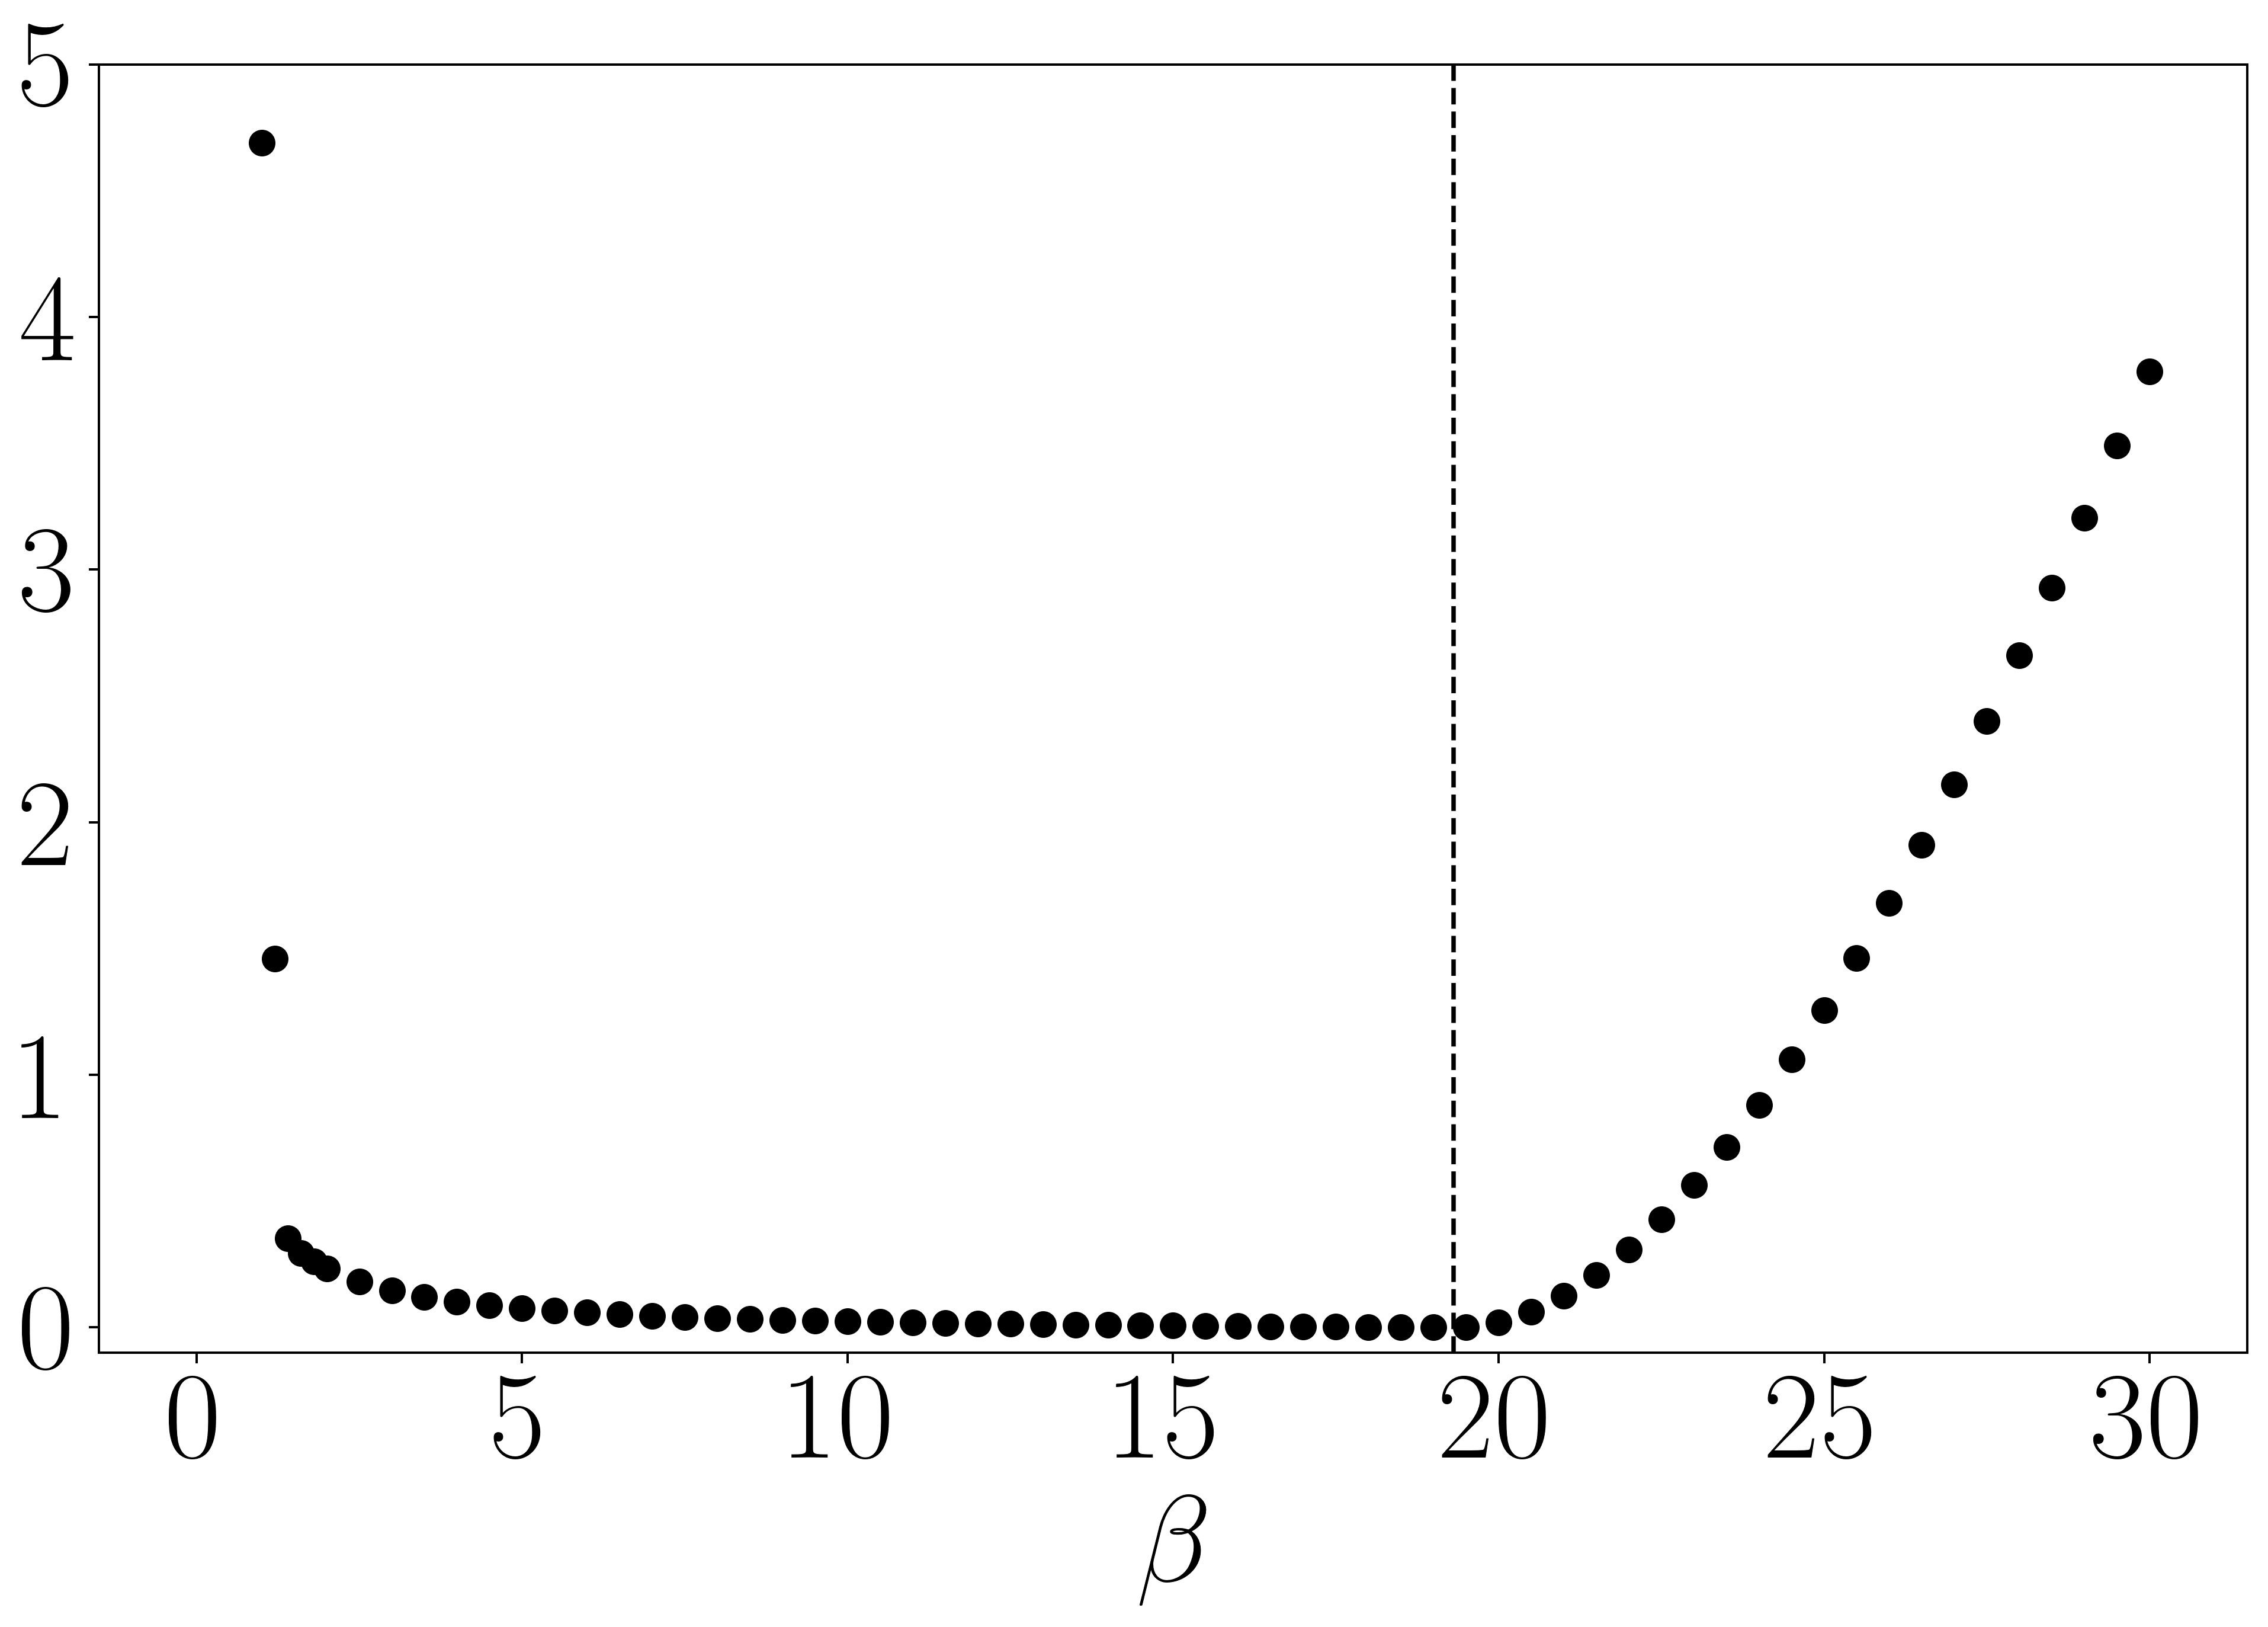

In [594]:
plt.figure(figsize=[13,8], dpi=360)
plt.plot(brange, [s['f']-alsominf -fr_ex(s['x']) for s in bprofile], 'o', color='k',markersize=8)
plt.axvline(float(getp(sols[idx]['x'])[0]), linestyle='--', color='k')
plt.ylim([-0.1, 5])
# plt.xlim([0.0001, 0.00025])
# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel('Relative Objective Function Value', font_properties=label_font)
plt.xlabel('$\\beta$', font_properties=pub_font2)
plt.xticks(font_properties=pub_font2)
plt.yticks(font_properties=pub_font2);


In [473]:
from scipy import optimize
findb = lambda x: np.interp(x, brange, [s['f']-alsominf -fr_ex(s['x']) for s in bprofile])
print(optimize.fsolve(lambda x: findb(x)-1.96, 1))
print(optimize.fsolve(lambda x: findb(x)-1.96, 30))
print(getp(sols[idx]['x'])[0])

[1.16904057]
[26.60441293]
19.3124


Text(0.5, 1.0, 'b/N by b')

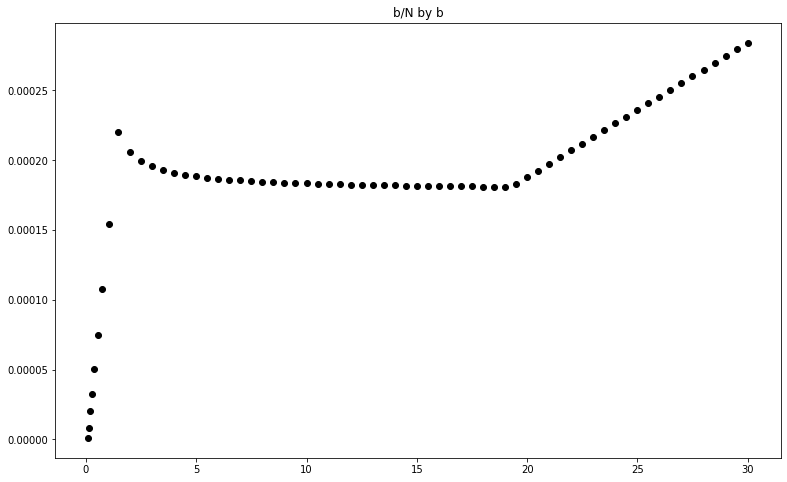

In [467]:
plt.figure(figsize=[13,8],)
N0 = lambda sol: sum(x[0] for x in getx(sol['x']))
plt.plot(brange,
        [b/N0(sol) for b, sol in zip(brange, bprofile)], 
#           [s['f']-alsominf -fr_ex(s['x']) for s in bprofile], 
         'o', color='k',)
# plt.axvline(float(getp(sols[idx]['x'])[0]), linestyle='--', color='k')
plt.title('b/N by b')

Text(0.5, 1.0, 'R0 by b')

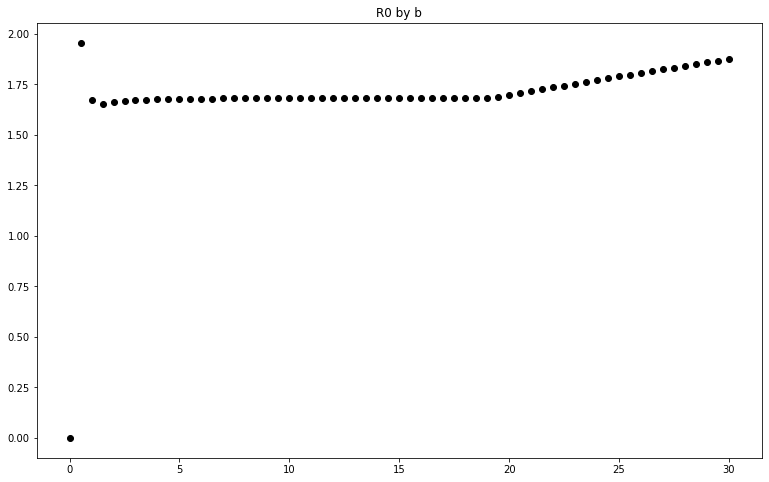

In [412]:
plt.figure(figsize=[13,8],)

plt.plot(brange,
        [r0(sol) for sol in bprofile], 
         'o', color='k',)
# plt.axvline(float(getp(sols[idx]['x'])[0]), linestyle='--', color='k')
plt.title('R0 by b')

In [45]:
def r0_err(lb, ub, idx=idx):
    _,_,e,_,a,m = getp(sols[idx]['x'])
    return np.abs(ub-lb)/(e+a+m)
print(r0_err(3, 18))
print(r0(sols[idx]))
print(f"This means that our estimate of $R_0$ is approximately {r0(sols[idx])} ($\pm$ {0.5*r0_err(2, 28)})${{}}_\\beta$")

26.3439
34.2457
This means that our estimate of $R_0$ is approximately 34.2457 ($\pm$ 22.8314)${}_\beta$


Text(0.5, 1.0, 'Parameter Estimate Error and Predictive Error')

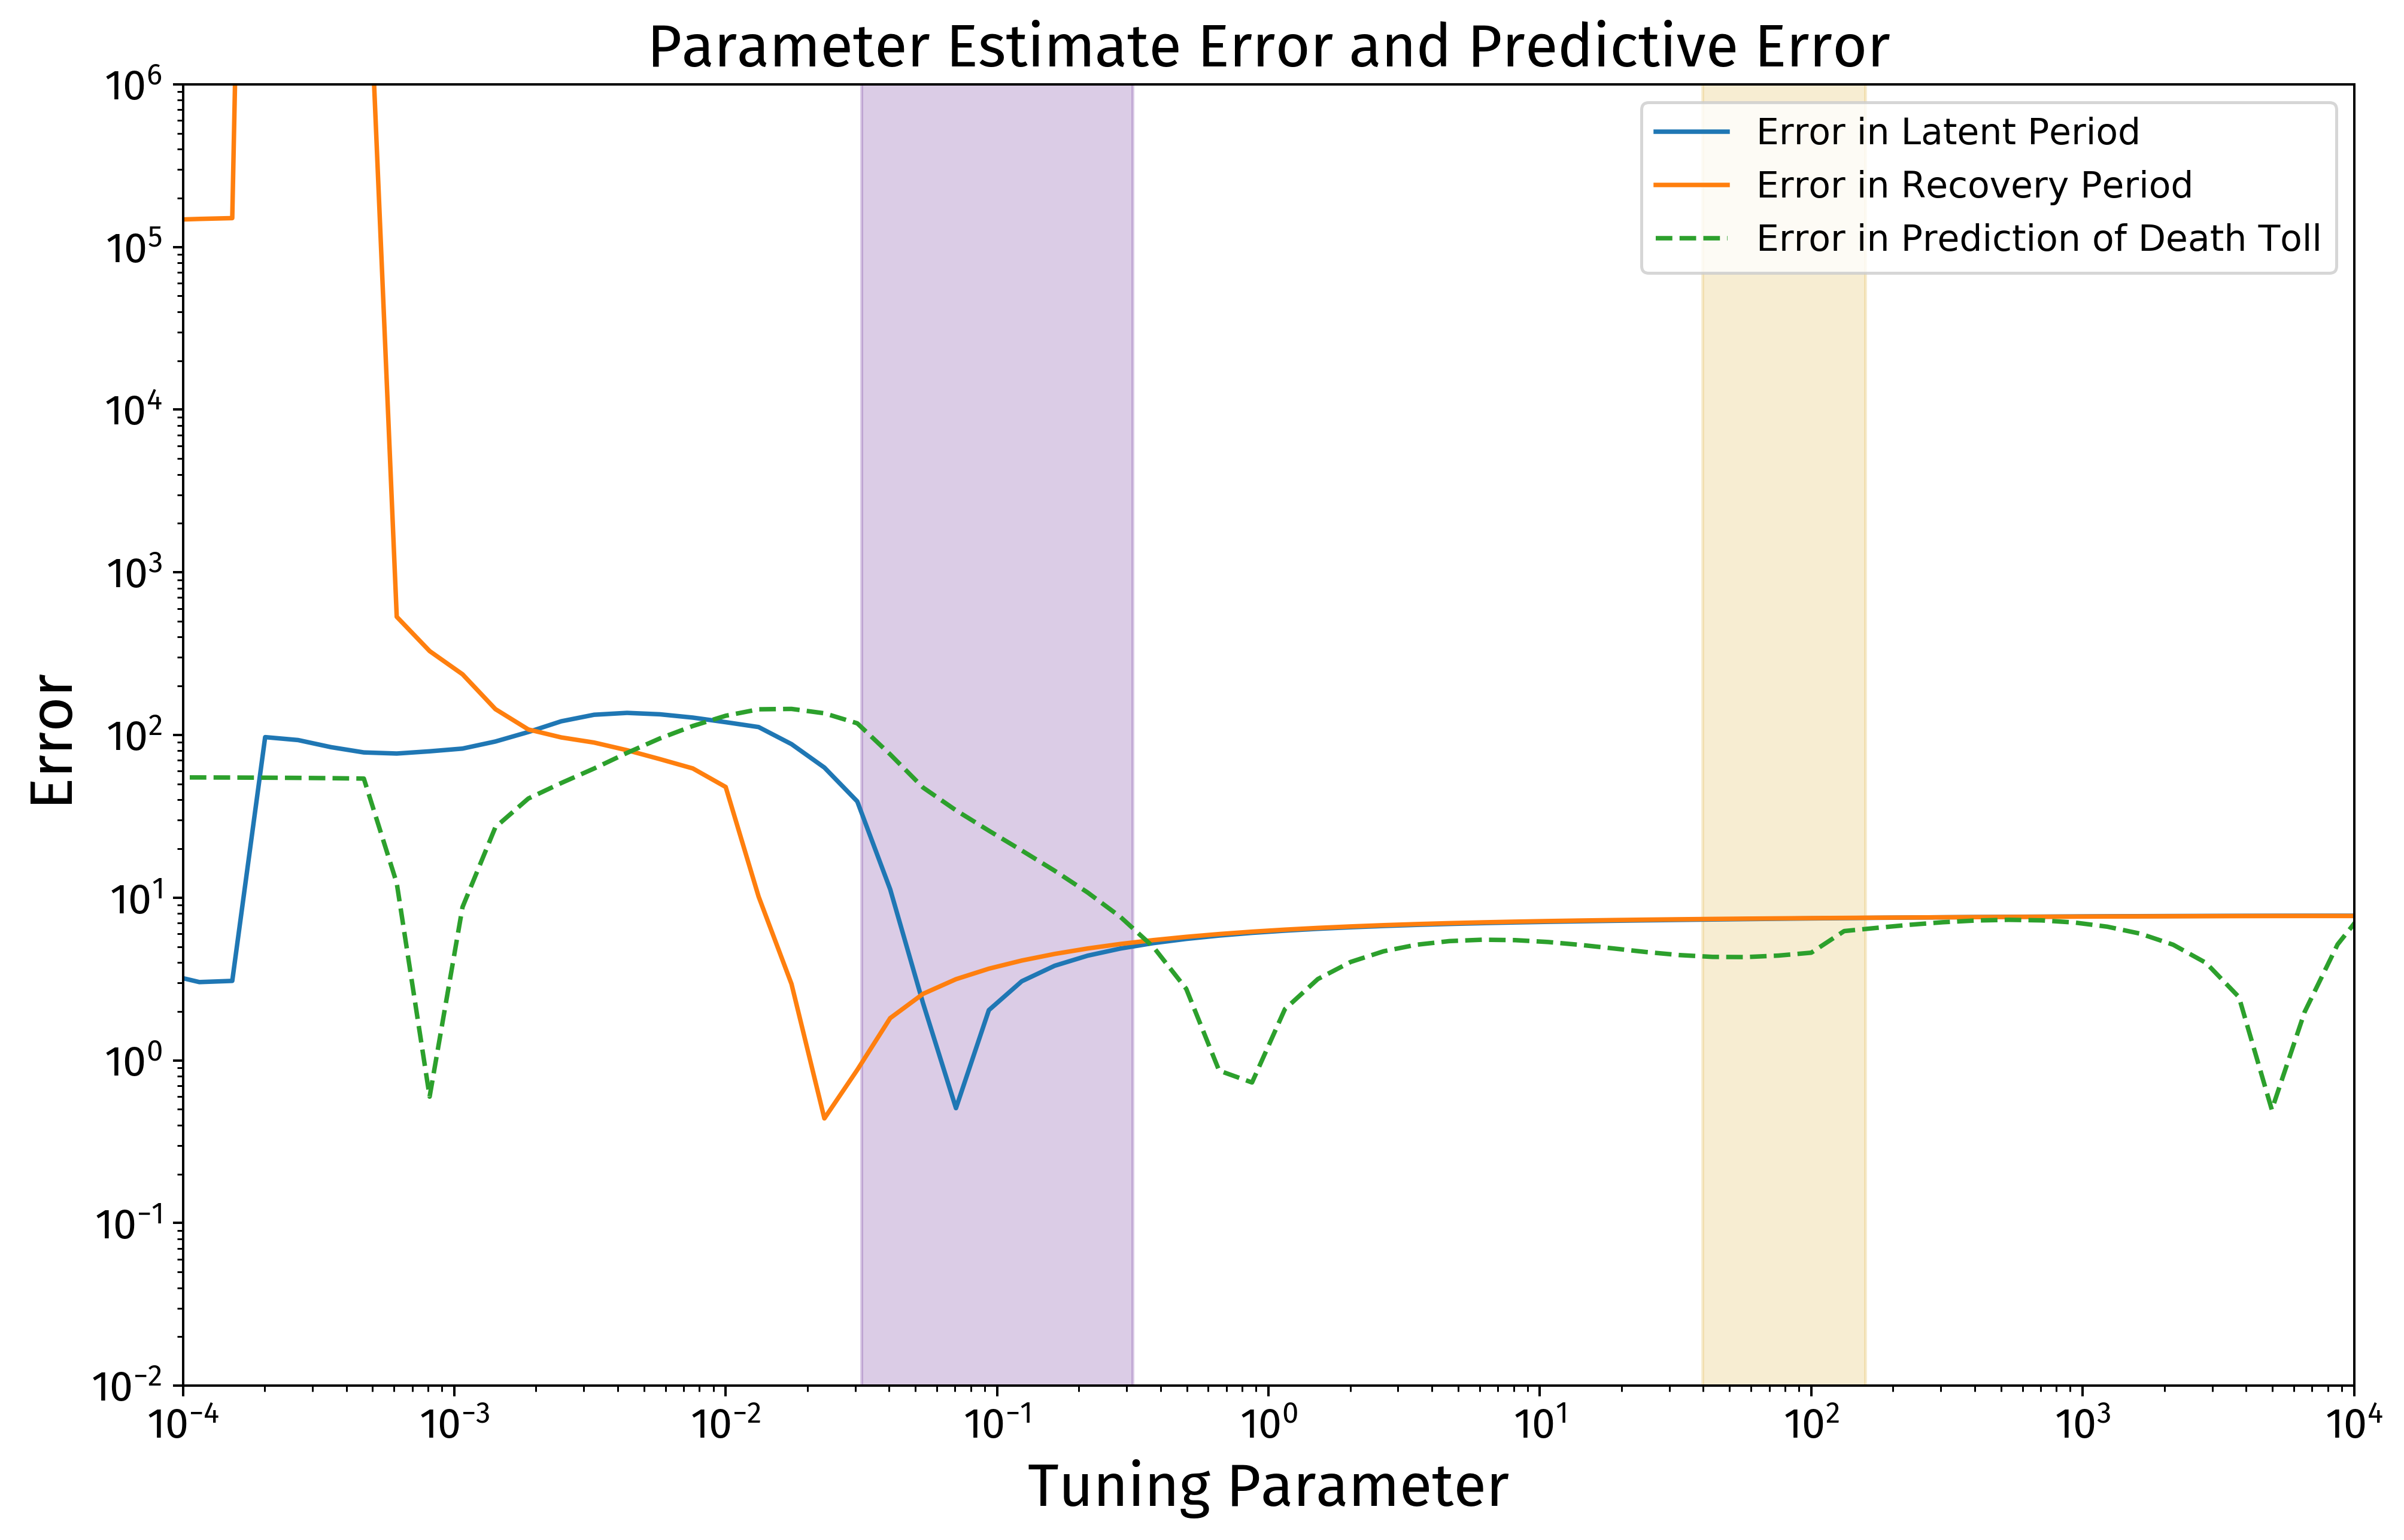

In [46]:
gamma_errs = [np.abs(1/(float(s['x'][-5])+1e-15) - 8) for s in sols]
alpha_errs = [np.abs(1/(float(s['x'][-2])+1e-15) - 8) for s in sols]

eerr = [np.abs(float(getx(s['x'])[-2][159]) - cE[-1]) for s in sols]
derr = [np.abs(float(getx(s['x'])[6][159]) - D[-1]) for s in sols]

plt.figure(figsize=[13,8], dpi=360)
plt.plot(prange, gamma_errs, '-', label="Error in Latent Period")
plt.plot(prange, alpha_errs, '-', label='Error in Recovery Period')
# plt.plot(prange, eerr)
plt.plot(prange, derr, '--', label="Error in Prediction of Death Toll")

plt.fill([10**-1.5, 10**-0.5, 10**-0.5, 10**-1.5],[0, 0, 10**7, 10**7], 
         alpha=0.2, color='indigo')
plt.fill([10**1.6, 10**2.2, 10**2.2, 10**1.6],[0, 0, 10**7, 10**7],
        alpha=0.2, color='goldenrod')

plt.legend(fontsize='large')
plt.ylim([0.01, 1e6])
plt.xlim([1e-4, 1e4])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Tuning Parameter', font_properties=label_font)
plt.ylabel('Error', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font)
plt.title("Parameter Estimate Error and Predictive Error", font_properties=label_font)



Text(3e-05, 8545.5, 'True Final Size')

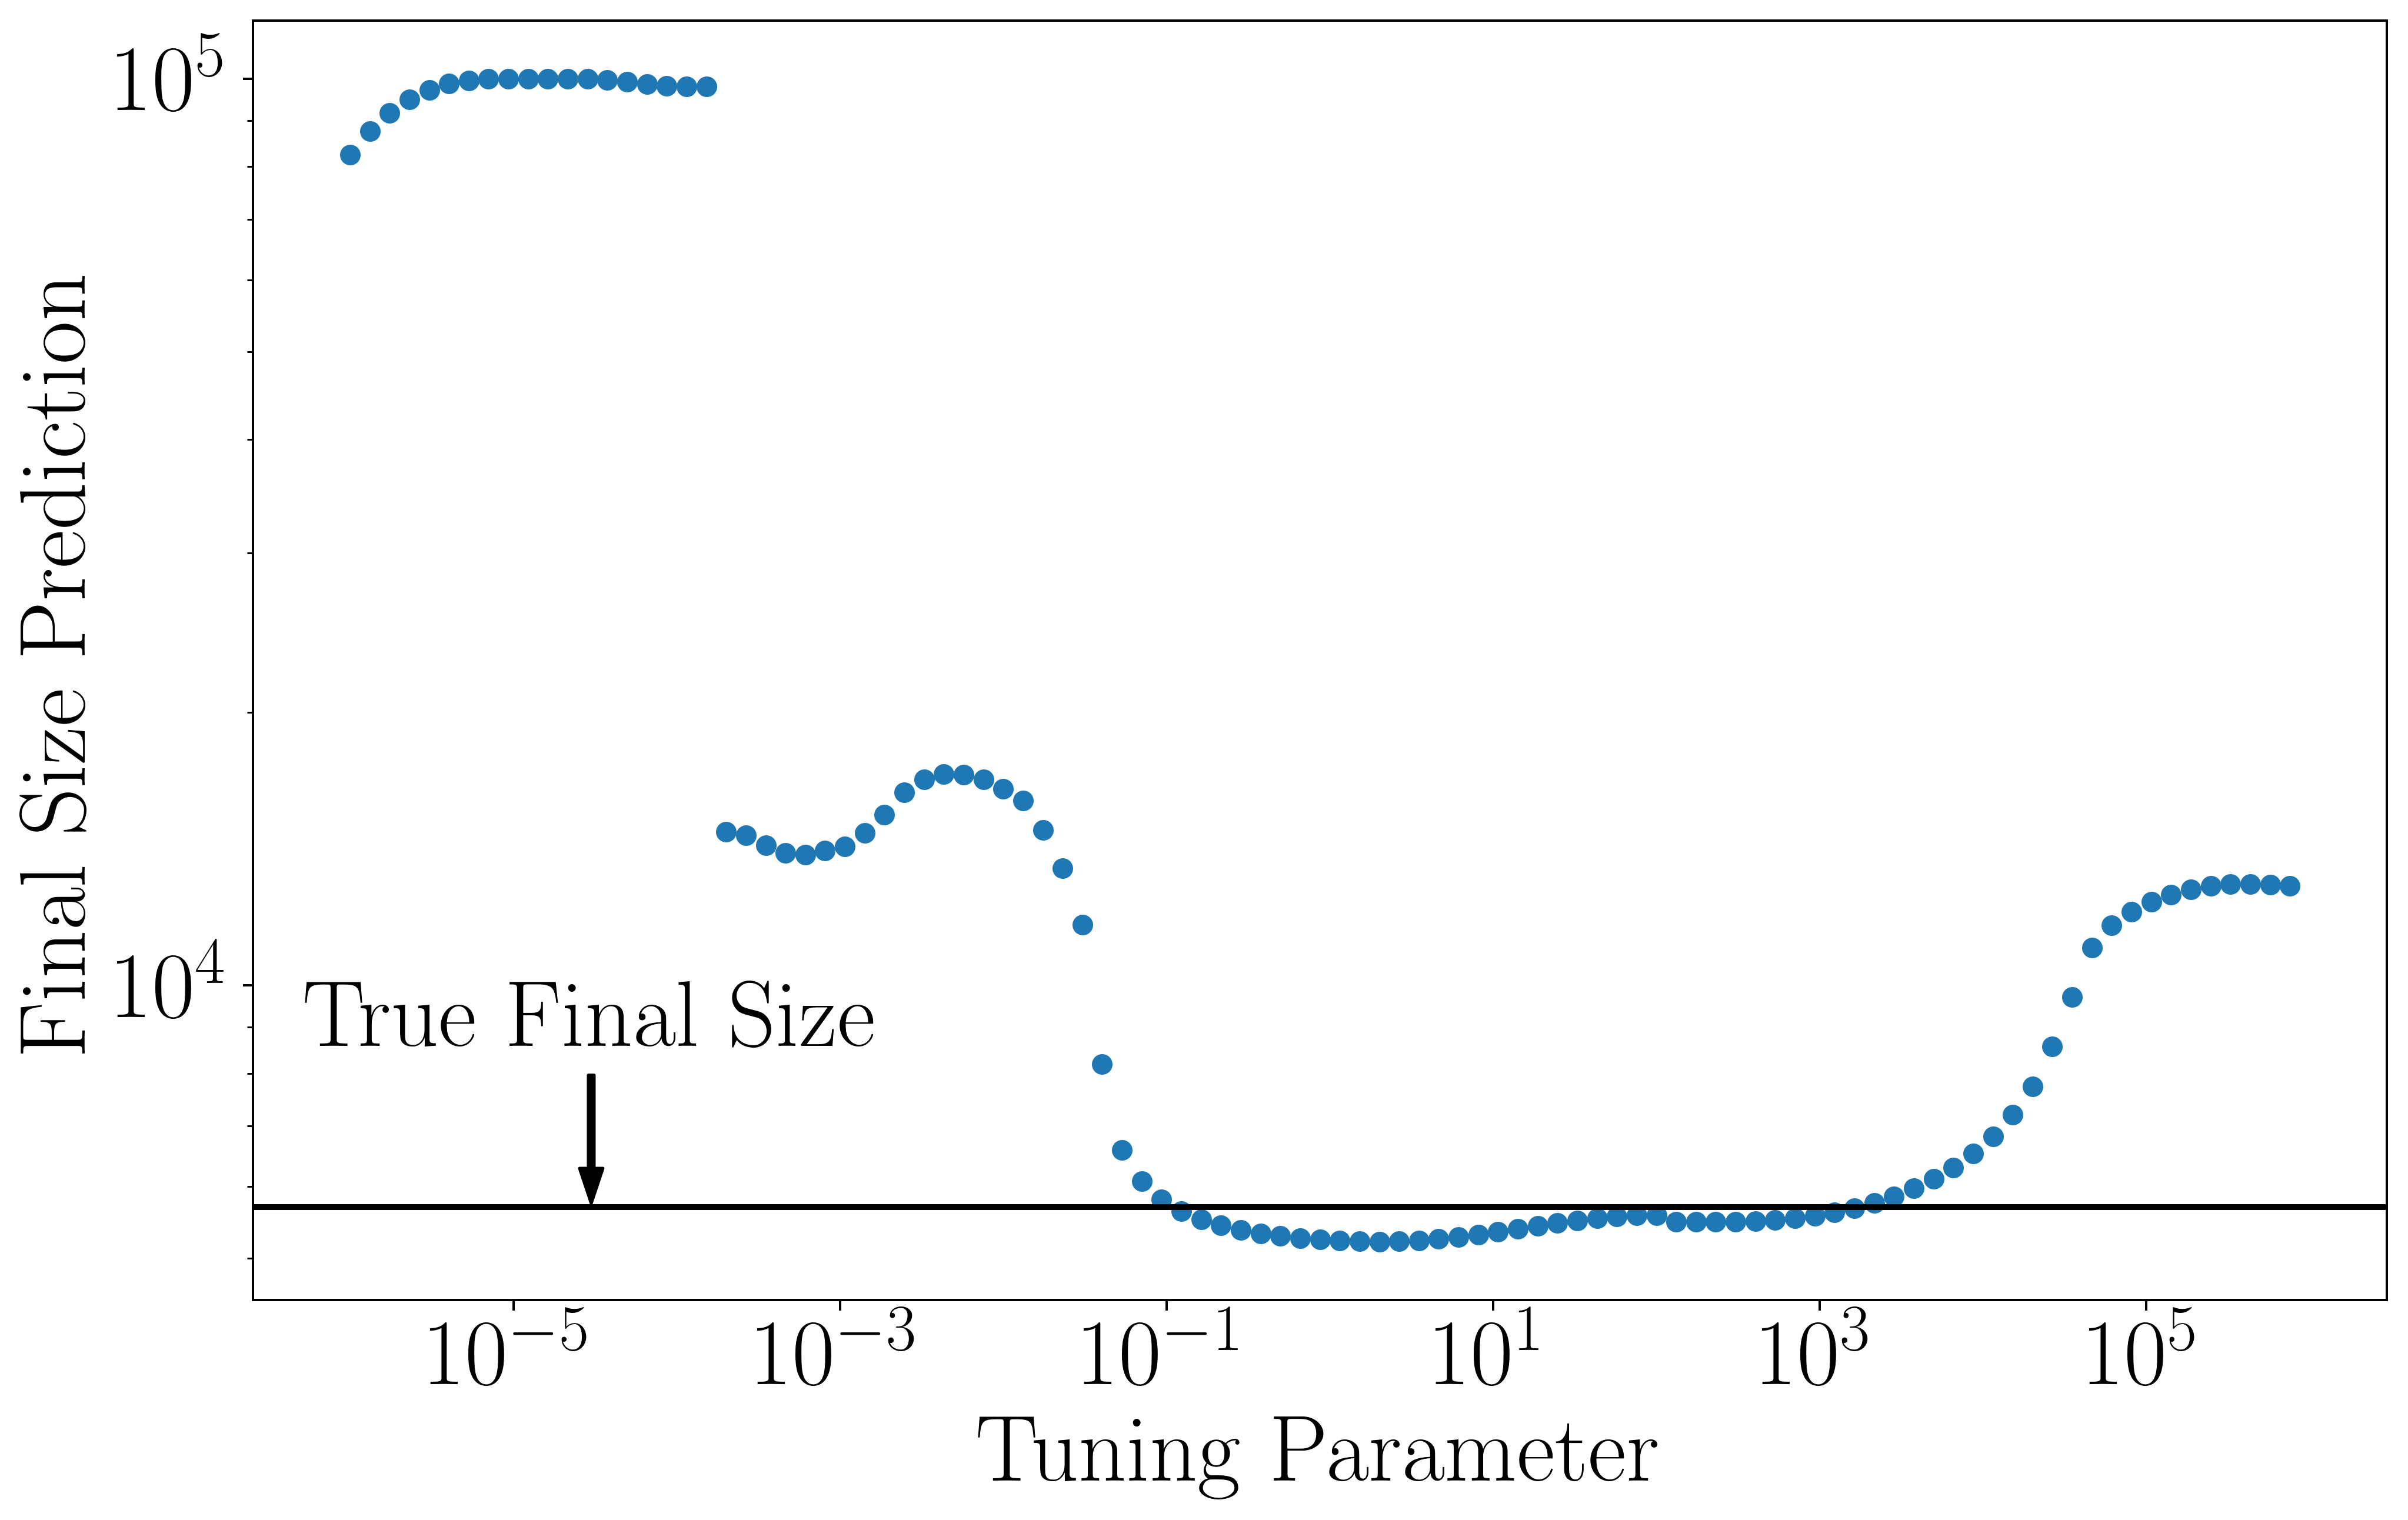

In [568]:
plt.figure(figsize=[13,8], dpi=360)
i0,i1 = (0, -1)
plt.plot(prange[i0:i1], [getx(sol['x'])[-2][-1] for sol in sols[i0:i1]],'o')
plt.xscale('log')

plt.axhline(cE[-1], color='k', linewidth=2)
plt.yscale('log')

# plt.title("Predicted Final Size by Tuning Parameter", font_properties=pub_font)
plt.xlabel("Tuning Parameter", font_properties=pub_font)
plt.ylabel("Final Size Prediction", font_properties=pub_font)
plt.xticks(font_properties=pub_font)
plt.yticks(font_properties=pub_font)
plt.annotate('True Final Size', xy=(3e-5, cE[-1]), xytext=(3e-5, cE[-1]*1.5),
             arrowprops=dict(facecolor='black', shrink=0.025, width=2, headwidth=8),
             horizontalalignment="center", font_properties=pub_font
            )

Text(0.001, 41.5, 'True Total Deaths')

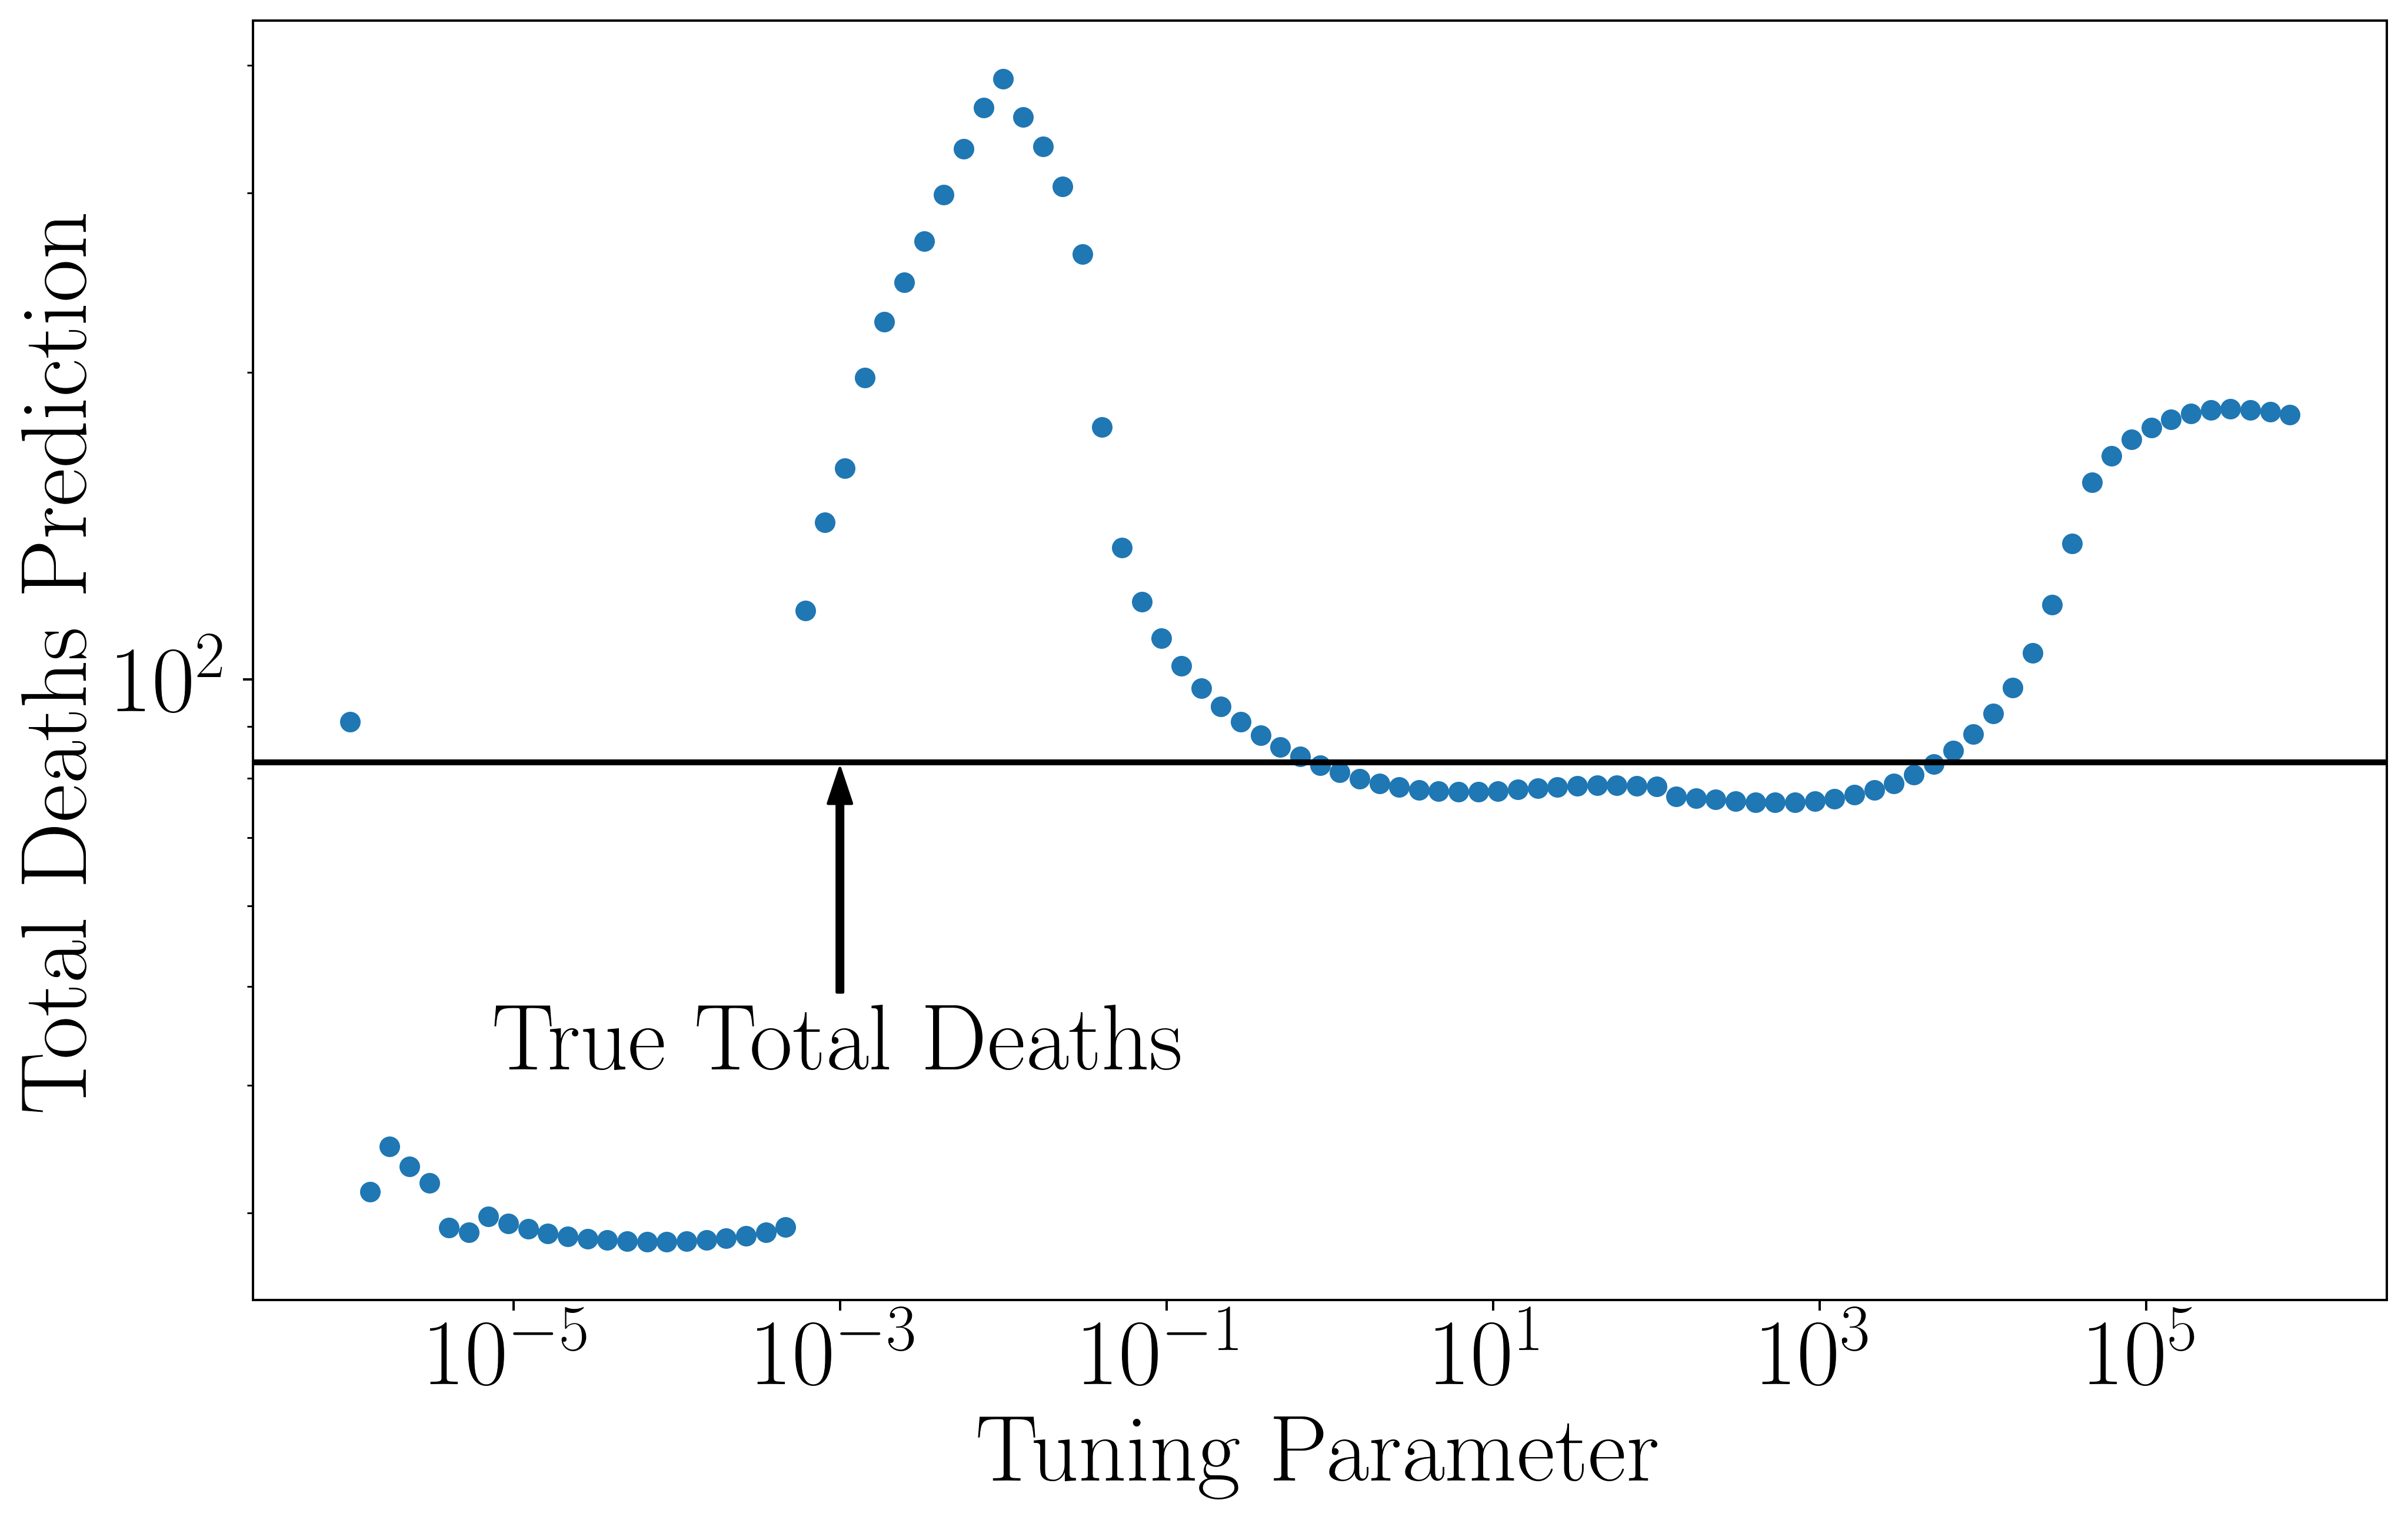

In [575]:
plt.figure(figsize=[13,8],dpi=360)
i0,i1 = (0, -1)
plt.plot(prange[i0:i1], [getx(sol['x'])[6][-1] for sol in sols[i0:i1]],'o')
plt.xscale('log')

plt.axhline(D[-1], color='k', linewidth=2)
plt.yscale('log')

# plt.title("Predicted Total Deaths by Tuning Parameter", font_properties=label_font)
plt.xlabel("Tuning Parameter", font_properties=pub_font)
plt.ylabel("Total Deaths Prediction", font_properties=pub_font)
plt.xticks(font_properties=pub_font)
plt.yticks(font_properties=pub_font)
plt.annotate('True Total Deaths', xy=(1e-3, D[-1]), xytext=(1e-3, D[-1]/2),
             arrowprops=dict(facecolor='black', shrink=0.025, width=2, headwidth=8),
             horizontalalignment="center", font_properties=pub_font
            )
# plt.plot(idx, getx(sols[idx]['x'])[6][-1], '*', markersize=10)

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 6 Text yticklabel objects>)

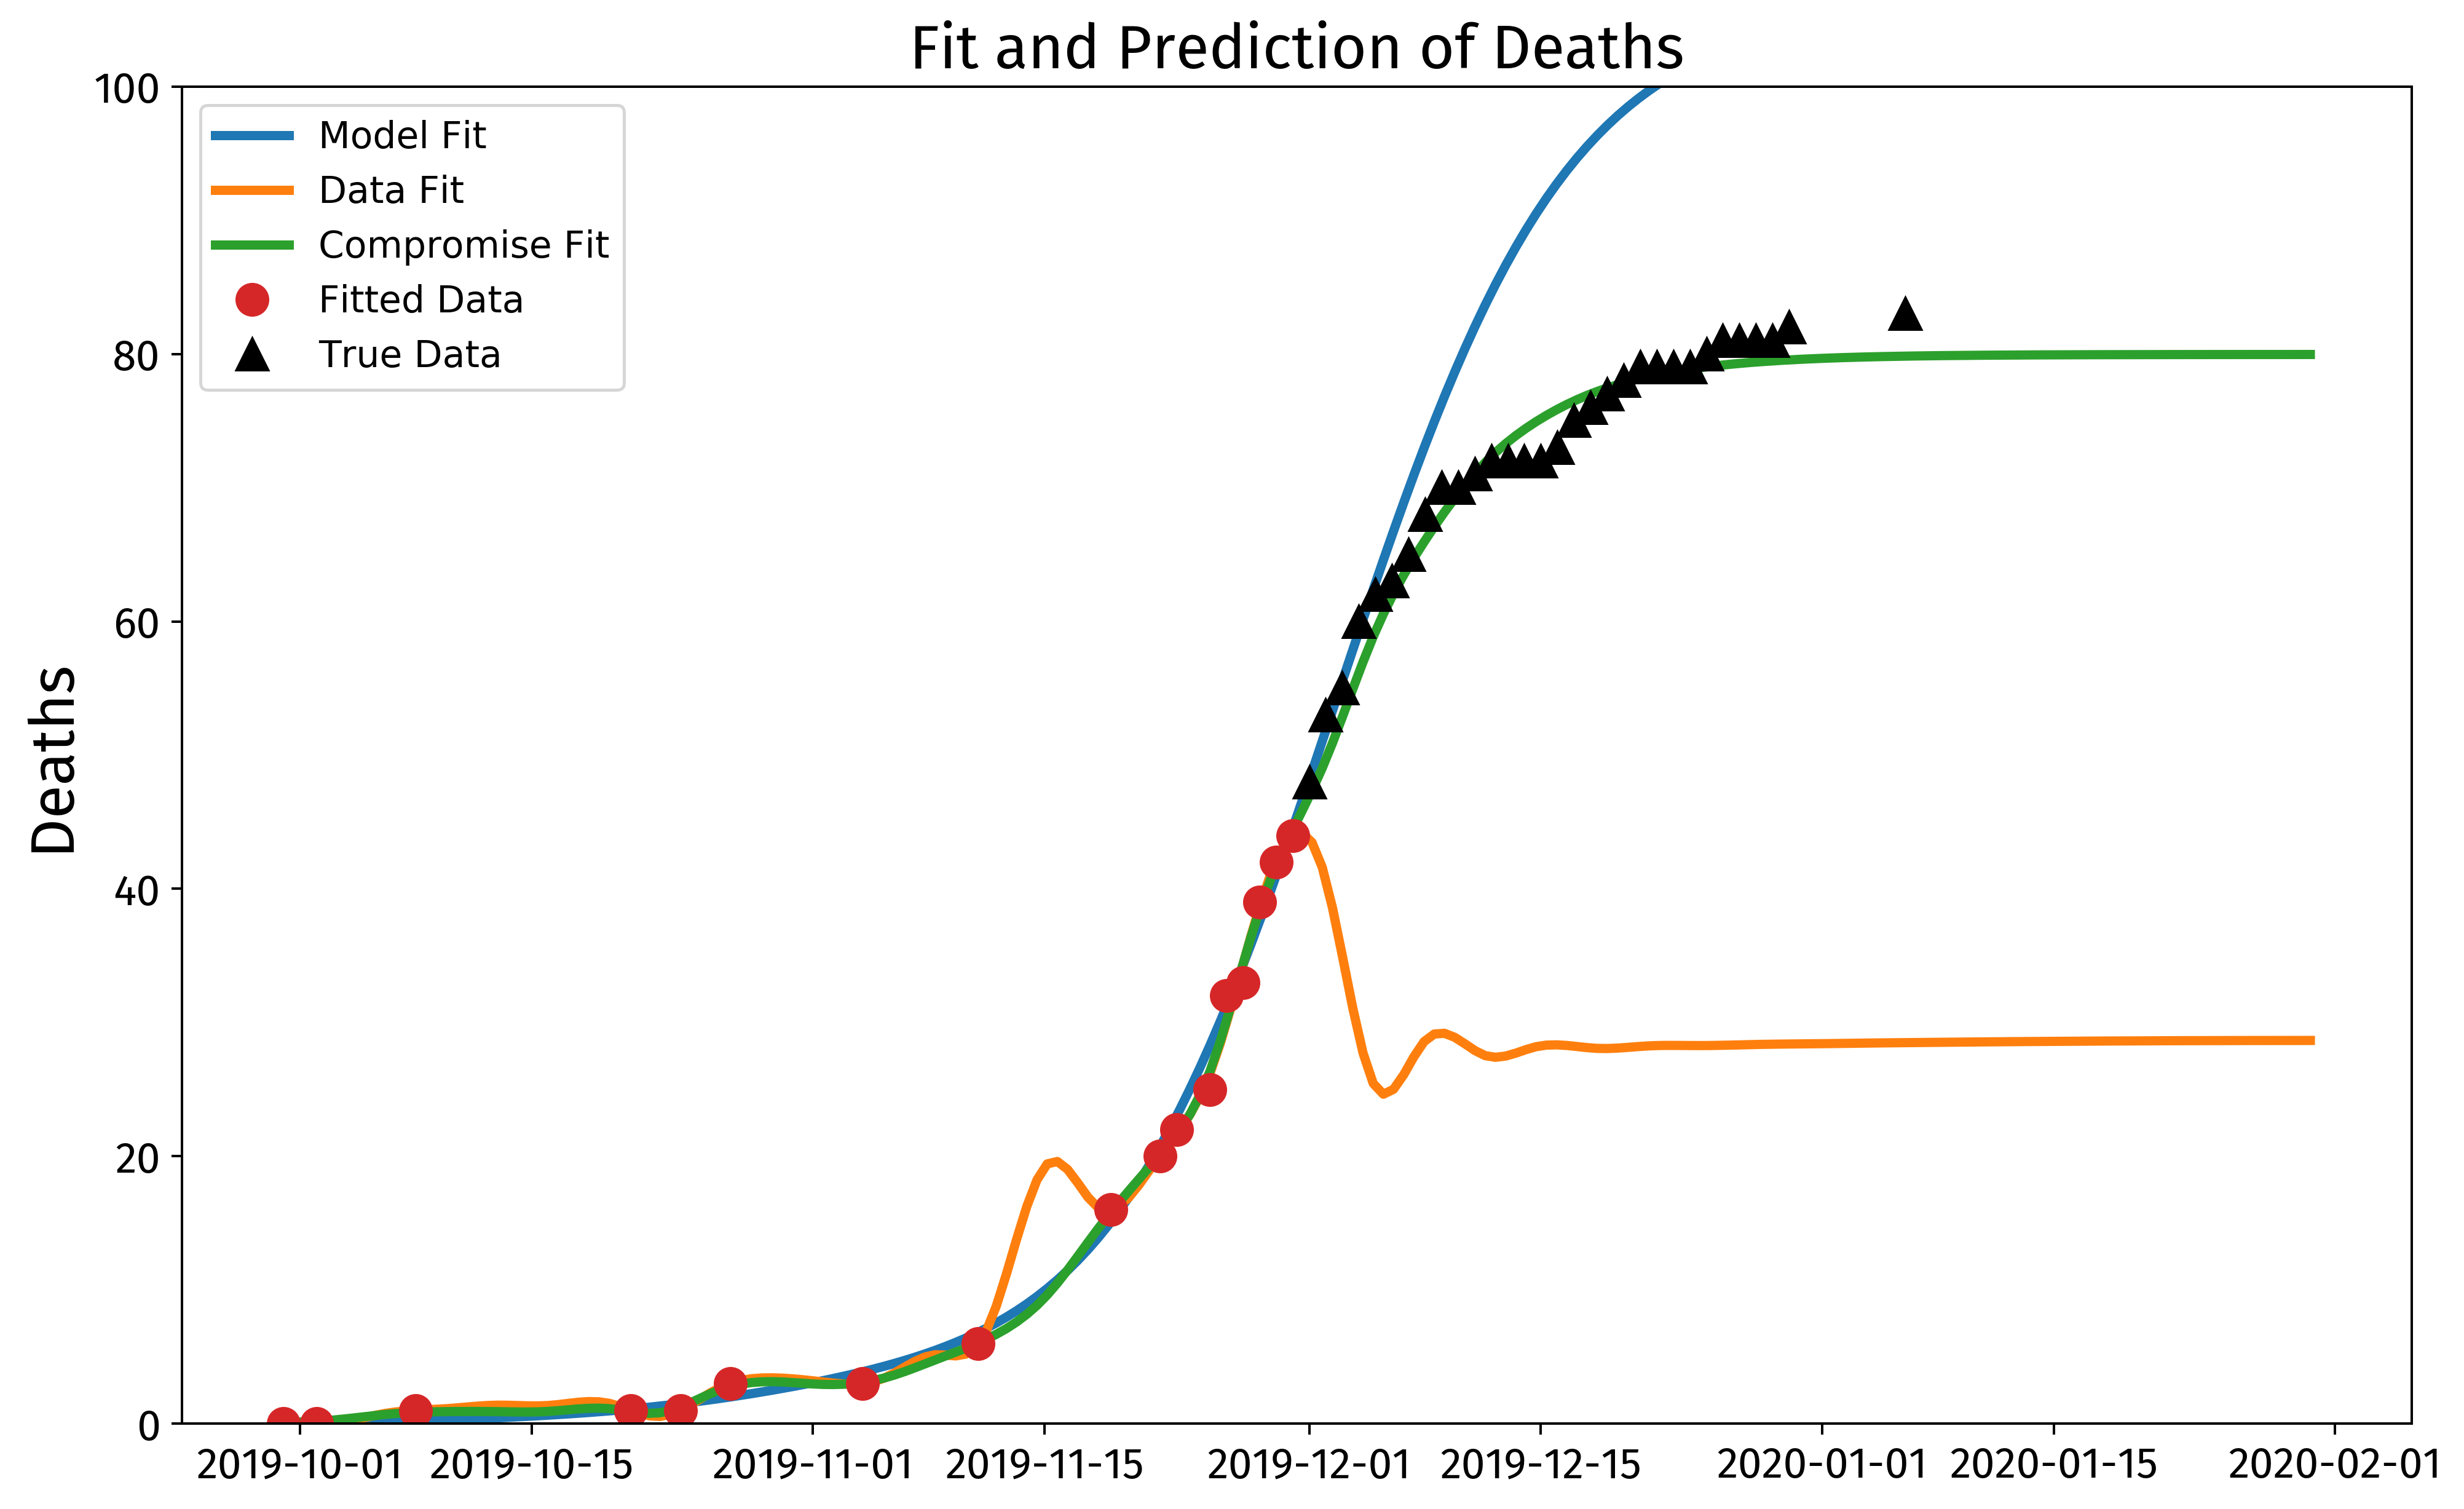

In [49]:
midx = -15
didx = 10
cidx = idx+5

plt.figure(figsize=[13,8], dpi=360)
for iidx in [midx, didx, cidx]:
    plt.plot(list(map(time_conv, model.observation_times)), getx(sols[iidx]['x'])[6], lw=3)
plt.plot(the_dates[start:clip], D[start:clip], 'o', markersize=10)
plt.plot(the_dates[clip:], D[clip:], 'k^', markersize=10)
plt.ylim([0, 100])
plt.title('Fit and Prediction of Deaths', font_properties=label_font)
plt.ylabel('Deaths', font_properties=label_font)
plt.legend(['Model Fit', 'Data Fit', 'Compromise Fit', 'Fitted Data', 'True Data'], fontsize='large')
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font)

Text(0.5, 1.0, 'L-Curve of Misfits')

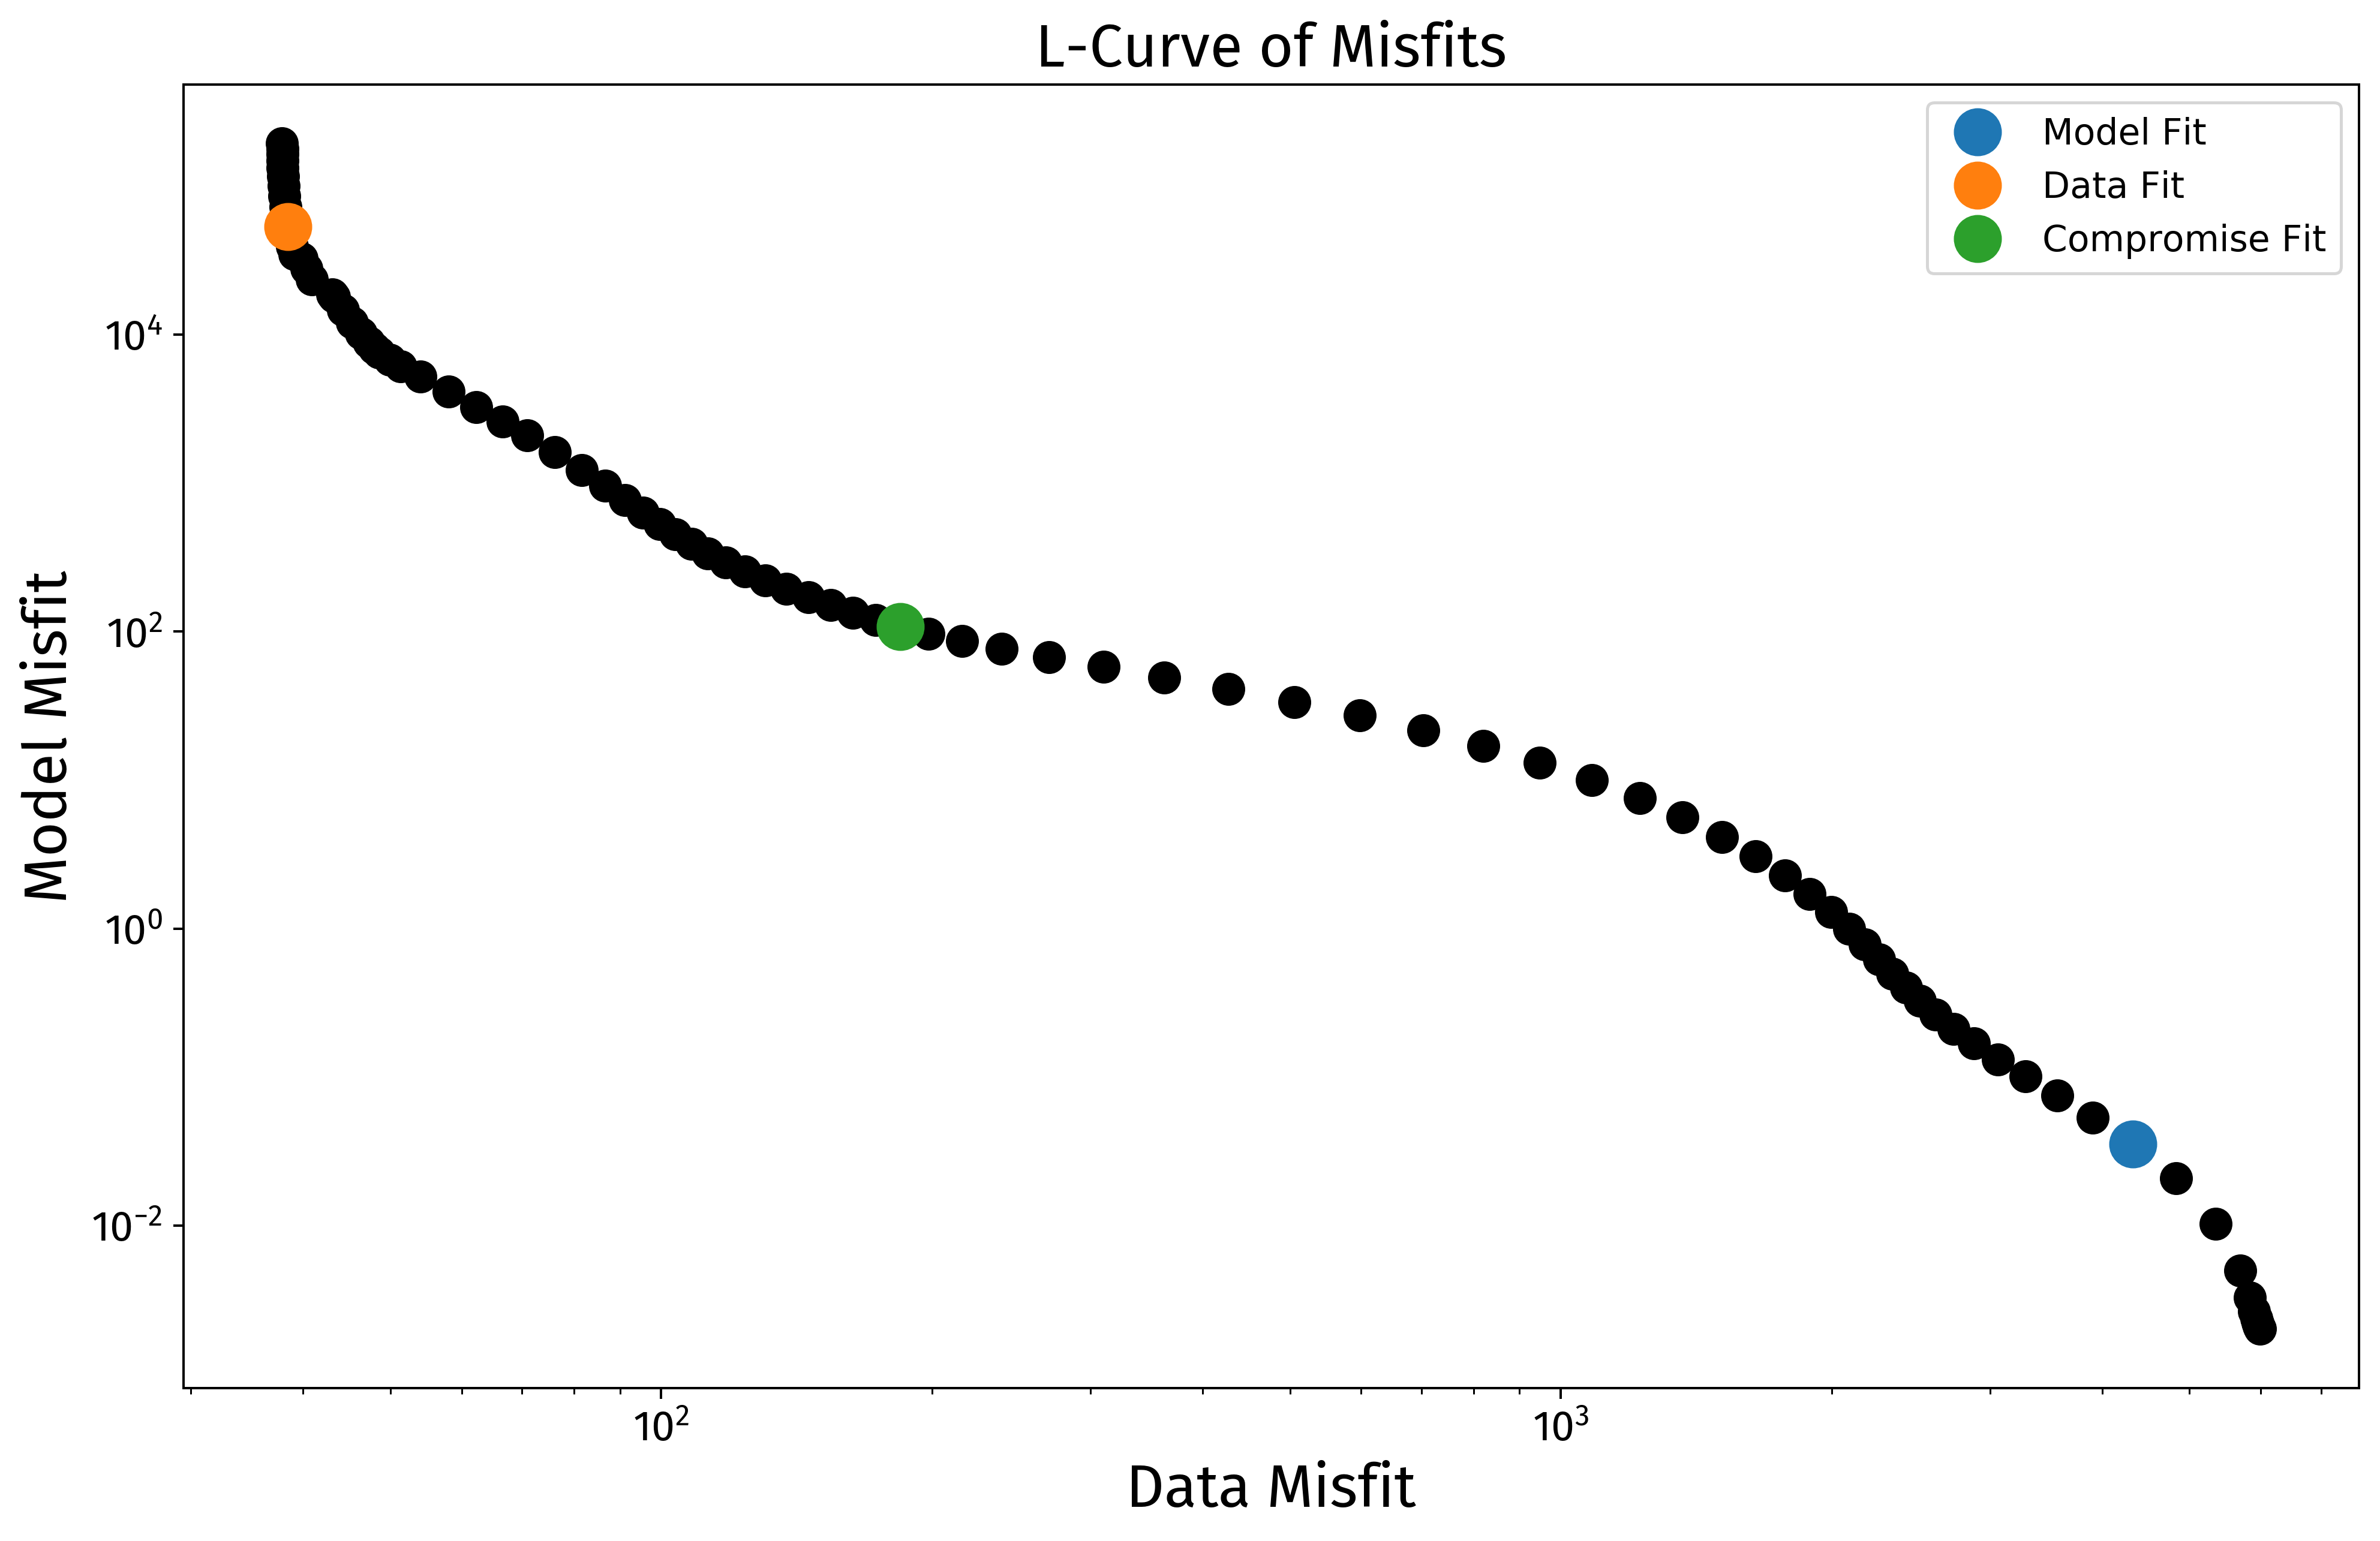

In [50]:
plt.figure(figsize=[13,8], dpi=360)
plt.loglog(*fsvals[:-5].T, 'ko', markersize=10)
for iidx, lbl in zip([midx, didx, cidx],[ 'Model Fit', 'Data Fit', 'Compromise Fit']) :
    plt.loglog(*fsvals[iidx], 'o', markersize=15, label=lbl)
plt.legend(fontsize='large')
plt.xlabel('Data Misfit', font_properties=label_font)
plt.ylabel('Model Misfit', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font)
plt.title('L-Curve of Misfits', font_properties=label_font)

(0, 0.1)

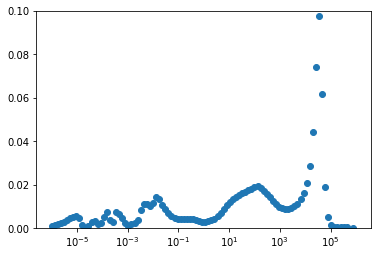

In [51]:
# L curve density
L = np.log10(fsvals)
Ld = [sum(z[0]**2) for z in zip(np.gradient(L, axis=0, edge_order=2))]
plt.semilogx(prange, Ld, 'o')
plt.ylim([0,0.1])

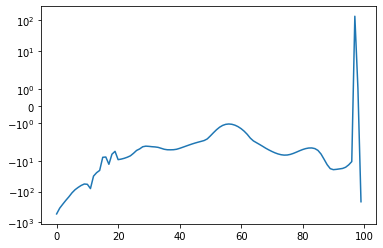

In [52]:
plt.plot([z[0][1]/z[0][0] for z in zip(np.gradient(L, axis=0, edge_order=2))])
plt.yscale('symlog', linthresh=1)

In [53]:
HESS, GRAD = ca.hessian(objective.objective, ca.vcat(model.ps))

detHESS = ca.det(HESS)
f_GRAD = ca.Function('fgrad', [solver_setup['x'], objective.rho, objective.alpha], [GRAD])
f_HESS = ca.Function('fhess', [solver_setup['x'], objective.rho, objective.alpha], [HESS])
f_detHESS = ca.Function('fdethess', [solver_setup['x'], objective.rho, objective.alpha], [detHESS])

In [54]:
print(ca.diag(f_HESS(sols[idx]['x'], prange[idx], alpha)))
f_HESS(sols[idx]['x'], prange[idx], alpha)

[24.5247, 100068, 53446.3, 11667.3, 13421.6, 26783.1]


DM(
[[24.5247, -624.102, 00, 00, 00, 00], 
 [-624.102, 100068, -20921.2, 00, -20921.2, -20921.2], 
 [00, -20921.2, 53446.3, -8467.34, 13361.6, 13361.6], 
 [00, 00, -8467.34, 11667.3, 00, 00], 
 [00, -20921.2, 13361.6, 00, 13421.6, 13361.6], 
 [00, -20921.2, 13361.6, 00, 13361.6, 26783.1]])

In [55]:
f_detHESS(sols[idx]['x'], prange[idx], alpha)

DM(9.07832e+22)

In [56]:
f_GRAD(sols[idx]['x'], prange[idx], alpha)

DM([5.5438e-11, 2.25646e-09, 5.62987e-09, 3.74206e-09, 2.28589e-09, 8.11117e-08])

In [414]:
# R0 profiling

r0profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat([ca.vcat(model.xs), r0(solver_setup)]),
}
r0profiler = ca.nlpsol('r0profiler', 'ipopt', r0profiler_setup, ipopt_opts)

In [434]:
pref = sols[idx]['x']
r0profile = []
r0range = np.linspace(1.4,2,num=51)
for ri in r0range:
    lbg = [0]*r0profiler_setup['g'].shape[0]
    ubg = [200000]*r0profiler_setup['g'].shape[0]
    lbg[-1] = ri
    ubg[-1] = ri
    r0solve_opts = {
        'x0': pref,
        'p': [prange[idx], alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg,
    }
    print(f'b={ri}')
    r0profile.append(r0profiler(**r0solve_opts))

b=1.4
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7305

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7305

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3421782e+02 2.36e-01 1.04e+00  -1.0 0.00e+00    -  0.00e+00 0.

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7305

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3421782e+02 1.76e-01 1.04e+00  -1.0 0.00e+00    -  0.00e+00 0.

  50  3.3500762e+02 9.33e-15 2.03e-10  -8.6 1.54e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:   3.3500762061689812e+02    3.3500762061689812e+02
Dual infeasibility......:   2.0259050988346206e-10    2.0259050988346206e-10
Constraint violation....:   9.3258734068513149e-15    9.3258734068513149e-15
Complementarity.........:   2.5366252574068861e-09    2.5366252574068861e-09
Overall NLP error.......:   2.5366252574068861e-09    2.5366252574068861e-09


Number of objective function evaluations             = 95
Number of objective gradient evaluations             = 51
Number of equality constraint evaluations            = 95
Number of inequality constraint evaluations          = 95
Number of equality constraint Jacobian evaluations   = 51
Number of inequality constraint Jacobian evaluations = 51
Number of Lagrangian Hessian evaluations             = 50
Total CPU secs in IPOPT 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7305

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3421782e+02 7.98e-02 1.04e+00  -1.0 0.00e+00    -  0.00e+00 0.

  50  3.3429368e+02 5.64e-06 1.29e-01  -8.6 2.28e+02    -  1.00e+00 5.29e-01h  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:   3.3429370667244461e+02    3.3429370667244461e+02
Dual infeasibility......:   3.1945586109465060e-09    3.1945586109465060e-09
Constraint violation....:   1.4677148385544569e-13    1.4677148385544569e-13
Complementarity.........:   3.7592729910914684e-09    3.7592729910914684e-09
Overall NLP error.......:   3.7592729910914684e-09    3.7592729910914684e-09


Number of objective function evaluations             = 122
Number of objective gradient evaluations             = 55
Number of equality constraint evaluations            = 122
Number of inequality constraint evaluations          = 122
Number of equality constraint Jacobian evaluations   = 55
Number of inequality constraint Jacobian evaluations = 55
Number of Lagrangian Hessian evaluations             = 54
Total CPU secs in IPO


Number of Iterations....: 128

                                   (scaled)                 (unscaled)
Objective...............:   3.3420558941136346e+02    3.3420558941136346e+02
Dual infeasibility......:   8.0089856834280348e-09    8.0089856834280348e-09
Constraint violation....:   2.5668356329333619e-13    2.5668356329333619e-13
Complementarity.........:   2.5991248351253395e-09    2.5991248351253395e-09
Overall NLP error.......:   8.0089856834280348e-09    8.0089856834280348e-09


Number of objective function evaluations             = 275
Number of objective gradient evaluations             = 129
Number of equality constraint evaluations            = 275
Number of inequality constraint evaluations          = 275
Number of equality constraint Jacobian evaluations   = 129
Number of inequality constraint Jacobian evaluations = 129
Number of Lagrangian Hessian evaluations             = 128
Total CPU secs in IPOPT (w/o function evaluations)   =      0.996
Total CPU secs in NLP function 

 100  3.8030422e+02 1.23e-04 2.56e+03  -1.7 9.03e+02  -7.7 1.00e+00 1.00e+00H  1
 150  3.3427277e+02 5.25e-04 5.07e+00  -5.7 5.35e+04    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 170

                                   (scaled)                 (unscaled)
Objective...............:   3.3426782651277426e+02    3.3426782651277426e+02
Dual infeasibility......:   4.4410301080678304e-09    4.4410301080678304e-09
Constraint violation....:   1.1213252548714081e-13    1.1213252548714081e-13
Complementarity.........:   2.4802330197150574e-09    2.4802330197150574e-09
Overall NLP error.......:   4.4410301080678304e-09    4.4410301080678304e-09


Number of objective function evaluations             = 401
Number of objective gradient evaluations             = 171
Number of equality constraint evaluations            = 401
Number of inequality constraint evaluations          = 401
Number of equality constraint Jacobian evaluations   = 171
Number of inequality constraint Jacobian evaluations 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3421782e+02 7.62e-02 1.04e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  3.6199123e+02 4.11e-07 1.99e+01  -1.7 6.44e+00  -4.0 1.00e+00 1.00e+00f  1
 100  3.3443190e+02 1.66e-03 2.05e+01  -5.7 4.81e+04    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 113

                                   (scaled)                 (unscaled)
Objective...............:   3.3442669961830796e+02    3.3442669961830796e+02
Dual infeasibility......:   2.4835154038645369e-09    2.4835154038645369e-09
Constraint violation....:   3.8413716652030416e-14    3.8413716652030416e-14
Complementarity.........:   2.3638608163608384e-09    2.3638608163608384e-09
Overall NLP error.......:   2.4835154038645369e-09    2.4835154038645369e-09


Number of objective function evaluations             = 261
Number of objective gradient evaluations             = 114
Number of equality constraint evaluations            = 261
Number of


Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............:   3.3467118317407500e+02    3.3467118317407500e+02
Dual infeasibility......:   1.3645200954852228e-09    1.3645200954852228e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.2525674558718390e-09    2.2525674558718390e-09
Overall NLP error.......:   2.2525674558718390e-09    2.2525674558718390e-09


Number of objective function evaluations             = 153
Number of objective gradient evaluations             = 75
Number of equality constraint evaluations            = 153
Number of inequality constraint evaluations          = 153
Number of equality constraint Jacobian evaluations   = 75
Number of inequality constraint Jacobian evaluations = 75
Number of Lagrangian Hessian evaluations             = 74
Total CPU secs in IPOPT (w/o function evaluations)   =      0.521
Total CPU secs in NLP function evalu

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7305

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3421782e+02 1.60e-01 1.04e+00  -1.0 0.00e+00    -  0.00e+00 0.


Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   3.3566708960587079e+02    3.3566708960587079e+02
Dual infeasibility......:   3.6062590340877052e-10    3.6062590340877052e-10
Constraint violation....:   3.2196467714129540e-14    3.2196467714129540e-14
Complementarity.........:   1.9927132278543129e-09    1.9927132278543129e-09
Overall NLP error.......:   1.9927132278543129e-09    1.9927132278543129e-09


Number of objective function evaluations             = 55
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 55
Number of inequality constraint evaluations          = 55
Number of equality constraint Jacobian evaluations   = 37
Number of inequality constraint Jacobian evaluations = 37
Number of Lagrangian Hessian evaluations             = 36
Total CPU secs in IPOPT (w/o function evaluations)   =      0.219
Total CPU secs in NLP function evaluati

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7305

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3421782e+02 2.68e-01 1.04e+00  -1.0 0.00e+00    -  0.00e+00 0.

Overall NLP error.......:   1.7839360428400925e-09    1.7839360428400925e-09


Number of objective function evaluations             = 185
Number of objective gradient evaluations             = 76
Number of equality constraint evaluations            = 185
Number of inequality constraint evaluations          = 185
Number of equality constraint Jacobian evaluations   = 76
Number of inequality constraint Jacobian evaluations = 76
Number of Lagrangian Hessian evaluations             = 75
Total CPU secs in IPOPT (w/o function evaluations)   =      0.513
Total CPU secs in NLP function evaluations           =      0.128

EXIT: Optimal Solution Found.
  r0profiler  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  13.95ms ( 75.42us)  13.97ms ( 75.50us)       185
       nlp_g  |   6.50ms ( 35.11us)   6.50ms ( 35.11us)       185
    nlp_grad  | 196.00us (196.00us) 195.09us (195.09us)         1
  nlp_grad_f  |  12.87ms (167.14us)  12.85ms (166.85us)        77
  nlp_hess_l  |  94

In [435]:
r0alsominf = min([s['f']-fr_ex(s['x']) for s in r0profile])

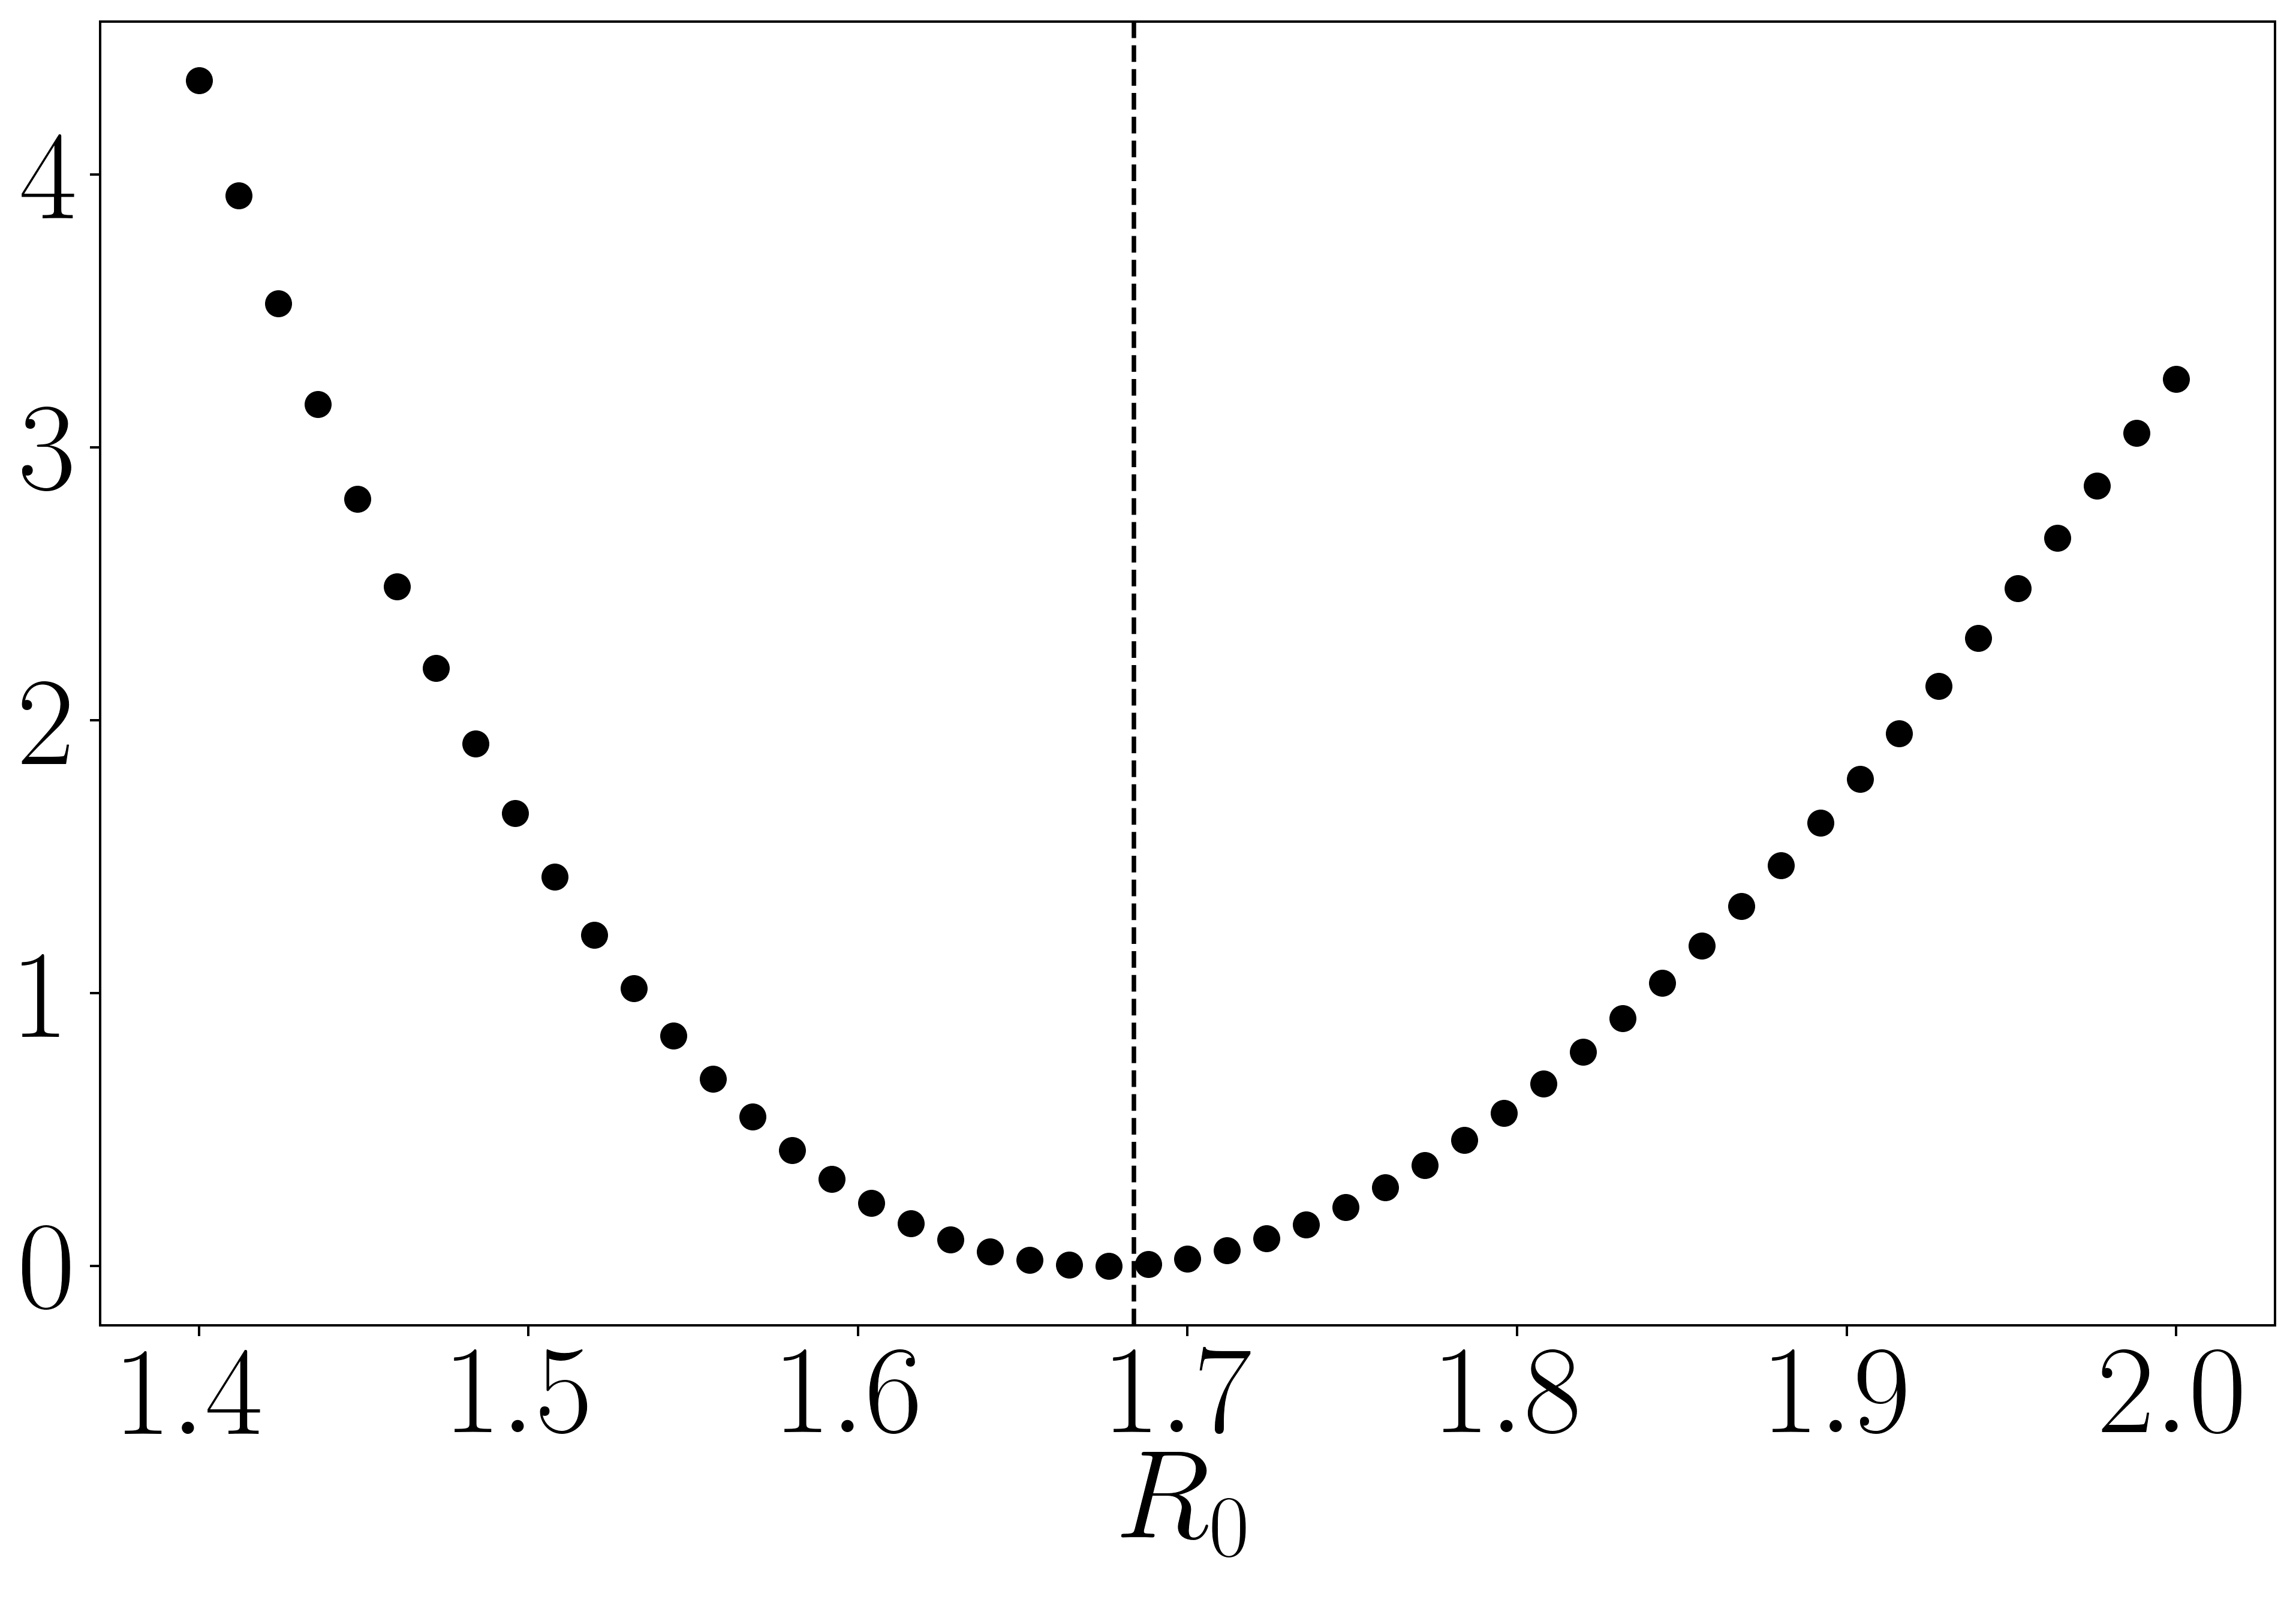

In [596]:
plt.figure(figsize=[13,8], dpi=360)
plt.plot(r0range, [s['f']-r0alsominf -fr_ex(s['x']) for s in r0profile], 'o', color='k',markersize=8)
plt.axvline(float(r0(sols[idx])), linestyle='--', color='k')
# plt.ylim([-0.1, 2])
# plt.xlim([0.0001, 0.00025])
# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel('Relative Objective Function Value', font_properties=label_font)
plt.xlabel('$R_0$', font_properties=pub_font2)
plt.xticks(font_properties=pub_font2)
plt.yticks(font_properties=pub_font2);

In [482]:
r0pfn = lambda x: np.interp(x, r0range, [s['f']-r0alsominf -fr_ex(s['x']) for s in r0profile])
print(optimize.fsolve(lambda x: r0pfn(x)-1.96, 1.5))
print(optimize.fsolve(lambda x: r0pfn(x)-1.96, 1.9))

[1.48207178]
[1.91649259]


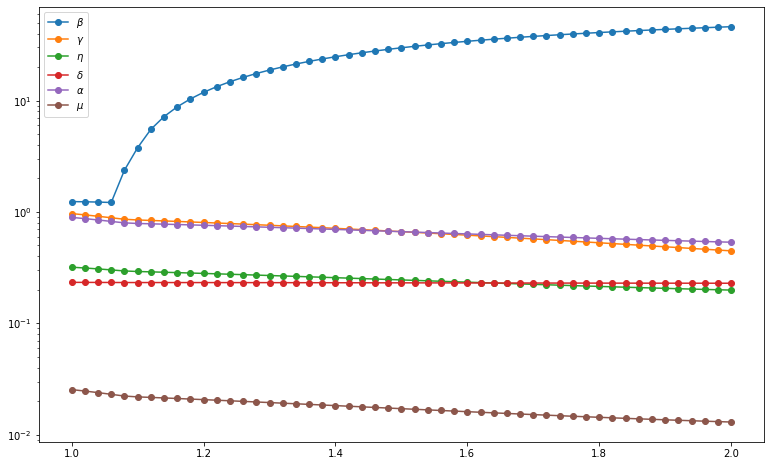

In [432]:
plt.figure(figsize=[13,8])
plt.plot(r0range, [float(s['x'][-6]) for s in r0profile], 'o-', label=r'$\beta$')
plt.plot(r0range, [float(s['x'][-5]) for s in r0profile], 'o-', label=r'$\gamma$')
plt.plot(r0range, [float(s['x'][-4]) for s in r0profile], 'o-', label=r'$\eta$')
plt.plot(r0range, [float(s['x'][-3]) for s in r0profile], 'o-', label=r'$\delta$')
plt.plot(r0range, [float(s['x'][-2]) for s in r0profile], 'o-', label=r'$\alpha$')
plt.plot(r0range, [float(s['x'][-1]) for s in r0profile], 'o-', label=r'$\mu$')
# plt.xscale('log')
plt.yscale('log')
plt.legend()

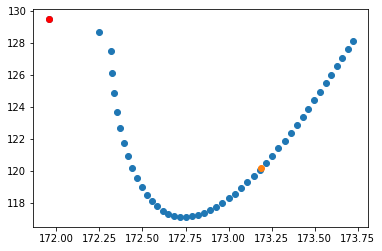

In [433]:
plt.plot(*np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in r0profile[3:]]).T, 'o')
plt.plot(f1_ex(r0profile[3]['x']), f2_ex(r0profile[3]['x']), 'ro')
plt.plot(f1_ex(sols[idx]['x']), f2_ex(sols[idx]['x']), 'o')


In [171]:
bNfn = lambda sol: getp(sol['x'])[0]/N0(sol)
bN_ref = bNfn(sols[idx])

In [173]:
bNprofiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat([ca.vcat(model.xs), model.ps[0]/sum(x[0] for x in model.xs)]),
}
bNprofiler = ca.nlpsol('bNprofiler', 'ipopt', bNprofiler_setup, ipopt_opts)

In [484]:
bNprofile = []
bNrange = np.linspace(0.0001,0.00035,num=61)
lbg = [0]*bNprofiler_setup['g'].shape[0]
ubg = [200000]*bNprofiler_setup['g'].shape[0]
for bi in bNrange:
    lbg[-1] = bi
    ubg[-1] = bi
    bNsolve_opts = {
        'x0': pref,
        'p': [prange[idx], alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg,
    }
    print(f'b={bi}')
    bNprofile.append(bNprofiler(**bNsolve_opts))

b=0.0001
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7285

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  

 100  4.4111850e+02 0.00e+00 1.87e+03  -1.0 9.06e+02  -8.5 1.00e+00 2.50e-01f  3
 150  4.5694523e+02 0.00e+00 9.44e+03  -1.0 1.70e+03  -8.0 1.00e+00 2.50e-01f  3
 200  4.6171855e+02 2.71e-20 4.51e+04  -1.0 4.04e+04    -  7.83e-01 3.12e-02f  6
 250  4.4965961e+02 2.71e-20 2.75e+04  -1.7 1.19e+03  -9.0 1.00e+00 1.00e+00f  1
 300  4.4574671e+02 2.71e-20 2.68e+04  -1.7 1.20e+05    -  6.41e-01 1.15e-02f  7
 350  4.4584007e+02 1.36e-20 1.54e+03  -1.7 1.08e+02  -9.1 1.00e+00 1.00e+00f  1
 400  4.4347360e+02 2.71e-20 3.90e+03  -3.8 6.29e+02  -9.7 1.00e+00 1.00e+00f  1
 450  4.4265803e+02 1.36e-20 5.49e+02  -3.8 4.19e+01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.4202364e+02 1.36e-20 8.42e+00  -3.8 4.34e+01  -8.3 1.00e+00 1.00e+00f  1
 550  4.4099596e+02 1.36e-20 1.35e+01  -3.8 1.24e+01  -7.5 1.00e+00 1.00e+00f  1
 600  4.3962863e+02 1.36e-20 3.13e+03  -3.8 3.35e+02  -8.7 1.00e+00 1.00e+00f  1
 650  4.3722570e+02 0.00e+00

 350  4.4560517e+02 2.71e-20 8.21e+03  -1.7 3.12e+02  -9.8 1.00e+00 1.00e+00f  1
 400  4.4433611e+02 0.00e+00 4.55e+03  -1.7 6.18e+03    -  1.00e+00 6.25e-02f  5
 450  4.4202926e+02 1.36e-20 1.13e+03  -3.8 5.84e+02  -8.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.4133307e+02 1.36e-20 1.12e+03  -3.8 3.31e+02  -9.3 1.00e+00 1.00e+00f  1
 550  4.4054836e+02 1.36e-20 1.24e+02  -3.8 9.28e+01  -8.6 1.00e+00 1.00e+00f  1
 600  4.3938663e+02 4.07e-20 6.11e+03  -3.8 1.88e+02  -8.3 1.00e+00 1.00e+00f  1
 650  4.3805727e+02 2.71e-20 1.07e+04  -3.8 6.25e+02  -9.0 1.00e+00 1.00e+00f  1
 700  4.3607311e+02 1.36e-20 2.94e+02  -3.8 8.82e+01  -7.9 1.00e+00 1.00e+00f  1
 750  4.3142627e+02 4.07e-20 2.12e+03  -3.8 2.19e+02  -8.1 1.00e+00 1.00e+00f  1
 800  4.1657464e+02 1.36e-20 5.88e+03  -3.8 2.64e+02  -7.4 1.00e+00 1.00e+00f  1
 850  3.3733232e+02 2.71e-20 1.36e+02  -3.8 8.90e+02    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 8

 450  4.4039584e+02 2.71e-20 5.09e+03  -3.8 8.06e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.3962845e+02 0.00e+00 1.68e+01  -3.8 1.11e+01  -7.8 1.00e+00 1.00e+00f  1
 550  4.3874780e+02 2.71e-20 6.71e+01  -3.8 2.28e+01  -7.9 1.00e+00 1.00e+00f  1
 600  4.3792354e+02 0.00e+00 2.54e+03  -3.8 3.77e+02  -9.1 1.00e+00 1.00e+00f  1
 650  4.3657390e+02 2.71e-20 2.26e+00  -3.8 2.23e+00  -6.5 1.00e+00 1.00e+00f  1
 700  4.3469117e+02 0.00e+00 7.98e+01  -3.8 4.87e+01  -7.6 1.00e+00 1.00e+00f  1
 750  4.3165110e+02 2.71e-20 2.02e+02  -3.8 7.37e+01  -7.4 1.00e+00 1.00e+00f  1
 800  4.2391712e+02 0.00e+00 5.56e+03  -3.8 2.26e+04    -  1.00e+00 1.25e-01f  4
 850  3.5838431e+02 0.00e+00 1.18e+02  -3.8 2.29e+02  -7.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 883

                                   (scaled)                 (unscaled)
Objective...............:   3.3618751274801446e+02    3.3618751274801446e+02
Dual infea


Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   3.3532682999326880e+02    3.3532682999326880e+02
Dual infeasibility......:   4.3251411399086366e-11    4.3251411399086366e-11
Constraint violation....:   2.7105054312137611e-20    2.7105054312137611e-20
Complementarity.........:   9.5277577573375551e-10    9.5277577573375551e-10
Overall NLP error.......:   9.5277577573375551e-10    9.5277577573375551e-10


Number of objective function evaluations             = 49
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 49
Number of inequality constraint evaluations          = 49
Number of equality constraint Jacobian evaluations   = 35
Number of inequality constraint Jacobian evaluations = 35
Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w/o function evaluations)   =      0.217
Total CPU secs in NLP function evaluati


Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:   3.3473440437168682e+02    3.3473440437168682e+02
Dual infeasibility......:   2.0007546896389263e-09    2.0007546896389263e-09
Constraint violation....:   2.7105054312137611e-20    2.7105054312137611e-20
Complementarity.........:   1.1220450492165902e-09    1.1220450492165902e-09
Overall NLP error.......:   2.0007546896389263e-09    2.0007546896389263e-09


Number of objective function evaluations             = 94
Number of objective gradient evaluations             = 55
Number of equality constraint evaluations            = 94
Number of inequality constraint evaluations          = 94
Number of equality constraint Jacobian evaluations   = 55
Number of inequality constraint Jacobian evaluations = 55
Number of Lagrangian Hessian evaluations             = 54
Total CPU secs in IPOPT (w/o function evaluations)   =      0.370
Total CPU secs in NLP function evaluati

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7285

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3421782e+02 1.87e-05 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.


Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   3.3421798701356437e+02    3.3421798701356437e+02
Dual infeasibility......:   1.5907322268613671e-09    1.5907322268613671e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.1719372238008394e-09    2.1719372238008394e-09
Overall NLP error.......:   2.1719372238008394e-09    2.1719372238008394e-09


Number of objective function evaluations             = 62
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 62
Number of inequality constraint evaluations          = 62
Number of equality constraint Jacobian evaluations   = 43
Number of inequality constraint Jacobian evaluations = 43
Number of Lagrangian Hessian evaluations             = 42
Total CPU secs in IPOPT (w/o function evaluations)   =      0.271
Total CPU secs in NLP function evaluati

 200  4.5211784e+02 2.71e-20 2.07e+01  -1.0 7.72e+00  -6.6 1.00e+00 1.00e+00f  1
 250  4.3712202e+02 2.71e-20 4.00e+03  -1.7 2.10e+02  -8.0 1.00e+00 1.00e+00f  1
 300  4.3408265e+02 2.71e-20 3.54e+03  -1.7 3.98e+02 -10.0 1.00e+00 5.00e-01f  2
 350  4.3144734e+02 0.00e+00 8.84e+03  -3.8 2.29e+03  -9.2 1.00e+00 1.44e-01f  3
 400  4.2965650e+02 0.00e+00 4.39e+04  -3.8 5.56e+04    -  1.00e+00 3.12e-02f  6
 450  4.2823247e+02 0.00e+00 1.02e+03  -3.8 2.47e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.2658206e+02 2.71e-20 1.14e+01  -3.8 2.91e+01  -7.6 1.00e+00 1.00e+00f  1
 550  4.2383861e+02 0.00e+00 2.97e+02  -3.8 1.05e+02  -7.8 1.00e+00 1.00e+00f  1
 600  4.1903285e+02 2.71e-20 1.24e+04  -3.8 2.09e+03  -8.5 1.00e+00 2.50e-01f  3
 650  4.0468139e+02 2.71e-20 5.33e+01  -3.8 4.02e+01  -6.0 1.00e+00 1.00e+00f  1
 700  3.3446949e+02 0.00e+00 7.33e+01  -3.8 3.61e+01  -7.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 7

 100  4.3962935e+02 2.71e-20 1.81e+04  -1.0 2.16e+03    -  1.00e+00 2.50e-01f  3
 150  4.4737171e+02 5.42e-20 6.12e+04  -1.0 2.26e+04    -  1.00e+00 5.80e-02f  5
 200  4.5053806e+02 0.00e+00 7.13e+01  -1.0 3.06e+01  -7.4 1.00e+00 1.00e+00f  1
 250  4.5259204e+02 0.00e+00 3.19e-04  -1.0 6.92e-02    -  1.00e+00 1.00e+00h  1
 300  4.3380601e+02 2.71e-20 1.97e+03  -2.5 1.41e+02  -9.6 1.00e+00 1.00e+00f  1
 350  4.3134387e+02 2.71e-20 9.28e+02  -2.5 5.35e+01  -8.0 1.00e+00 1.00e+00f  1
 400  4.2980325e+02 0.00e+00 1.33e+02  -2.5 2.89e+01  -7.7 1.00e+00 1.00e+00f  1
 450  4.2876898e+02 2.71e-20 4.11e+00  -2.5 1.80e+02  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.2736506e+02 5.42e-20 6.15e+01  -2.5 2.04e+01  -7.6 1.00e+00 1.00e+00f  1
 550  4.2581001e+02 0.00e+00 1.04e+03  -2.5 2.11e+02  -8.6 1.00e+00 1.00e+00f  1
 600  4.2345017e+02 0.00e+00 1.12e+03  -2.5 1.89e+02  -8.3 1.00e+00 1.00e+00f  1
 650  4.1932538e+02 0.00e+00

 200  4.5049832e+02 5.42e-20 1.10e+05  -1.0 4.56e+04    -  1.00e+00 6.25e-02f  5
 250  4.3955157e+02 0.00e+00 4.68e+04  -2.5 1.28e+03  -9.4 1.00e+00 1.00e+00f  1
 300  4.3253976e+02 2.71e-20 2.21e+03  -2.5 6.09e+02  -9.8 1.00e+00 1.00e+00f  1
 350  4.3050084e+02 2.71e-20 1.67e+02  -2.5 2.92e+02  -8.3 1.00e+00 5.00e-01f  2
 400  4.2934570e+02 0.00e+00 1.02e+02  -2.5 3.44e+01  -8.1 1.00e+00 1.00e+00f  1
 450  4.2817588e+02 2.71e-20 1.12e+01  -2.5 7.00e+00  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.2689395e+02 5.42e-20 1.54e+03  -2.5 1.83e+02  -8.4 1.00e+00 5.00e-01f  2
 550  4.2535049e+02 2.71e-20 6.89e+01  -2.5 6.05e+01  -8.1 1.00e+00 1.00e+00f  1
 600  4.2291480e+02 0.00e+00 2.01e+02  -2.5 9.80e+01  -8.1 1.00e+00 1.00e+00f  1
 650  4.1912000e+02 2.71e-20 3.85e+00  -2.5 1.18e+01  -6.5 1.00e+00 1.00e+00f  1
 700  4.0996609e+02 0.00e+00 1.15e+03  -2.5 1.39e+02  -7.1 1.00e+00 1.00e+00f  1
 750  3.5803554e+02 0.00e+00

Number of objective gradient evaluations             = 795
Number of equality constraint evaluations            = 1742
Number of inequality constraint evaluations          = 1742
Number of equality constraint Jacobian evaluations   = 795
Number of inequality constraint Jacobian evaluations = 795
Number of Lagrangian Hessian evaluations             = 794
Total CPU secs in IPOPT (w/o function evaluations)   =      7.170
Total CPU secs in NLP function evaluations           =      1.404

EXIT: Optimal Solution Found.
  bNprofiler  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 133.00ms ( 76.35us) 133.40ms ( 76.58us)      1742
       nlp_g  |  63.06ms ( 36.20us)  62.96ms ( 36.14us)      1742
    nlp_grad  | 197.00us (197.00us) 196.47us (196.47us)         1
  nlp_grad_f  | 132.22ms (166.11us) 132.18ms (166.06us)       796
  nlp_hess_l  |   1.01 s (  1.28ms)   1.01 s (  1.28ms)       794
   nlp_jac_g  |  41.70ms ( 52.39us)  41.94ms ( 52.68us)       796
       total  |   8

 150  4.4464131e+02 5.42e-20 5.13e+04  -1.0 4.13e+03    -  1.00e+00 2.50e-01f  3
 200  4.4836751e+02 2.71e-20 9.38e+03  -1.0 4.74e+04    -  8.14e-01 3.12e-02f  6
 250  4.3997409e+02 2.71e-20 1.39e+04  -2.5 5.31e+03  -8.8 9.65e-01 1.08e-01f  4
 300  4.3144285e+02 2.71e-20 3.54e+03  -2.5 1.62e+03 -10.1 1.00e+00 1.00e+00f  1
 350  4.2932201e+02 2.71e-20 2.21e+03  -2.5 1.89e+03  -9.6 1.00e+00 2.50e-01f  3
 400  4.2760713e+02 2.71e-20 1.44e+03  -2.5 1.12e+02  -8.5 1.00e+00 1.00e+00f  1
 450  4.2625246e+02 2.71e-20 2.32e+03  -2.5 1.62e+03  -9.6 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.2470840e+02 5.42e-20 5.72e+02  -2.5 2.19e+02  -8.8 1.00e+00 1.00e+00f  1
 550  4.2285069e+02 5.42e-20 2.83e+03  -2.5 5.65e+03    -  1.00e+00 6.25e-02f  5
 600  4.2044839e+02 0.00e+00 9.95e+00  -2.5 2.01e+01  -7.2 1.00e+00 1.00e+00f  1
 650  4.1596829e+02 0.00e+00 1.01e+04  -2.5 9.37e+03    -  1.00e+00 5.69e-02f  5
 700  4.0651173e+02 2.71e-20

 150  4.4213272e+02 2.71e-20 2.90e+04  -1.0 3.54e+04    -  7.65e-01 3.12e-02f  6
 200  4.4764510e+02 5.42e-20 2.07e+05  -1.0 3.57e+04    -  1.00e+00 1.25e-01f  4
 250  4.3573815e+02 0.00e+00 9.10e+03  -2.5 7.50e+02  -9.1 1.00e+00 1.00e+00f  1
 300  4.2974152e+02 2.71e-20 2.05e+03  -2.5 4.35e+02  -9.5 1.00e+00 1.00e+00f  1
 350  4.2745501e+02 5.42e-20 3.16e+04  -2.5 1.72e+03  -9.8 1.00e+00 1.00e+00f  1
 400  4.2575763e+02 5.42e-20 3.71e+04  -2.5 7.19e+03    -  1.00e+00 2.50e-01f  3
 450  4.2436735e+02 2.71e-20 3.96e+04  -2.5 1.12e+06    -  5.83e-02 1.48e-03f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.2266495e+02 2.71e-20 2.87e+00  -2.5 3.40e+00  -6.7 1.00e+00 1.00e+00f  1
 550  4.1969008e+02 5.42e-20 2.84e+03  -2.5 1.96e+03    -  1.00e+00 5.00e-01f  2
 600  4.1513537e+02 2.71e-20 2.12e+01  -2.5 2.48e+01  -6.9 1.00e+00 1.00e+00f  1
 650  4.0654939e+02 2.71e-20 1.27e+02  -2.5 6.33e+01  -6.7 1.00e+00 1.00e+00f  1
 700  3.5325644e+02 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.2187089e+02 0.00e+00 3.32e+02  -3.8 1.29e+02  -8.3 1.00e+00 1.00e+00f  1
 550  4.1978942e+02 5.42e-20 1.44e+04  -3.8 2.15e+03  -8.9 4.34e-01 3.12e-02f  6
 600  4.1630484e+02 0.00e+00 7.46e+02  -3.8 2.36e+02  -7.8 1.00e+00 5.00e-01f  2
 650  4.0808789e+02 5.42e-20 3.60e+03  -3.8 2.57e+02  -7.5 1.00e+00 1.00e+00f  1
 700  3.6445687e+02 5.42e-20 3.04e+03  -3.8 4.29e+02  -7.2 1.00e+00 5.00e-01f  2
 750  3.3522076e+02 0.00e+00 4.12e+00  -3.8 3.35e+02  -9.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 771

                                   (scaled)                 (unscaled)
Objective...............:   3.3486951159213430e+02    3.3486951159213430e+02
Dual infeasibility......:   5.9969140879751743e-09    5.9969140879751743e-09
Constraint violation....:   5.4210108624275222e-20    5.4210108624275222e-20
Complementarity.........:   2.9173880459681048e-09    2.9173880459681048e-09
Overall NLP error.....

 200  4.4542504e+02 0.00e+00 1.17e+05  -1.0 4.70e+04    -  1.00e+00 6.25e-02f  5
 250  4.4750588e+02 5.42e-20 1.93e+03  -1.0 1.48e+02    -  1.00e+00 1.00e+00f  1
 300  4.3126813e+02 0.00e+00 1.81e+04  -1.7 8.65e+02  -9.8 1.00e+00 5.00e-01f  2
 350  4.2816483e+02 0.00e+00 2.46e+03  -1.7 9.17e+02  -8.6 1.00e+00 2.50e-01f  3
 400  4.2595416e+02 0.00e+00 9.79e+03  -1.7 8.38e+02    -  1.00e+00 1.00e+00f  1
 450  4.2243609e+02 5.42e-20 2.37e+04  -3.8 1.21e+03  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.2052736e+02 5.42e-20 1.32e+04  -3.8 8.35e+02  -9.3 1.00e+00 1.00e+00f  1
 550  4.1807550e+02 0.00e+00 2.01e+03  -3.8 3.70e+02  -8.2 1.00e+00 2.50e-01f  3
 600  4.1380916e+02 5.42e-20 8.13e+03  -3.8 1.78e+02  -6.6 1.00e+00 5.00e-01f  2
 650  4.0484546e+02 5.42e-20 2.62e+03  -3.8 1.92e+02  -7.2 1.00e+00 1.00e+00f  1
 700  3.5974590e+02 5.42e-20 4.75e+02  -3.8 5.87e+01  -6.5 1.00e+00 1.00e+00f  1
 750  3.3608568e+02 5.42e-20

 500  4.1049924e+02 5.42e-20 9.30e+00  -3.8 1.67e+01  -6.5 1.00e+00 1.00e+00f  1
 550  3.9317267e+02 5.42e-20 2.59e+03  -3.8 1.91e+02  -6.7 1.00e+00 1.00e+00f  1
 600  3.3717939e+02 5.42e-20 5.40e-01  -3.8 1.88e+01  -9.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 645

                                   (scaled)                 (unscaled)
Objective...............:   3.3545634541852348e+02    3.3545634541852348e+02
Dual infeasibility......:   7.8344053915924662e-09    7.8344053915924662e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0270058353961956e-09    3.0270058353961956e-09
Overall NLP error.......:   7.8344053915924662e-09    7.8344053915924662e-09


Number of objective function evaluations             = 1437
Number of objective gradient evaluations             = 646
Number of equality constraint evaluations            = 1437
Number of inequality constraint evaluations          = 1437
Number of equality constrain

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7285

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3421782e+02 1.02e-04 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

 150  4.3843999e+02 1.08e-19 1.17e+05  -1.0 3.68e+04    -  8.13e-01 6.25e-02f  5
 200  4.4156181e+02 0.00e+00 2.22e+04  -1.0 3.26e+04    -  1.00e+00 6.25e-02f  5
 250  4.4554375e+02 5.42e-20 2.11e+03  -1.0 3.11e+02    -  1.00e+00 1.00e+00f  1
 300  4.2861754e+02 5.42e-20 2.35e+04  -1.7 1.38e+03  -7.7 1.00e+00 2.50e-01f  3
 350  4.2571804e+02 0.00e+00 7.38e+03  -1.7 1.08e+04    -  1.00e+00 1.88e-02f  6
 400  4.2336906e+02 5.42e-20 9.10e+03  -1.7 8.44e+02    -  1.00e+00 1.00e+00f  1
 450  4.1992776e+02 5.42e-20 8.03e+03  -2.5 2.34e+02  -7.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1754284e+02 0.00e+00 1.64e+04  -2.5 1.42e+04    -  1.00e+00 6.25e-02f  5
 550  4.1442268e+02 5.42e-20 1.71e+02  -2.5 8.35e+01  -7.8 1.00e+00 1.00e+00f  1
 600  4.0821270e+02 5.42e-20 6.37e+02  -2.5 1.32e+02  -7.4 1.00e+00 1.00e+00f  1
 650  3.9391577e+02 0.00e+00 2.89e+03  -2.5 2.13e+03    -  1.00e+00 1.25e-01f  4
 700  3.3903945e+02 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1731205e+02 5.42e-20 2.64e+02  -2.5 1.10e+02  -8.3 1.00e+00 1.00e+00f  1
 550  4.1430698e+02 0.00e+00 1.70e+02  -2.5 7.72e+01  -7.8 1.00e+00 1.00e+00f  1
 600  4.0941568e+02 5.42e-20 4.65e+03  -2.5 2.08e+03    -  1.00e+00 2.50e-01f  3
 650  3.9773671e+02 5.42e-20 2.21e+03  -2.5 1.89e+02  -7.0 1.00e+00 1.00e+00f  1
 700  3.4178448e+02 5.42e-20 8.85e+01  -2.5 2.01e+02  -7.5 1.00e+00 1.00e+00f  1
 750  3.3687117e+02 5.42e-20 1.49e-01  -5.7 1.30e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 757

                                   (scaled)                 (unscaled)
Objective...............:   3.3687105729421017e+02    3.3687105729421017e+02
Dual infeasibility......:   3.7314033878015650e-09    3.7314033878015650e-09
Constraint violation....:   5.4210108624275222e-20    5.4210108624275222e-20
Complementarity.........:   1.0955169768974727e-09    1.0955169768974727e-09
Overall NLP error.....

 250  4.4452513e+02 0.00e+00 3.74e+01  -1.0 2.27e+01    -  1.00e+00 1.00e+00f  1
 300  4.2754827e+02 5.42e-20 1.27e+04  -1.7 1.26e+03  -9.9 1.00e+00 1.00e+00f  1
 350  4.2418420e+02 5.42e-20 1.46e+04  -1.7 3.71e+04    -  1.00e+00 3.12e-02f  6
 400  4.2171609e+02 0.00e+00 3.49e+02  -1.7 1.90e+02  -8.8 1.00e+00 5.00e-01f  2
 450  4.1836667e+02 5.42e-20 4.22e+03  -2.5 5.42e+02  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1592378e+02 5.42e-20 2.33e+04  -2.5 2.46e+03    -  1.00e+00 5.00e-01f  2
 550  4.1277324e+02 5.42e-20 1.10e+01  -2.5 1.62e+01  -7.0 1.00e+00 1.00e+00f  1
 600  4.0678992e+02 0.00e+00 1.72e+02  -2.5 2.72e+01  -6.2 1.00e+00 1.00e+00f  1
 650  3.9277927e+02 5.42e-20 2.73e+01  -2.5 3.06e+01  -5.9 1.00e+00 1.00e+00f  1
 700  3.4064600e+02 5.42e-20 1.67e+01  -2.5 1.39e+01  -7.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 749

                                   (scaled)                 (unscaled)
Object

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7285

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3421782e+02 1.48e-04 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

 600  4.0096986e+02 5.42e-20 3.88e+00  -2.5 1.17e+01  -5.8 1.00e+00 1.00e+00f  1
 650  3.6003974e+02 5.42e-20 1.23e+03  -2.5 2.44e+04    -  1.00e+00 1.00e+00f  1
 700  3.3874548e+02 5.42e-20 2.33e-05  -3.8 2.44e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 711

                                   (scaled)                 (unscaled)
Objective...............:   3.3873334338324742e+02    3.3873334338324742e+02
Dual infeasibility......:   4.6114425845521551e-09    4.6114425845521551e-09
Constraint violation....:   5.4210108624275222e-20    5.4210108624275222e-20
Complementarity.........:   1.1580461568522233e-09    1.1580461568522233e-09
Overall NLP error.......:   4.6114425845521551e-09    4.6114425845521551e-09


Number of objective function evaluations             = 1528
Number of objective gradient evaluations             = 712
Number of equality constraint evaluations            = 1528
Number of inequality constraint evaluations          = 1528
Number of equality constrain

 350  4.2074281e+02 0.00e+00 6.21e+04  -2.5 8.06e+04    -  1.00e+00 2.97e-02f  6
 400  4.1855958e+02 0.00e+00 8.25e+01  -2.5 1.37e+01  -6.5 1.00e+00 1.00e+00f  1
 450  4.1649441e+02 0.00e+00 2.41e+03  -2.5 3.85e+02  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1355959e+02 5.42e-20 9.86e+02  -2.5 2.00e+02  -8.4 1.00e+00 1.00e+00f  1
 550  4.0949100e+02 5.42e-20 1.74e+04  -2.5 1.70e+04    -  1.00e+00 1.25e-01f  4
 600  4.0207331e+02 0.00e+00 1.24e+04  -2.5 2.06e+04    -  3.52e-01 2.44e-02f  4
 650  3.7225939e+02 5.42e-20 6.44e+02  -2.5 7.65e+01  -6.2 1.00e+00 1.00e+00f  1
 700  3.4174507e+02 1.08e-19 9.77e-01  -5.7 3.67e+02  -9.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 728

                                   (scaled)                 (unscaled)
Objective...............:   3.3952151676495180e+02    3.3952151676495180e+02
Dual infeasibility......:   4.6593919456166200e-09    4.6593919456166200e-09
Constraint vio

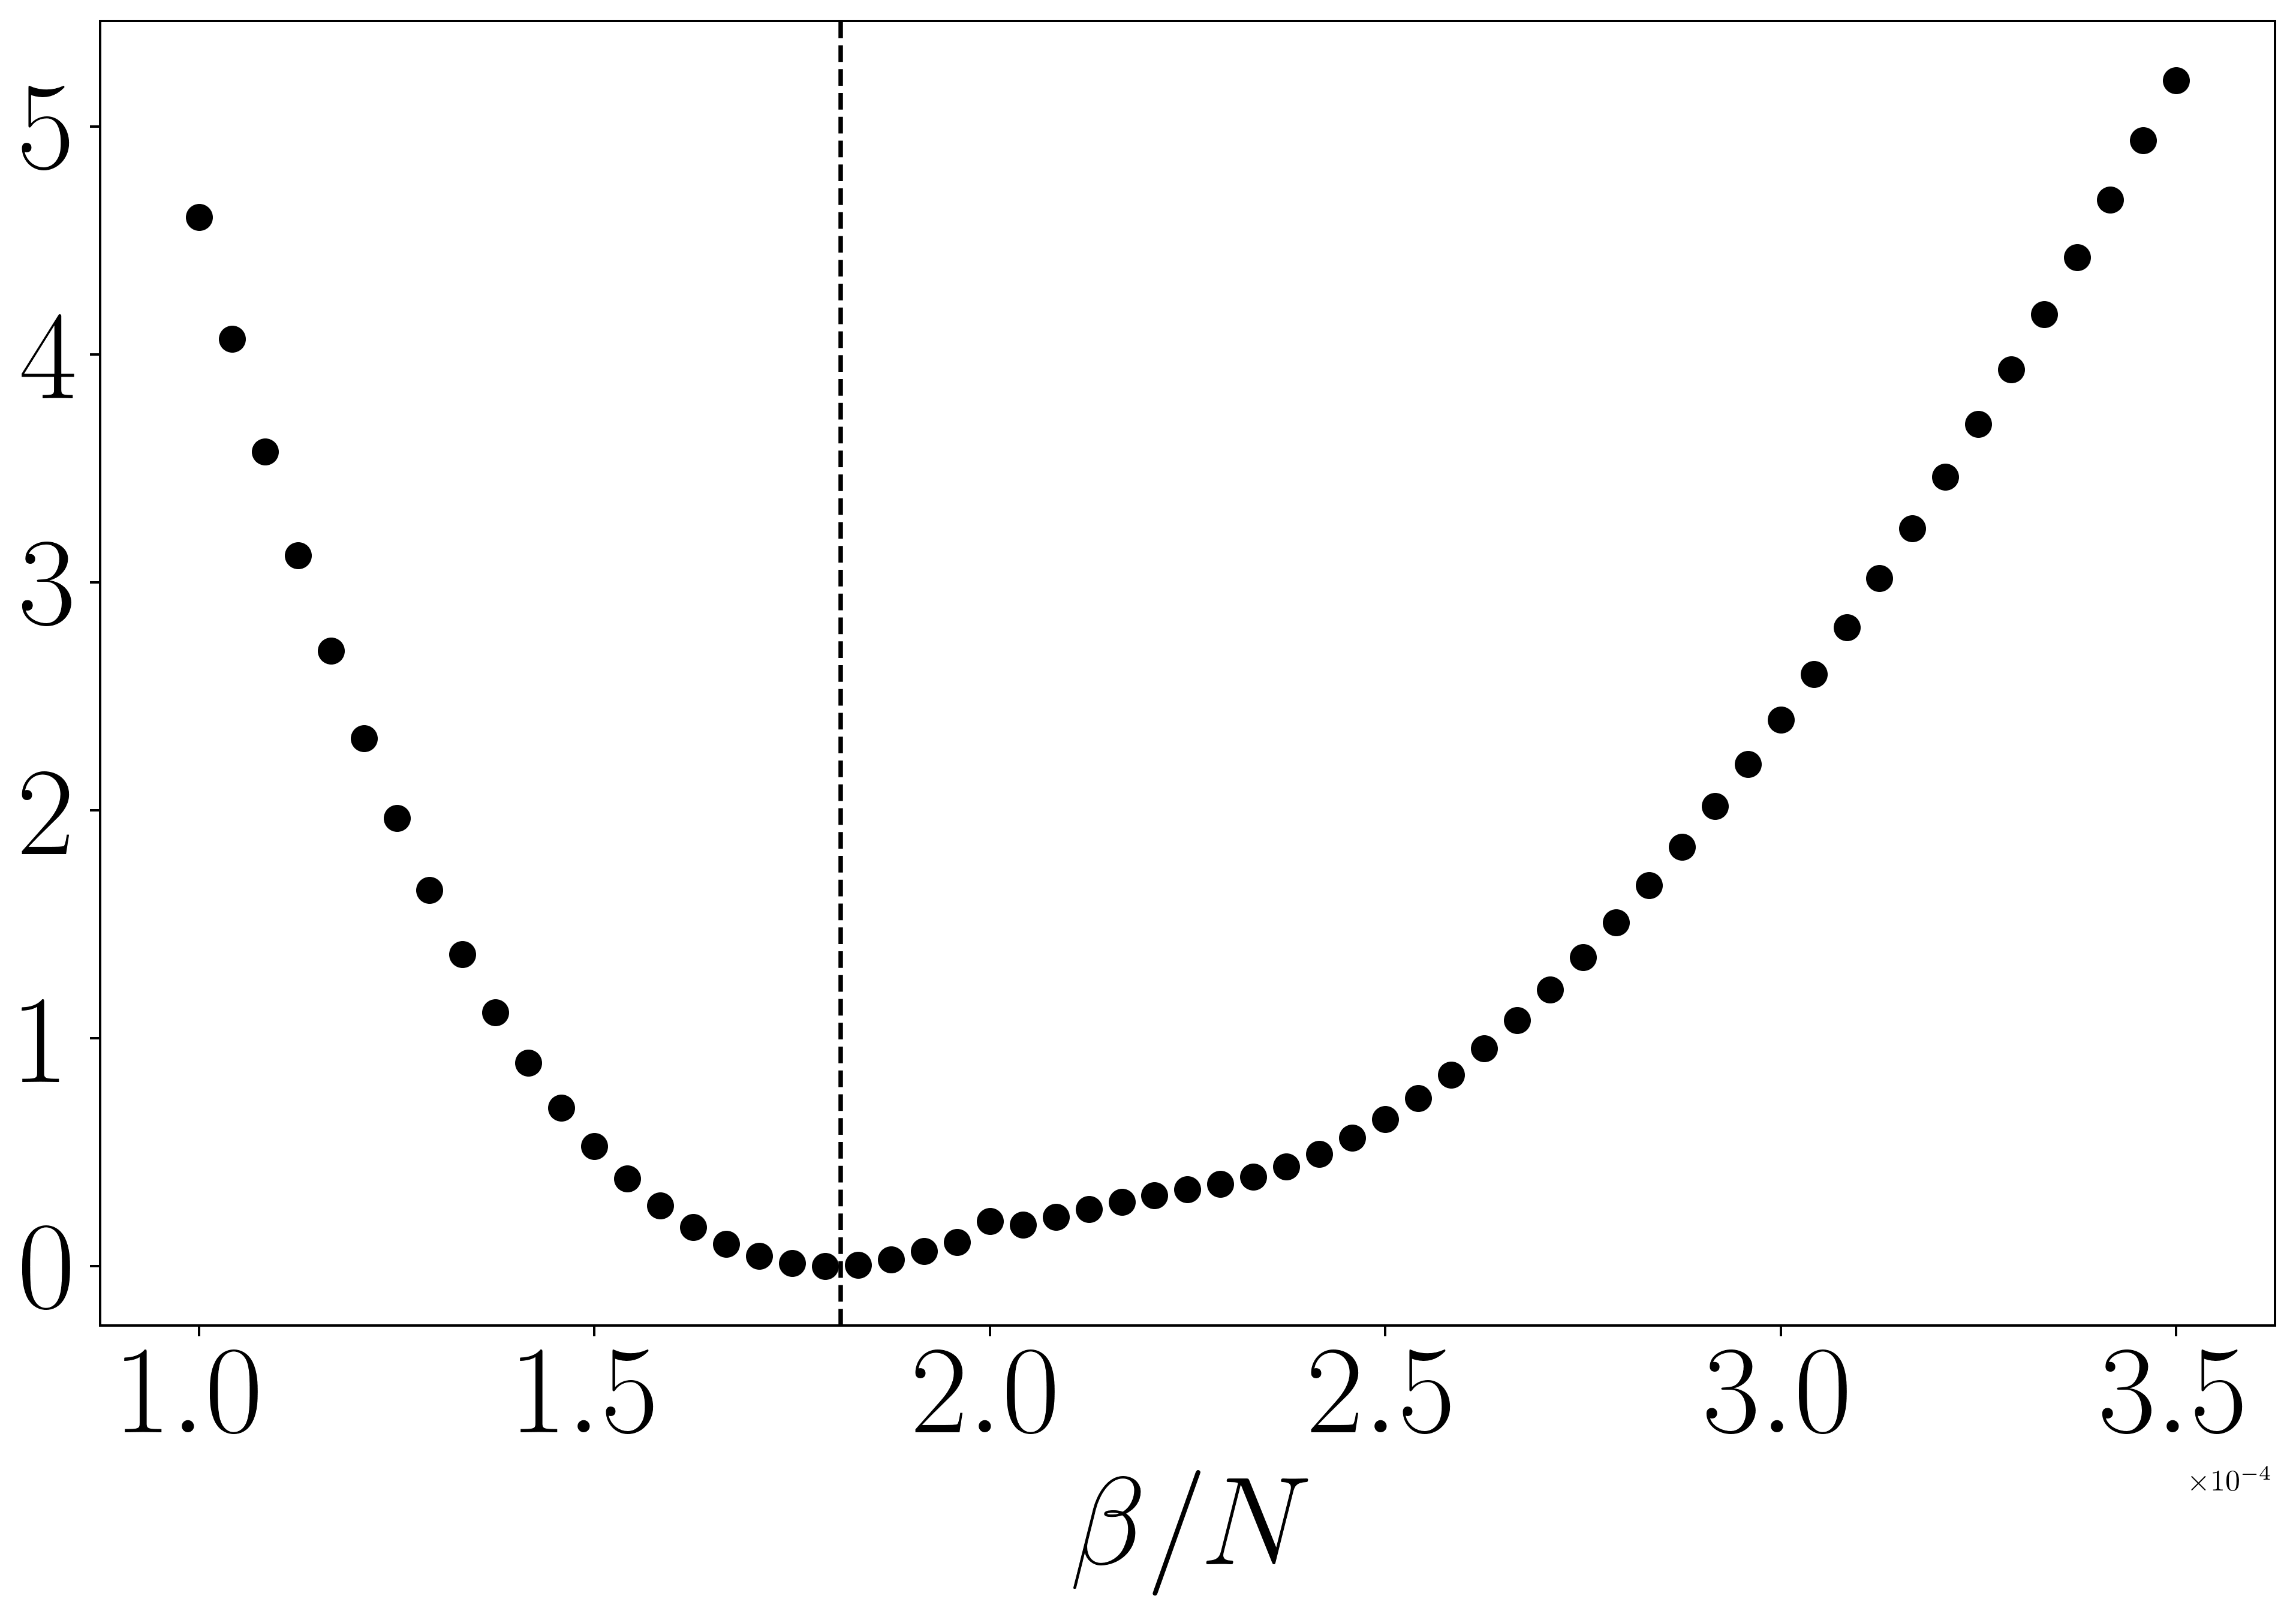

In [597]:
bNalsominf = min([s['f']-fr_ex(s['x']) for s in bNprofile])
plt.figure(figsize=[13,8],dpi=360)
plt.plot(bNrange, [s['f']-bNalsominf -fr_ex(s['x']) for s in bNprofile], 'o', color='k',markersize=8)
plt.axvline(float(bNfn(sols[idx])), linestyle='--', color='k')
# plt.ylim([-0.1, 2])
# plt.xlim([0.0001, 0.00025])
# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel('Relative Objective Function Value', font_properties=label_font)
plt.rc('font', size=28)
plt.xlabel('$\\beta/N$', font_properties=pub_font2)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xticks(font_properties=pub_font2)
plt.yticks(font_properties=pub_font2);


In [588]:
bNpfn = lambda x: np.interp(x, bNrange, [s['f']-bNalsominf -fr_ex(s['x']) for s in bNprofile])
bNinterval1 = optimize.fsolve(lambda x: bNpfn(x)-1.96, 0.00015)
bNinterval2 = optimize.fsolve(lambda x: bNpfn(x)-1.96, 0.0003)
print(bNinterval1, bNinterval2)

[0.00012508] [0.00029032]


/home/dwu402/.virtualenvs/scider/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


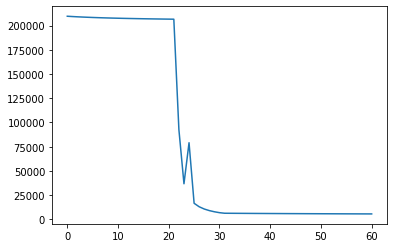

In [487]:
plt.plot([N0(b) for b in bNprofile])

In [491]:
bNpfn2 = lambda x: np.interp(x, bNrange, [N0(s) for s in bNprofile])
print(bNpfn2(bNinterval1)*bNinterval1)
print(bNpfn2(bNinterval2)*bNinterval2)

[26.03323381]
[1.72961467]


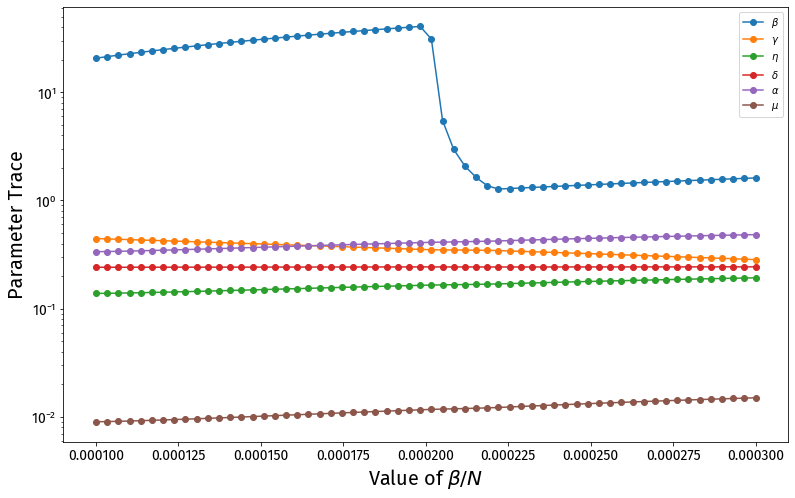

In [206]:
plt.figure(figsize=[13,8])
plt.plot(bNrange, [float(s['x'][-6]) for s in bNprofile], 'o-', label=r'$\beta$')
plt.plot(bNrange, [float(s['x'][-5]) for s in bNprofile], 'o-', label=r'$\gamma$')
plt.plot(bNrange, [float(s['x'][-4]) for s in bNprofile], 'o-', label=r'$\eta$')
plt.plot(bNrange, [float(s['x'][-3]) for s in bNprofile], 'o-', label=r'$\delta$')
plt.plot(bNrange, [float(s['x'][-2]) for s in bNprofile], 'o-', label=r'$\alpha$')
plt.plot(bNrange, [float(s['x'][-1]) for s in bNprofile], 'o-', label=r'$\mu$')
# plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylabel('Parameter Trace', font_properties=label_font)
plt.xlabel('Value of $\\beta/N$', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font);

Text(0.5, 1.0, 'R0 by b/N')

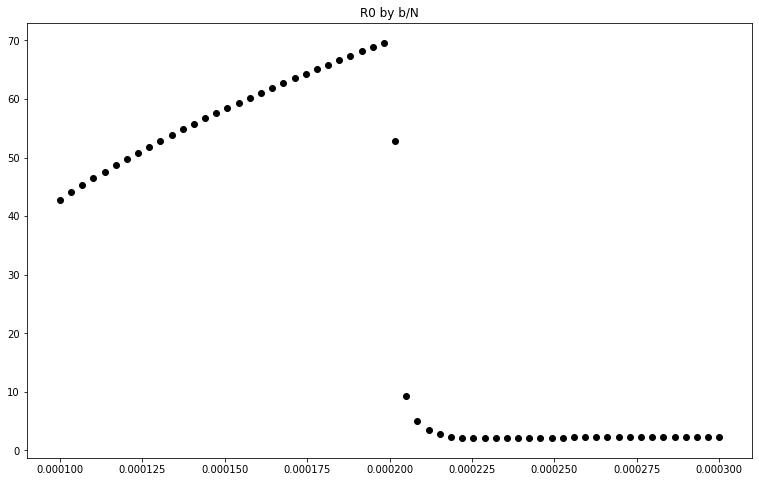

In [207]:
plt.figure(figsize=[13,8],)

plt.plot(bNrange,
        [r0(sol) for sol in bNprofile], 
         'o', color='k',)
# plt.axvline(float(getp(sols[idx]['x'])[0]), linestyle='--', color='k')
plt.title('R0 by b/N')

Text(0.5, 1.0, 'N by b/N')

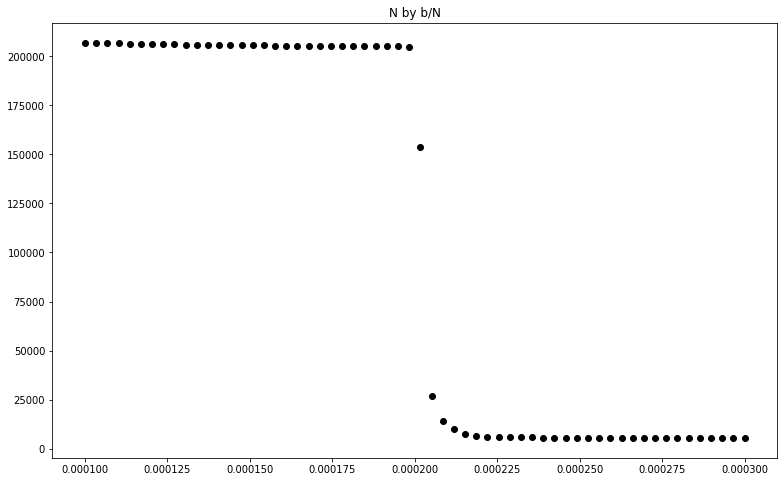

In [208]:
plt.figure(figsize=[13,8],)

plt.plot(bNrange,
        [N0(sol) for sol in bNprofile], 
         'o', color='k',)
plt.title('N by b/N')

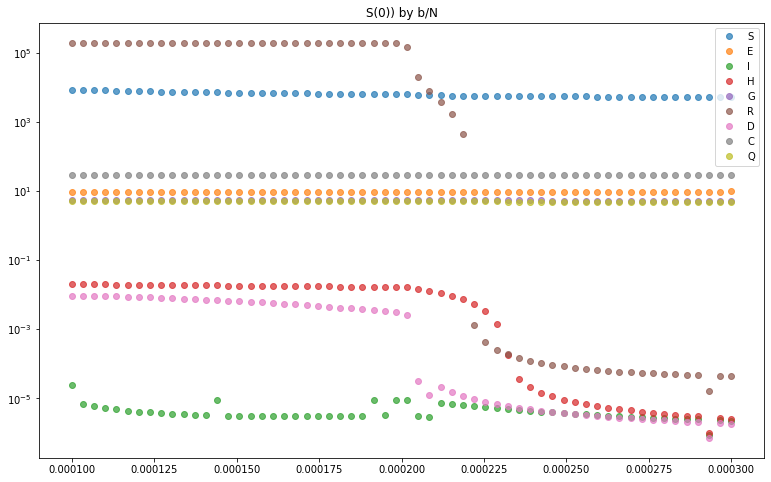

In [209]:
plt.figure(figsize=[13,8],)

plt.plot(bNrange,
        [[float(x[0]) for x in getx(sol['x'])] for sol in bNprofile ], 
         'o', alpha=0.7)
plt.title('S(0)) by b/N')
plt.legend('SEIHGRDCQ')
# ax = plt.gca().twinx()
# ax.plot(bNrange, [getx(sol['x'])[5][0] for sol in bNprofile], 'ro')
plt.yscale('log')

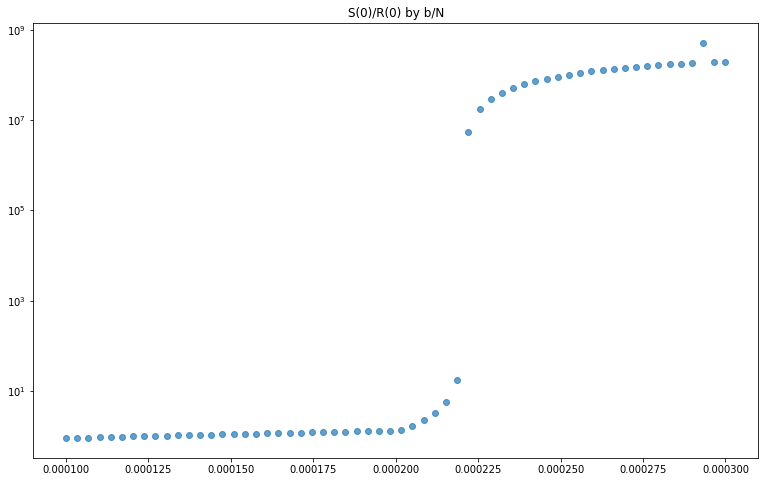

In [210]:
plt.figure(figsize=[13,8],)

plt.plot(bNrange,
        [getp(sol['x'])[0]*getx(sol['x'])[0][0]/getx(sol['x'])[5][0] for sol in bNprofile ], 
         'o', alpha=0.7)
plt.title('S(0)/R(0) by b/N')
plt.yscale('log')

Text(0.5, 1.0, 'S/N by b/N')

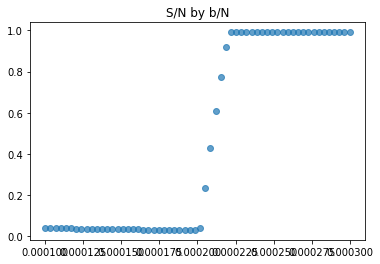

In [219]:
plt.figure()
plt.plot(bNrange,
        [getx(sol['x'])[0][0]/N0(sol) for sol in bNprofile ], 
         'o', alpha=0.7)
plt.title('S/N by b/N')
# plt.yscale('log')

Text(0.5, 1.0, 'bS/N by b (bN experiment)')

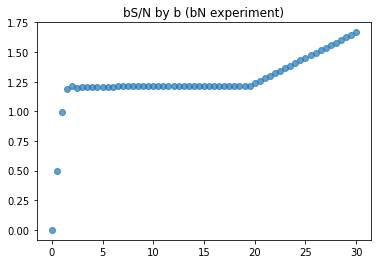

In [215]:
plt.figure()
plt.plot([getp(sol['x'])[0] for sol in bprofile ],
        [getp(sol['x'])[0]*getx(sol['x'])[0][0]/N0(sol) for sol in bprofile ], 
         'o', alpha=0.7)
plt.title('bS/N by b (bN experiment)')

In [379]:
# profiling for a, g, m
approfile = []
aprange = np.linspace(0,2, num=41)
for ap in aprange:
    lbxp = copy(lbx)
    lbxp[-2] = ap
    ubxp = [np.inf]*len(lbxp)
    ubxp[-2] = ap
    psolve_opts = {
        'x0': pref,
        'p': [prange[idx], alpha],
        'lbx': lbxp,
        'ubx': ubxp,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f'a={ap}')
    approfile.append(solver(**psolve_opts))


a=0.0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7180

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


 100  4.7569753e+02 0.00e+00 2.37e+01  -3.8 2.46e+02 -11.2 1.00e+00 1.00e+00f  1
 150  4.7148607e+02 0.00e+00 3.13e+01  -3.8 1.84e+03 -11.3 1.00e+00 1.25e-01f  4
 200  4.6124129e+02 0.00e+00 3.29e+00  -3.8 1.02e+02 -10.2 1.00e+00 1.00e+00f  1
 250  4.4373996e+02 0.00e+00 1.66e+01  -3.8 2.95e+03 -11.0 1.00e+00 1.25e-01f  4
 300  4.2376355e+02 0.00e+00 5.66e+00  -3.8 9.07e+01 -10.5 1.00e+00 1.00e+00f  1
 350  4.1518120e+02 0.00e+00 5.90e+00  -5.7 1.34e+02  -9.2 1.00e+00 5.00e-01f  2
 400  4.1321202e+02 0.00e+00 7.16e-03  -5.7 2.38e+00  -7.8 1.00e+00 1.00e+00h  1
 450  4.1070610e+02 0.00e+00 1.57e-03  -5.7 1.41e+00  -8.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.0636641e+02 0.00e+00 2.22e+00  -5.7 7.56e+02 -11.2 1.00e+00 5.00e-01f  2
 550  3.9824261e+02 0.00e+00 3.08e-01  -5.7 2.18e+02  -9.8 1.00e+00 1.00e+00f  1
 600  3.8305684e+02 0.00e+00 1.44e-01  -5.7 1.68e+02  -9.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 6

 100  4.6702085e+02 0.00e+00 8.64e+00  -3.8 1.31e+02  -9.9 1.00e+00 1.00e+00f  1
 150  4.5860818e+02 0.00e+00 9.06e+01  -3.8 4.08e+02 -11.2 1.00e+00 5.00e-01f  2
 200  4.3677303e+02 0.00e+00 2.33e+01  -3.8 7.32e+02 -10.6 1.00e+00 1.00e+00f  1
 250  4.0544299e+02 0.00e+00 1.49e+01  -3.8 3.75e+02 -10.1 1.00e+00 1.00e+00f  1
 300  3.8702709e+02 0.00e+00 9.30e+00  -3.8 1.33e+04    -  1.00e+00 1.25e-01f  4
 350  3.8465691e+02 0.00e+00 1.35e-01  -3.8 1.40e+03    -  1.00e+00 2.50e-01h  3
 400  3.8117295e+02 0.00e+00 5.42e-03  -5.7 5.19e+00  -8.1 1.00e+00 1.00e+00h  1
 450  3.7584125e+02 0.00e+00 6.99e-02  -5.7 2.47e+00  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.6149826e+02 0.00e+00 1.27e+00  -5.7 6.41e+02  -9.8 1.00e+00 1.00e+00f  1
 550  3.4913935e+02 0.00e+00 3.82e-02  -5.7 5.62e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 560

                                   (scaled)                 (unscaled)
Object


Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7180

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7109472e+02 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  3.3837178e+02 0.00e+00 7.94e-06  -8.6 1.28e+00    -  1.00e+00

  50  2.8145157e+03 0.00e+00 8.22e+02  -1.0 7.52e+02  -8.2 1.00e+00 5.00e-01f  2
 100  4.6902373e+02 0.00e+00 6.00e+00  -3.8 5.15e+02  -9.8 1.00e+00 5.00e-01f  2
 150  4.5407059e+02 0.00e+00 2.78e+01  -3.8 2.14e+02 -10.2 1.00e+00 1.00e+00f  1
 200  4.1916361e+02 0.00e+00 4.96e+01  -3.8 1.38e+02  -8.7 1.00e+00 1.00e+00f  1
 250  3.7594817e+02 0.00e+00 2.54e+01  -3.8 1.22e+04    -  1.00e+00 1.25e-01f  4
 300  3.6002243e+02 0.00e+00 8.91e-01  -5.7 3.07e+02  -9.3 1.00e+00 1.25e-01f  4
 350  3.5550618e+02 0.00e+00 1.79e-01  -5.7 3.50e+00  -7.0 1.00e+00 1.00e+00f  1
 400  3.4685438e+02 0.00e+00 8.07e-05  -5.7 1.34e+00  -7.3 1.00e+00 1.00e+00h  1
 450  3.3454380e+02 0.00e+00 6.99e-02  -8.6 3.19e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 471

                                   (scaled)                 (unscaled)
Objective...............:   3.4225177710474002e+00    3.3451304028307305e+02
Dual infea

 150  4.7299921e+02 0.00e+00 6.59e+01  -3.8 4.10e+03    -  1.00e+00 1.25e-01f  4
 200  4.5679856e+02 0.00e+00 8.17e+01  -3.8 7.60e+02 -11.1 1.00e+00 5.00e-01f  2
 250  4.2260875e+02 0.00e+00 2.09e+01  -3.8 3.58e+04 -10.5 3.22e-01 5.47e-03f  6
 300  3.7677608e+02 0.00e+00 8.18e+00  -3.8 1.23e+02 -10.3 1.00e+00 1.00e+00f  1
 350  3.5872784e+02 0.00e+00 1.66e+00  -5.7 8.07e+02 -10.3 1.00e+00 1.00e+00f  1
 400  3.5558814e+02 0.00e+00 1.27e-01  -8.6 1.35e+03 -11.6 1.00e+00 1.00e+00f  1
 450  3.4899589e+02 0.00e+00 1.04e-01  -8.6 8.68e+00  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.3758271e+02 0.00e+00 4.09e-01  -8.6 5.34e+02 -10.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 537

                                   (scaled)                 (unscaled)
Objective...............:   1.7295633321003223e+00    3.3479905610122262e+02
Dual infeasibility......:   3.4948848074480489e-09    6.7651997067676029e-07
Constraint vio

 150  4.7836952e+02 0.00e+00 1.97e+01  -3.8 3.11e+03 -11.2 1.00e+00 2.50e-01f  3
 200  4.5861405e+02 0.00e+00 1.27e+01  -3.8 5.32e+02 -11.4 1.00e+00 1.00e+00f  1
 250  4.2032739e+02 0.00e+00 1.37e+01  -3.8 6.44e+02 -10.2 1.00e+00 2.50e-01f  3
 300  3.7605145e+02 0.00e+00 1.93e+00  -3.8 8.60e+01 -10.4 1.00e+00 1.00e+00f  1
 350  3.5984007e+02 0.00e+00 1.90e-01  -5.7 3.43e+02 -10.4 1.00e+00 1.00e+00f  1
 400  3.5746621e+02 0.00e+00 1.85e-02  -8.6 1.91e+00  -7.1 1.00e+00 1.00e+00f  1
 450  3.5385358e+02 0.00e+00 2.76e-04  -8.6 6.33e-01  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.4687971e+02 0.00e+00 1.08e-01  -8.6 5.42e+02 -10.6 1.00e+00 1.00e+00f  1
 550  3.3803237e+02 0.00e+00 2.61e-05  -8.6 2.89e+01 -12.6 1.00e+00 1.00e+00h  1

Number of Iterations....: 574

                                   (scaled)                 (unscaled)
Objective...............:   1.1679577615943113e+00    3.3801839382579612e+02
Dual infea

 250  4.3051129e+02 0.00e+00 6.73e+00  -3.8 3.10e+02  -9.9 1.00e+00 1.00e+00f  1
 300  3.8805895e+02 0.00e+00 6.13e-01  -3.8 7.80e+01 -10.1 1.00e+00 1.00e+00f  1
 350  3.6446261e+02 0.00e+00 1.28e+00  -5.7 3.28e+02  -8.2 1.00e+00 6.25e-02f  5
 400  3.6061377e+02 0.00e+00 7.97e-05  -8.6 3.92e+01 -10.4 1.00e+00 1.00e+00h  1
 450  3.4752136e+02 0.00e+00 5.41e-03  -8.6 1.05e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.4356525e+02 0.00e+00 4.05e-05  -8.6 2.55e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 502

                                   (scaled)                 (unscaled)
Objective...............:   8.9180924064710820e-01    3.4356525204598051e+02
Dual infeasibility......:   2.4804078613651802e-10    9.5556528596676738e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5065086048359508e-09    9.6562047277175719e-07
Overall NLP error.....

  50  2.8509018e+03 0.00e+00 4.76e+02  -1.7 1.35e+04    -  1.00e+00 1.25e-01f  4
 100  4.9870533e+02 0.00e+00 2.03e+01  -3.8 1.31e+03 -11.0 1.00e+00 2.50e-01f  3
 150  4.8155137e+02 0.00e+00 2.00e+01  -3.8 6.56e+03    -  1.00e+00 6.25e-02f  5
 200  4.4505456e+02 0.00e+00 9.86e+00  -3.8 5.98e+02 -11.1 1.00e+00 5.00e-01f  2
 250  4.0133807e+02 0.00e+00 5.61e+00  -3.8 4.49e+02 -11.4 1.00e+00 1.00e+00f  1
 300  3.7141106e+02 0.00e+00 9.47e-01  -5.7 5.33e+02 -10.9 1.00e+00 5.00e-01f  2
 350  3.6742776e+02 0.00e+00 1.32e-02  -8.6 9.33e+02 -12.1 1.00e+00 1.00e+00f  1
 400  3.5590447e+02 0.00e+00 7.03e-02  -8.6 4.96e+02 -10.7 1.00e+00 1.00e+00f  1
 450  3.5111064e+02 0.00e+00 5.98e-03  -8.6 2.91e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 465

                                   (scaled)                 (unscaled)
Objective...............:   7.2982732693241104e-01    3.5110582333216081e+02
Dual infea

  50  4.0891546e+02 0.00e+00 1.41e+00  -5.7 1.97e+02 -10.1 1.00e+00 1.00e+00f  1
 100  3.6112412e+02 0.00e+00 1.62e-01  -5.7 1.34e+04    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 126

                                   (scaled)                 (unscaled)
Objective...............:   6.2477344555242964e-01    3.6044187531951764e+02
Dual infeasibility......:   6.4102058406059243e-12    3.6981511151280701e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059042843226782e-09    1.4456965897675664e-06
Overall NLP error.......:   2.5059042843226782e-09    1.4456965897675664e-06


Number of objective function evaluations             = 227
Number of objective gradient evaluations             = 127
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 227
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 12

 450  3.7219244e+02 0.00e+00 8.59e-02  -5.7 4.21e+03    -  1.00e+00 1.06e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 493

                                   (scaled)                 (unscaled)
Objective...............:   5.5213333916855534e-01    3.7144857353220806e+02
Dual infeasibility......:   3.9200976439492750e-09    2.6372518640961920e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    1.6858505665572249e-06
Overall NLP error.......:   3.9200976439492750e-09    2.6372518640961920e-06


Number of objective function evaluations             = 1004
Number of objective gradient evaluations             = 494
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1004
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

 200  4.9794305e+02 0.00e+00 3.65e+00  -3.8 7.03e+02 -12.2 1.00e+00 1.00e+00f  1
 250  4.5745791e+02 0.00e+00 3.11e+00  -3.8 1.57e+02 -10.7 1.00e+00 1.00e+00f  1
 300  4.2135143e+02 0.00e+00 2.25e-01  -5.7 1.41e+01  -8.0 1.00e+00 1.00e+00f  1
 350  4.0028202e+02 0.00e+00 1.64e-02  -5.7 1.97e+02 -11.1 1.00e+00 1.00e+00h  1
 400  3.9615115e+02 0.00e+00 1.69e-03  -5.7 3.47e+02 -11.5 1.00e+00 1.00e+00f  1
 450  3.8597539e+02 0.00e+00 4.55e-02  -5.7 4.39e+02 -11.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.8404352e+02 0.00e+00 5.29e-13  -8.6 7.07e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 500

                                   (scaled)                 (unscaled)
Objective...............:   4.9967474162047032e-01    3.8404352303669799e+02
Dual infeasibility......:   5.2886074796864501e-13    4.0647550882203921e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

 300  4.6502690e+02 0.00e+00 1.17e+00  -3.8 5.52e+02    -  1.00e+00 5.00e-01f  2
 350  4.1973168e+02 0.00e+00 1.72e-01  -5.7 6.75e+02 -10.9 1.00e+00 1.00e+00f  1
 400  4.1188540e+02 0.00e+00 2.25e-01  -8.6 3.92e+03 -13.1 1.00e+00 1.00e+00f  1
 450  4.0341116e+02 0.00e+00 2.21e-02  -8.6 5.01e+00  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9817198e+02 0.00e+00 3.13e-04  -8.6 7.39e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 529

                                   (scaled)                 (unscaled)
Objective...............:   4.6061991829890397e-01    3.9817020964160781e+02
Dual infeasibility......:   2.4887911803096054e-10    2.1513670309302779e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.1661593562525624e-06
Overall NLP error.......:   2.5059035596800626e-09    2.1661593562525624e-06


Number of objective func

 100  5.7857672e+02 0.00e+00 1.75e+00  -3.8 3.28e+02 -11.6 1.00e+00 1.00e+00f  1
 150  5.6964467e+02 0.00e+00 1.20e+01  -3.8 3.27e+02    -  1.00e+00 1.00e+00f  1
 200  5.5081293e+02 0.00e+00 1.76e+00  -3.8 2.12e+02 -11.6 1.00e+00 1.00e+00f  1
 250  5.1775773e+02 0.00e+00 8.43e-01  -3.8 8.36e+01 -11.8 1.00e+00 1.00e+00f  1
 300  4.8436475e+02 0.00e+00 4.87e-01  -3.8 2.31e+02    -  1.00e+00 1.00e+00f  1
 350  4.3592431e+02 0.00e+00 1.03e+00  -5.7 8.44e+02 -11.0 1.00e+00 1.00e+00f  1
 400  4.2839215e+02 0.00e+00 7.88e-06  -8.6 1.23e+01 -10.5 1.00e+00 1.00e+00h  1
 450  4.2363216e+02 0.00e+00 3.56e-03  -8.6 1.95e+00  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1498750e+02 0.00e+00 5.23e-02  -8.6 5.50e+02 -11.2 1.00e+00 1.00e+00f  1
 550  4.1378870e+02 0.00e+00 4.17e-04  -8.6 3.15e+03    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 559

                                   (scaled)                 (unscaled)
Object

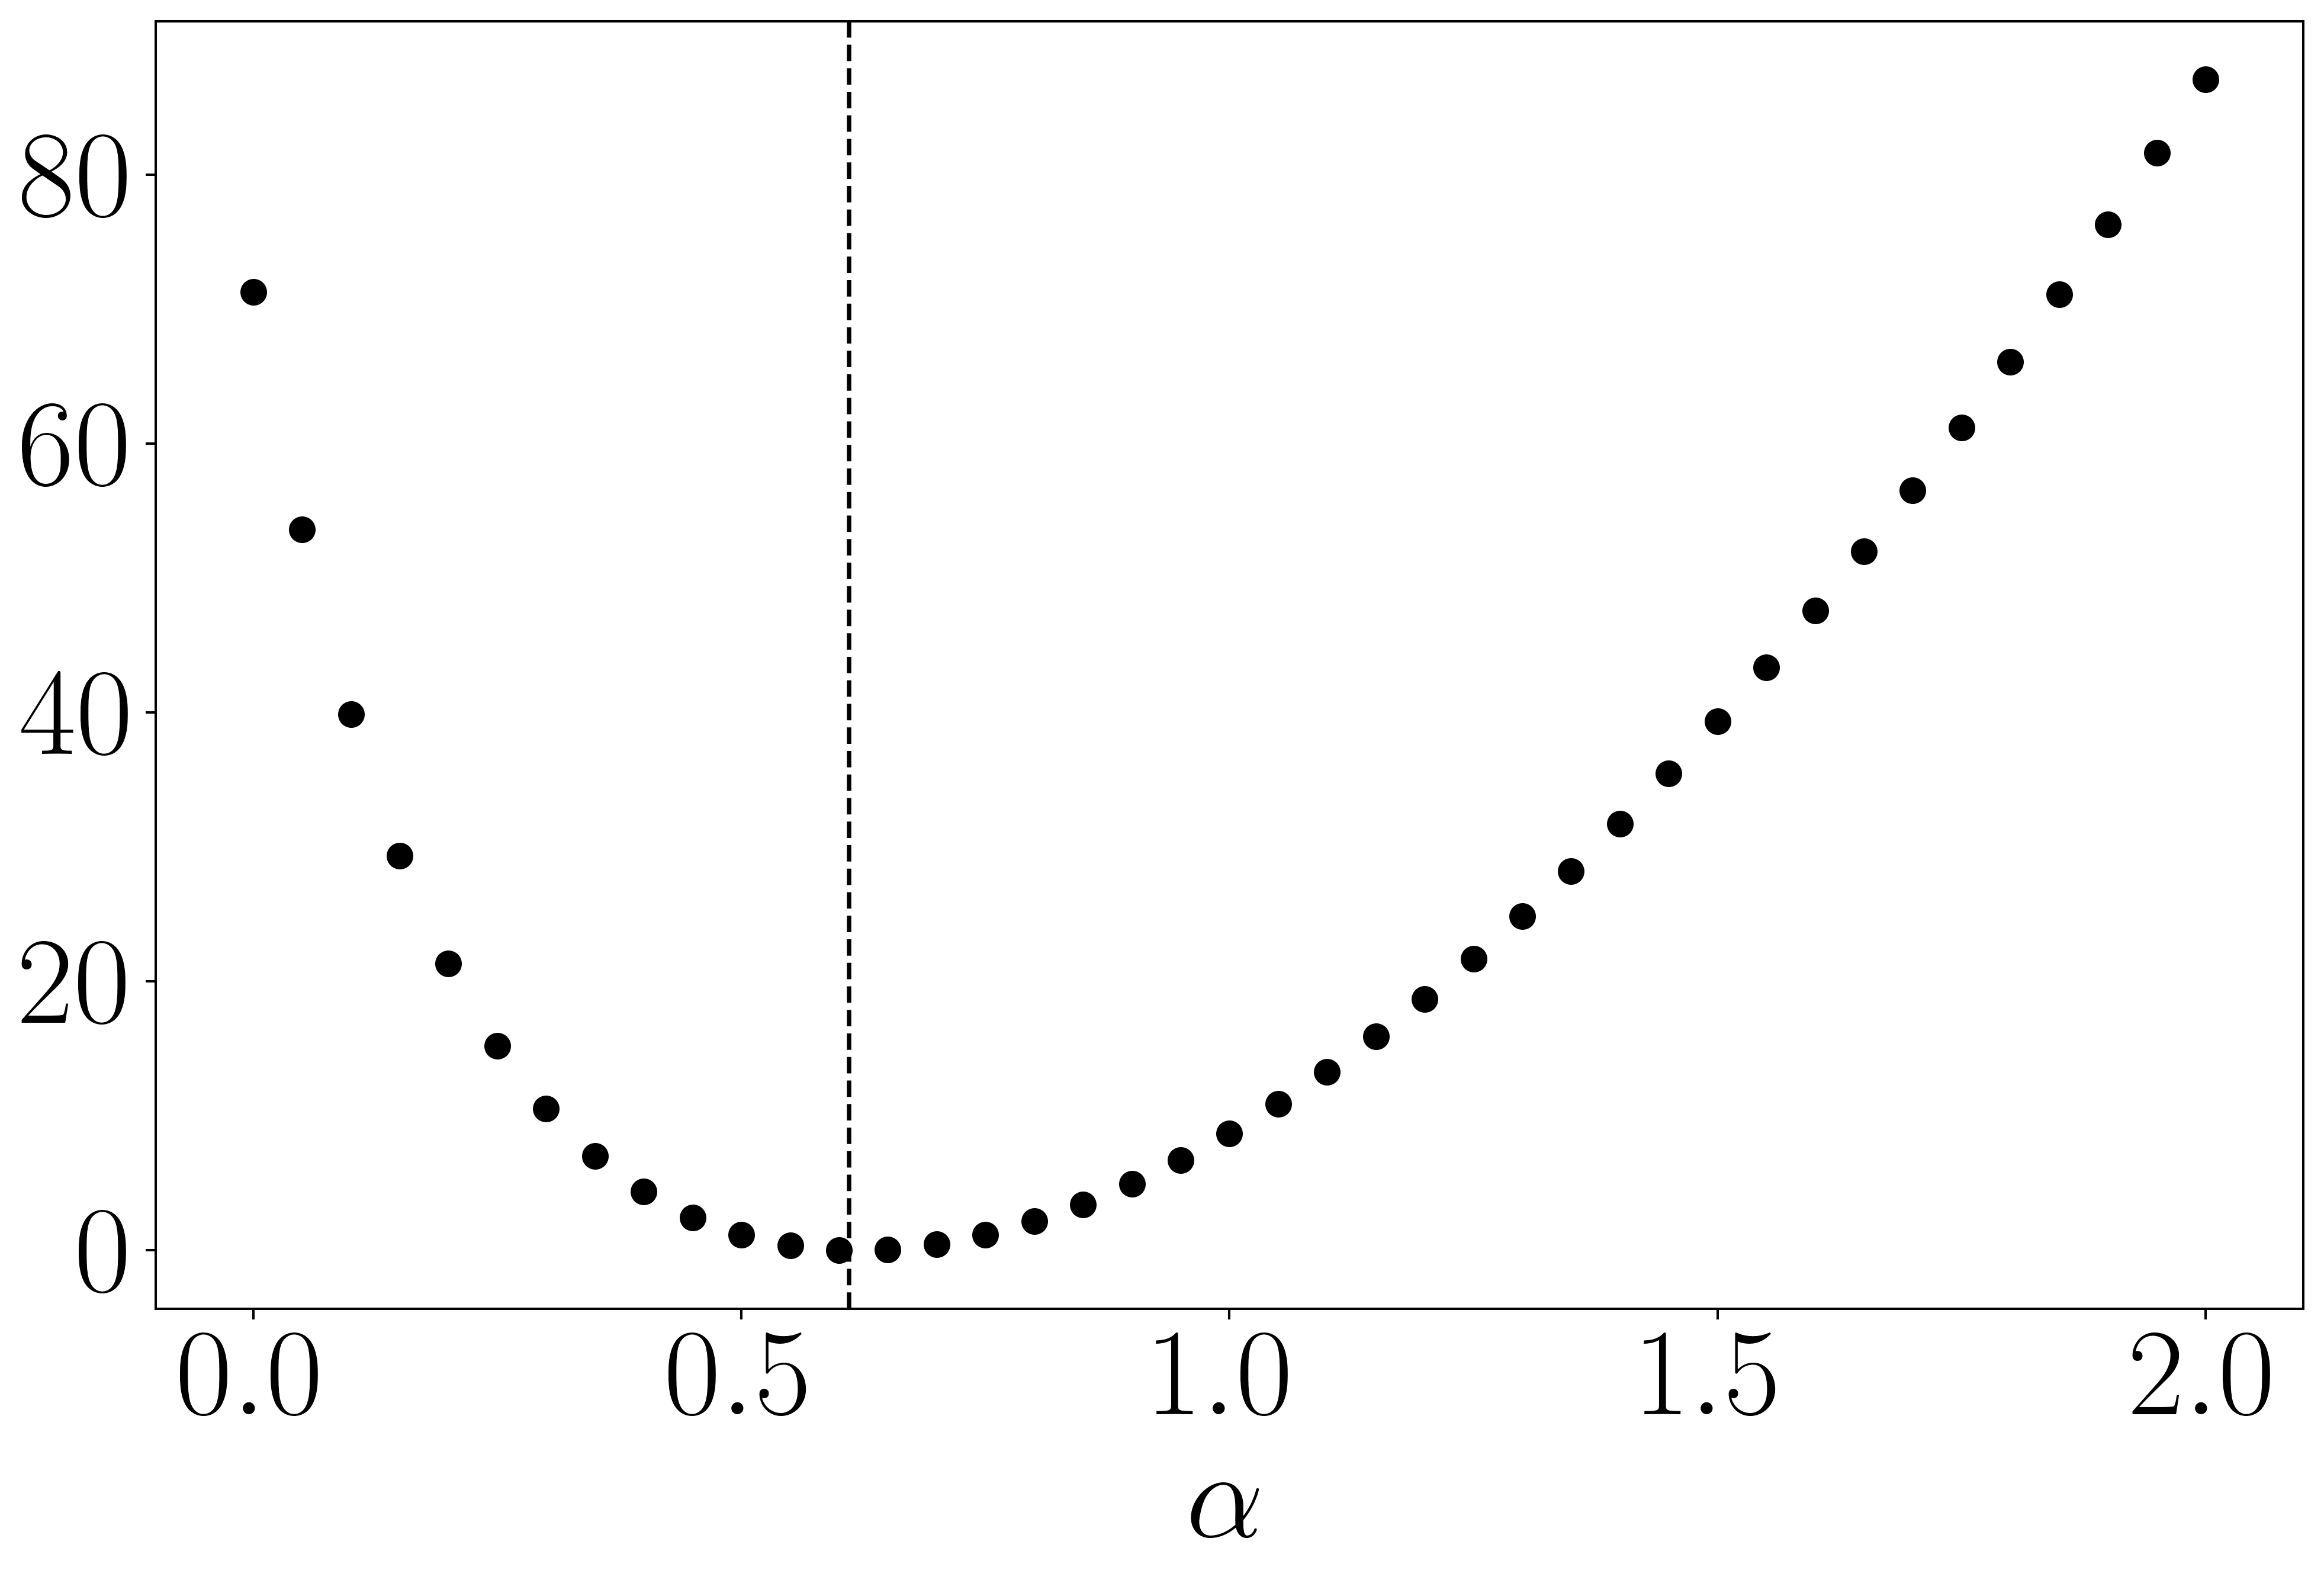

In [601]:
apalsominf = min([s['f']-fr_ex(s['x']) for s in approfile])
plt.figure(figsize=[13,8],dpi=360)
plt.plot(aprange, [s['f']-apalsominf -fr_ex(s['x']) for s in approfile], 'o', color='k',markersize=8)
plt.axvline(float(getp(pref)[-2]), linestyle='--', color='k')
# plt.ylim([-0.1, 2])
# plt.xlim([0.0001, 0.00025])
# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel('Relative Objective Function Value', font_properties=label_font)
plt.xlabel('$\\alpha$', font_properties=pub_font2)
plt.xticks(font_properties=pub_font2)
plt.yticks(font_properties=pub_font2);

In [480]:
apfn = lambda x: np.interp(x, aprange, [s['f']-apalsominf -fr_ex(s['x']) for s in approfile])
print(optimize.fsolve(lambda x: apfn(x)-1.96, 0.5))
print(optimize.fsolve(lambda x: apfn(x)-1.96, 1))


[0.46867963]
[0.79070992]


In [386]:
pref = sols[idx]['x']
getp(pref)

(DM(19.3124),
 DM(0.579463),
 DM(0.225398),
 DM(0.230009),
 DM(0.610375),
 DM(0.0152926))

In [423]:
getx(pref)[0][0]/N0(sols[idx])

DM(0.0742029)

In [475]:
r0(sols[idx])

DM(1.68381)

In [476]:
prange[idx]

1.1497569953977356

In [584]:
# profiling for a, g, m
gprofile = []
grange = np.linspace(0.4,0.8, num=41)
for g in grange:
    lbxp = copy(lbx)
    lbxp[-5] = g
    ubxp = [np.inf]*len(lbxp)
    ubxp[-5] = g
    psolve_opts = {
        'x0': pref,
        'p': [prange[idx], alpha],
        'lbx': lbxp,
        'ubx': ubxp,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f'g={g}')
    gprofile.append(solver(**psolve_opts))

g=0.4
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     6979

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


 300  3.7459813e+02 0.00e+00 2.92e+00  -3.8 3.13e+02 -10.1 1.00e+00 5.00e-01f  2
 350  3.6994941e+02 0.00e+00 6.29e-01  -3.8 8.53e+02 -11.1 1.00e+00 1.00e+00f  1
 400  3.3716401e+02 0.00e+00 3.64e-01  -5.7 2.21e+03 -10.6 1.00e+00 1.00e+00f  1
 450  3.3657964e+02 0.00e+00 3.07e-03  -8.6 4.31e+03 -14.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 455

                                   (scaled)                 (unscaled)
Objective...............:   7.9198120367569596e+00    3.3657858889860609e+02
Dual infeasibility......:   8.2300911164955737e-09    3.4976492392000451e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.1136929407306276e-09    1.3232667282894336e-07
Overall NLP error.......:   8.2300911164955737e-09    3.4976492392000451e-07


Number of objective function evaluations             = 858
Number of objective gradient evaluations      

 100  4.5144692e+02 0.00e+00 3.97e+01  -2.5 4.73e+02  -9.5 1.00e+00 1.00e+00f  1
 150  4.3601642e+02 0.00e+00 1.46e+02  -3.8 7.21e+02 -11.7 1.00e+00 5.00e-01f  2
 200  4.2620553e+02 0.00e+00 8.22e+01  -3.8 8.37e+02 -11.2 1.00e+00 1.00e+00f  1
 250  4.0006875e+02 0.00e+00 5.83e+01  -3.8 7.38e+02  -9.8 1.00e+00 2.50e-01f  3
 300  3.7423856e+02 0.00e+00 1.54e+01  -3.8 1.78e+02  -9.2 1.00e+00 5.00e-01f  2
 350  3.6970141e+02 0.00e+00 3.03e+00  -5.7 2.32e+03 -11.4 1.00e+00 1.00e+00f  1
 400  3.6308313e+02 0.00e+00 8.13e-06  -5.7 1.84e+00  -7.0 1.00e+00 1.00e+00h  1
 450  3.3579344e+02 0.00e+00 6.86e-02  -8.6 2.08e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 499

                                   (scaled)                 (unscaled)
Objective...............:   9.7302301050287863e+00    3.3572274885944188e+02
Dual infeasibility......:   1.1568360140395491e-09    3.9914386650757248e-08
Constraint vio

                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.2139394e+02 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  1.1695782e+03 0.00e+00 1.10e+04  -1.0 1.73e+04    -  1.00e+00 5.00e-01f  2
 100  4.5166201e+02 0.00e+00 1.13e+03  -2.5 7.40e+03    -  1.00e+00 2.50e-01f  3
 150  4.3462399e+02 0.00e+00 3.93e+01  -3.8 1.49e+02 -10.9 1.00e+00 1.00e+00f  1
 200  4.2286149e+02 0.00e+00 1.07e+02  -3.8 4.20e+02 -10.3 1.00e+00 1.00e+00f  1
 250  3.9405143e+02 0.00e+00 4.17e+01  -3.8 2.60e+02  -9.8 1.00e+

 100  6.9800027e+02 0.00e+00 2.89e+04  -2.5 2.34e+03  -8.1 9.21e-01 1.00e+00f  1
 150  4.3596165e+02 0.00e+00 8.94e+01  -3.8 2.35e+02  -8.9 1.00e+00 1.00e+00f  1
 200  4.2987286e+02 0.00e+00 3.38e+02  -3.8 6.09e+02 -11.1 1.00e+00 1.00e+00f  1
 250  4.0928773e+02 0.00e+00 1.45e+02  -3.8 8.49e+02  -9.7 1.00e+00 2.50e-01f  3
 300  3.7450716e+02 0.00e+00 1.06e+01  -3.8 2.84e+02  -9.1 1.00e+00 1.00e+00f  1
 350  3.6463982e+02 0.00e+00 9.97e-01  -3.8 5.42e+01  -6.8 1.00e+00 1.25e-01f  4
 400  3.5917471e+02 0.00e+00 1.03e+00  -5.7 7.77e+02  -9.9 1.00e+00 1.00e+00f  1
 450  3.3464975e+02 0.00e+00 6.94e-02  -5.7 7.92e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 471

                                   (scaled)                 (unscaled)
Objective...............:   1.8075568019035380e+01    3.3462541090418307e+02
Dual infeasibility......:   4.0325085211716151e-09    7.4652139255078427e-08
Constraint vio

 200  4.3093450e+02 0.00e+00 5.44e+02  -2.5 1.14e+03    -  1.00e+00 2.50e-01f  3
 250  4.1606237e+02 0.00e+00 2.06e+02  -2.5 2.51e+02  -7.5 1.00e+00 5.00e-01f  2
 300  3.8706578e+02 0.00e+00 9.41e+01  -2.5 2.70e+02  -9.7 1.00e+00 1.00e+00f  1
 350  3.6811185e+02 0.00e+00 1.05e+01  -2.5 2.39e+01  -6.6 1.00e+00 5.00e-01f  2
 400  3.6323782e+02 0.00e+00 3.10e-01  -5.7 2.68e+01  -8.9 1.00e+00 1.00e+00f  1
 450  3.6006757e+02 0.00e+00 1.73e-03  -5.7 4.07e+00  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.3462253e+02 0.00e+00 2.34e+00  -5.7 3.28e+02  -9.6 1.00e+00 1.00e+00f  1
 550  3.3434574e+02 0.00e+00 4.18e-09  -9.0 4.96e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 550

                                   (scaled)                 (unscaled)
Objective...............:   3.1789955486511936e+01    3.3434574347618849e+02
Dual infeasibility......:   4.1819594480864783e-09    4.3983085835115155e-08
Constraint vio

  50  4.3595988e+02 0.00e+00 9.49e+02  -1.0 4.20e+02  -7.8 1.00e+00 1.00e+00f  1
 100  4.5670192e+02 0.00e+00 3.54e+03  -1.0 5.18e+02    -  1.00e+00 5.00e-01f  2
 150  4.6814782e+02 0.00e+00 4.11e+03  -1.0 4.38e+02  -8.7 1.00e+00 1.00e+00f  1
 200  4.3484285e+02 0.00e+00 1.20e+03  -2.5 7.30e+02 -10.4 1.00e+00 1.00e+00f  1
 250  4.2853993e+02 0.00e+00 1.58e+03  -2.5 2.27e+02  -8.1 1.00e+00 1.00e+00f  1
 300  4.0884695e+02 0.00e+00 5.76e+02  -2.5 3.44e+02  -9.4 1.00e+00 1.00e+00f  1
 350  3.7705610e+02 0.00e+00 3.15e+02  -2.5 1.19e+02  -8.8 1.00e+00 1.00e+00f  1
 400  3.6281547e+02 0.00e+00 1.27e+01  -2.5 1.69e+01  -7.7 1.00e+00 1.00e+00f  1
 450  3.5029542e+02 0.00e+00 9.34e+00  -2.5 9.60e+00  -5.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.3425346e+02 0.00e+00 6.18e-01  -5.7 2.90e+02 -10.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 522

                                   (scaled)                 (unscaled)
Object

 100  5.2777066e+02 0.00e+00 3.71e+02  -1.0 4.82e+03    -  1.00e+00 5.00e-01f  2
 150  4.3550802e+02 0.00e+00 8.58e+02  -2.5 6.85e+03 -11.5 1.00e+00 2.50e-01f  3
 200  4.3104240e+02 0.00e+00 4.92e+02  -2.5 1.28e+04    -  1.00e+00 3.12e-02f  6
 250  4.1669895e+02 0.00e+00 4.04e+02  -2.5 2.51e+02  -9.7 1.00e+00 1.00e+00f  1
 300  3.8785039e+02 0.00e+00 2.27e+02  -2.5 5.77e+02 -10.1 1.00e+00 5.00e-01f  2
 350  3.6400486e+02 0.00e+00 2.20e+00  -2.5 3.33e+02  -9.5 1.00e+00 1.00e+00f  1
 400  3.5984196e+02 0.00e+00 5.69e-03  -3.8 5.12e+00  -7.6 1.00e+00 1.00e+00f  1
 450  3.5305468e+02 0.00e+00 2.59e+00  -5.7 8.55e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.3428458e+02 0.00e+00 1.17e-01  -5.7 2.24e+04    -  1.00e+00 1.25e-01f  4

Number of Iterations....: 527

                                   (scaled)                 (unscaled)
Objective...............:   6.1071064464859333e+01    3.3425072163428200e+02
Dual infea

Number of inequality constraint evaluations          = 1003
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 517
Number of Lagrangian Hessian evaluations             = 516
Total CPU secs in IPOPT (w/o function evaluations)   =      4.196
Total CPU secs in NLP function evaluations           =      0.905

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  78.99ms ( 78.76us)  79.21ms ( 78.98us)      1003
       nlp_g  |  37.54ms ( 37.43us)  37.52ms ( 37.41us)      1003
    nlp_grad  | 270.00us (270.00us) 269.26us (269.26us)         1
  nlp_grad_f  |  88.25ms (170.38us)  88.28ms (170.43us)       518
  nlp_hess_l  | 669.70ms (  1.30ms) 669.80ms (  1.30ms)       516
   nlp_jac_g  |  27.70ms ( 53.47us)  27.73ms ( 53.53us)       518
       total  |   5.15 s (  5.15 s)   5.15 s (  5.15 s)         1
g=0.63
This is Ipopt version 3.12.3, running with linear solver mumps.
NOT

  50  8.9800835e+02 0.00e+00 3.59e+01  -1.0 7.62e+01  -6.5 1.00e+00 1.00e+00f  1
 100  4.8533206e+02 0.00e+00 1.09e+03  -2.5 3.13e+03  -8.9 1.00e+00 1.25e-01f  4
 150  4.3310894e+02 0.00e+00 1.22e+02  -3.8 2.80e+02 -10.8 1.00e+00 1.00e+00f  1
 200  4.2320459e+02 0.00e+00 3.93e+01  -3.8 2.93e+02 -10.2 1.00e+00 1.00e+00f  1
 250  3.9236084e+02 0.00e+00 1.26e+01  -3.8 6.88e+01  -8.8 1.00e+00 1.00e+00f  1
 300  3.6145304e+02 0.00e+00 6.21e+00  -3.8 3.76e+01  -7.4 1.00e+00 1.00e+00f  1
 350  3.5725577e+02 0.00e+00 1.59e-03  -5.7 4.40e+00  -7.8 1.00e+00 1.00e+00h  1
 400  3.3481783e+02 0.00e+00 2.71e-03  -8.6 1.68e+00  -6.2 1.00e+00 1.00e+00f  1
 450  3.3459119e+02 0.00e+00 5.52e-10  -8.6 1.73e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 451

                                   (scaled)                 (unscaled)
Objective...............:   1.7798780080049699e+01    3.3459119272652208e+02
Dual infea

 100  4.4197545e+02 0.00e+00 2.91e+01  -2.5 1.35e+03    -  1.00e+00 5.00e-01f  2
 150  4.3151066e+02 0.00e+00 8.30e+01  -3.8 1.97e+02 -10.5 1.00e+00 1.00e+00f  1
 200  4.1795093e+02 0.00e+00 2.01e+02  -3.8 9.81e+02 -10.0 1.00e+00 2.50e-01f  3
 250  3.8452313e+02 0.00e+00 5.82e+01  -3.8 5.62e+02  -9.4 1.00e+00 5.00e-01f  2
 300  3.5992850e+02 0.00e+00 2.65e+00  -3.8 3.40e+01  -8.0 1.00e+00 1.00e+00f  1
 350  3.5709959e+02 0.00e+00 2.95e+00  -5.7 2.30e+03 -11.1 1.00e+00 1.00e+00f  1
 400  3.4027163e+02 0.00e+00 4.67e-01  -8.6 3.99e+02  -9.7 1.00e+00 1.00e+00f  1
 450  3.3496237e+02 0.00e+00 1.05e-03  -8.6 1.12e+03 -13.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 456

                                   (scaled)                 (unscaled)
Objective...............:   1.2501403998228446e+01    3.3495996693414327e+02
Dual infeasibility......:   5.7776962169461908e-09    1.5480636687351826e-07
Constraint vio

 350  3.5590960e+02 0.00e+00 1.19e+00  -3.8 3.08e+03 -11.8 1.00e+00 5.00e-01f  2
 400  3.3612788e+02 0.00e+00 1.63e-01  -3.8 2.50e+04    -  1.00e+00 1.25e-01f  4

Number of Iterations....: 425

                                   (scaled)                 (unscaled)
Objective...............:   9.6422131560712696e+00    3.3544323684275702e+02
Dual infeasibility......:   5.3315737060977420e-10    1.8548027434065383e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8080817835131388e-09    9.7690439687876463e-08
Overall NLP error.......:   2.8080817835131388e-09    9.7690439687876463e-08


Number of objective function evaluations             = 776
Number of objective gradient evaluations             = 426
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 776
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 42

  50  1.2283911e+03 0.00e+00 1.47e+03  -2.5 5.29e+03    -  7.34e-01 2.50e-01f  3
 100  4.3556455e+02 0.00e+00 1.32e+02  -3.8 2.00e+03 -11.7 1.00e+00 1.00e+00f  1
 150  4.2996200e+02 0.00e+00 1.71e+01  -3.8 6.80e+03 -11.2 1.00e+00 2.50e-01f  3
 200  4.1111313e+02 0.00e+00 1.23e+02  -3.8 5.45e+02 -10.6 1.00e+00 1.00e+00f  1
 250  3.7579086e+02 0.00e+00 2.92e+00  -3.8 2.64e+01  -9.2 1.00e+00 1.00e+00f  1
 300  3.5853259e+02 0.00e+00 3.16e+00  -3.8 2.54e+03 -12.2 1.00e+00 1.00e+00f  1
 350  3.5140499e+02 0.00e+00 1.90e+00  -5.7 2.77e+03 -11.2 1.00e+00 1.00e+00f  1
 400  3.3605035e+02 0.00e+00 1.03e-02  -5.7 1.03e+04 -14.0 1.00e+00 2.50e-01f  3

Number of Iterations....: 415

                                   (scaled)                 (unscaled)
Objective...............:   7.8541681325534674e+00    3.3603485702881159e+02
Dual infeasibility......:   1.6387814741390055e-10    7.0114070525344332e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     6979

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4889701e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

 150  4.3164854e+02 0.00e+00 3.64e+01  -3.8 2.34e+02 -11.1 1.00e+00 1.00e+00f  1
 200  4.1336673e+02 0.00e+00 1.02e+02  -3.8 3.73e+02  -9.6 1.00e+00 1.00e+00f  1
 250  3.7972854e+02 0.00e+00 2.94e+01  -3.8 9.02e+02 -10.0 1.00e+00 2.50e-01f  3
 300  3.5904407e+02 0.00e+00 7.65e-01  -3.8 4.63e+02  -9.0 1.00e+00 6.25e-02f  5
 350  3.5447022e+02 0.00e+00 1.21e-01  -3.8 5.12e+02 -12.1 1.00e+00 1.00e+00f  1
 400  3.3754284e+02 0.00e+00 1.49e-02  -5.7 8.45e+04    -  8.10e-01 5.01e-02f  4

Number of Iterations....: 416

                                   (scaled)                 (unscaled)
Objective...............:   5.7426429187968866e+00    3.3752242433021678e+02
Dual infeasibility......:   6.3601063792469379e-11    3.7381368726496469e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   8.9122882816218648e-09    5.2381755050390720e-07
Overall NLP error.......:   8.9122882816218648e-09    5.2381755050390720e-07


Number of objective func

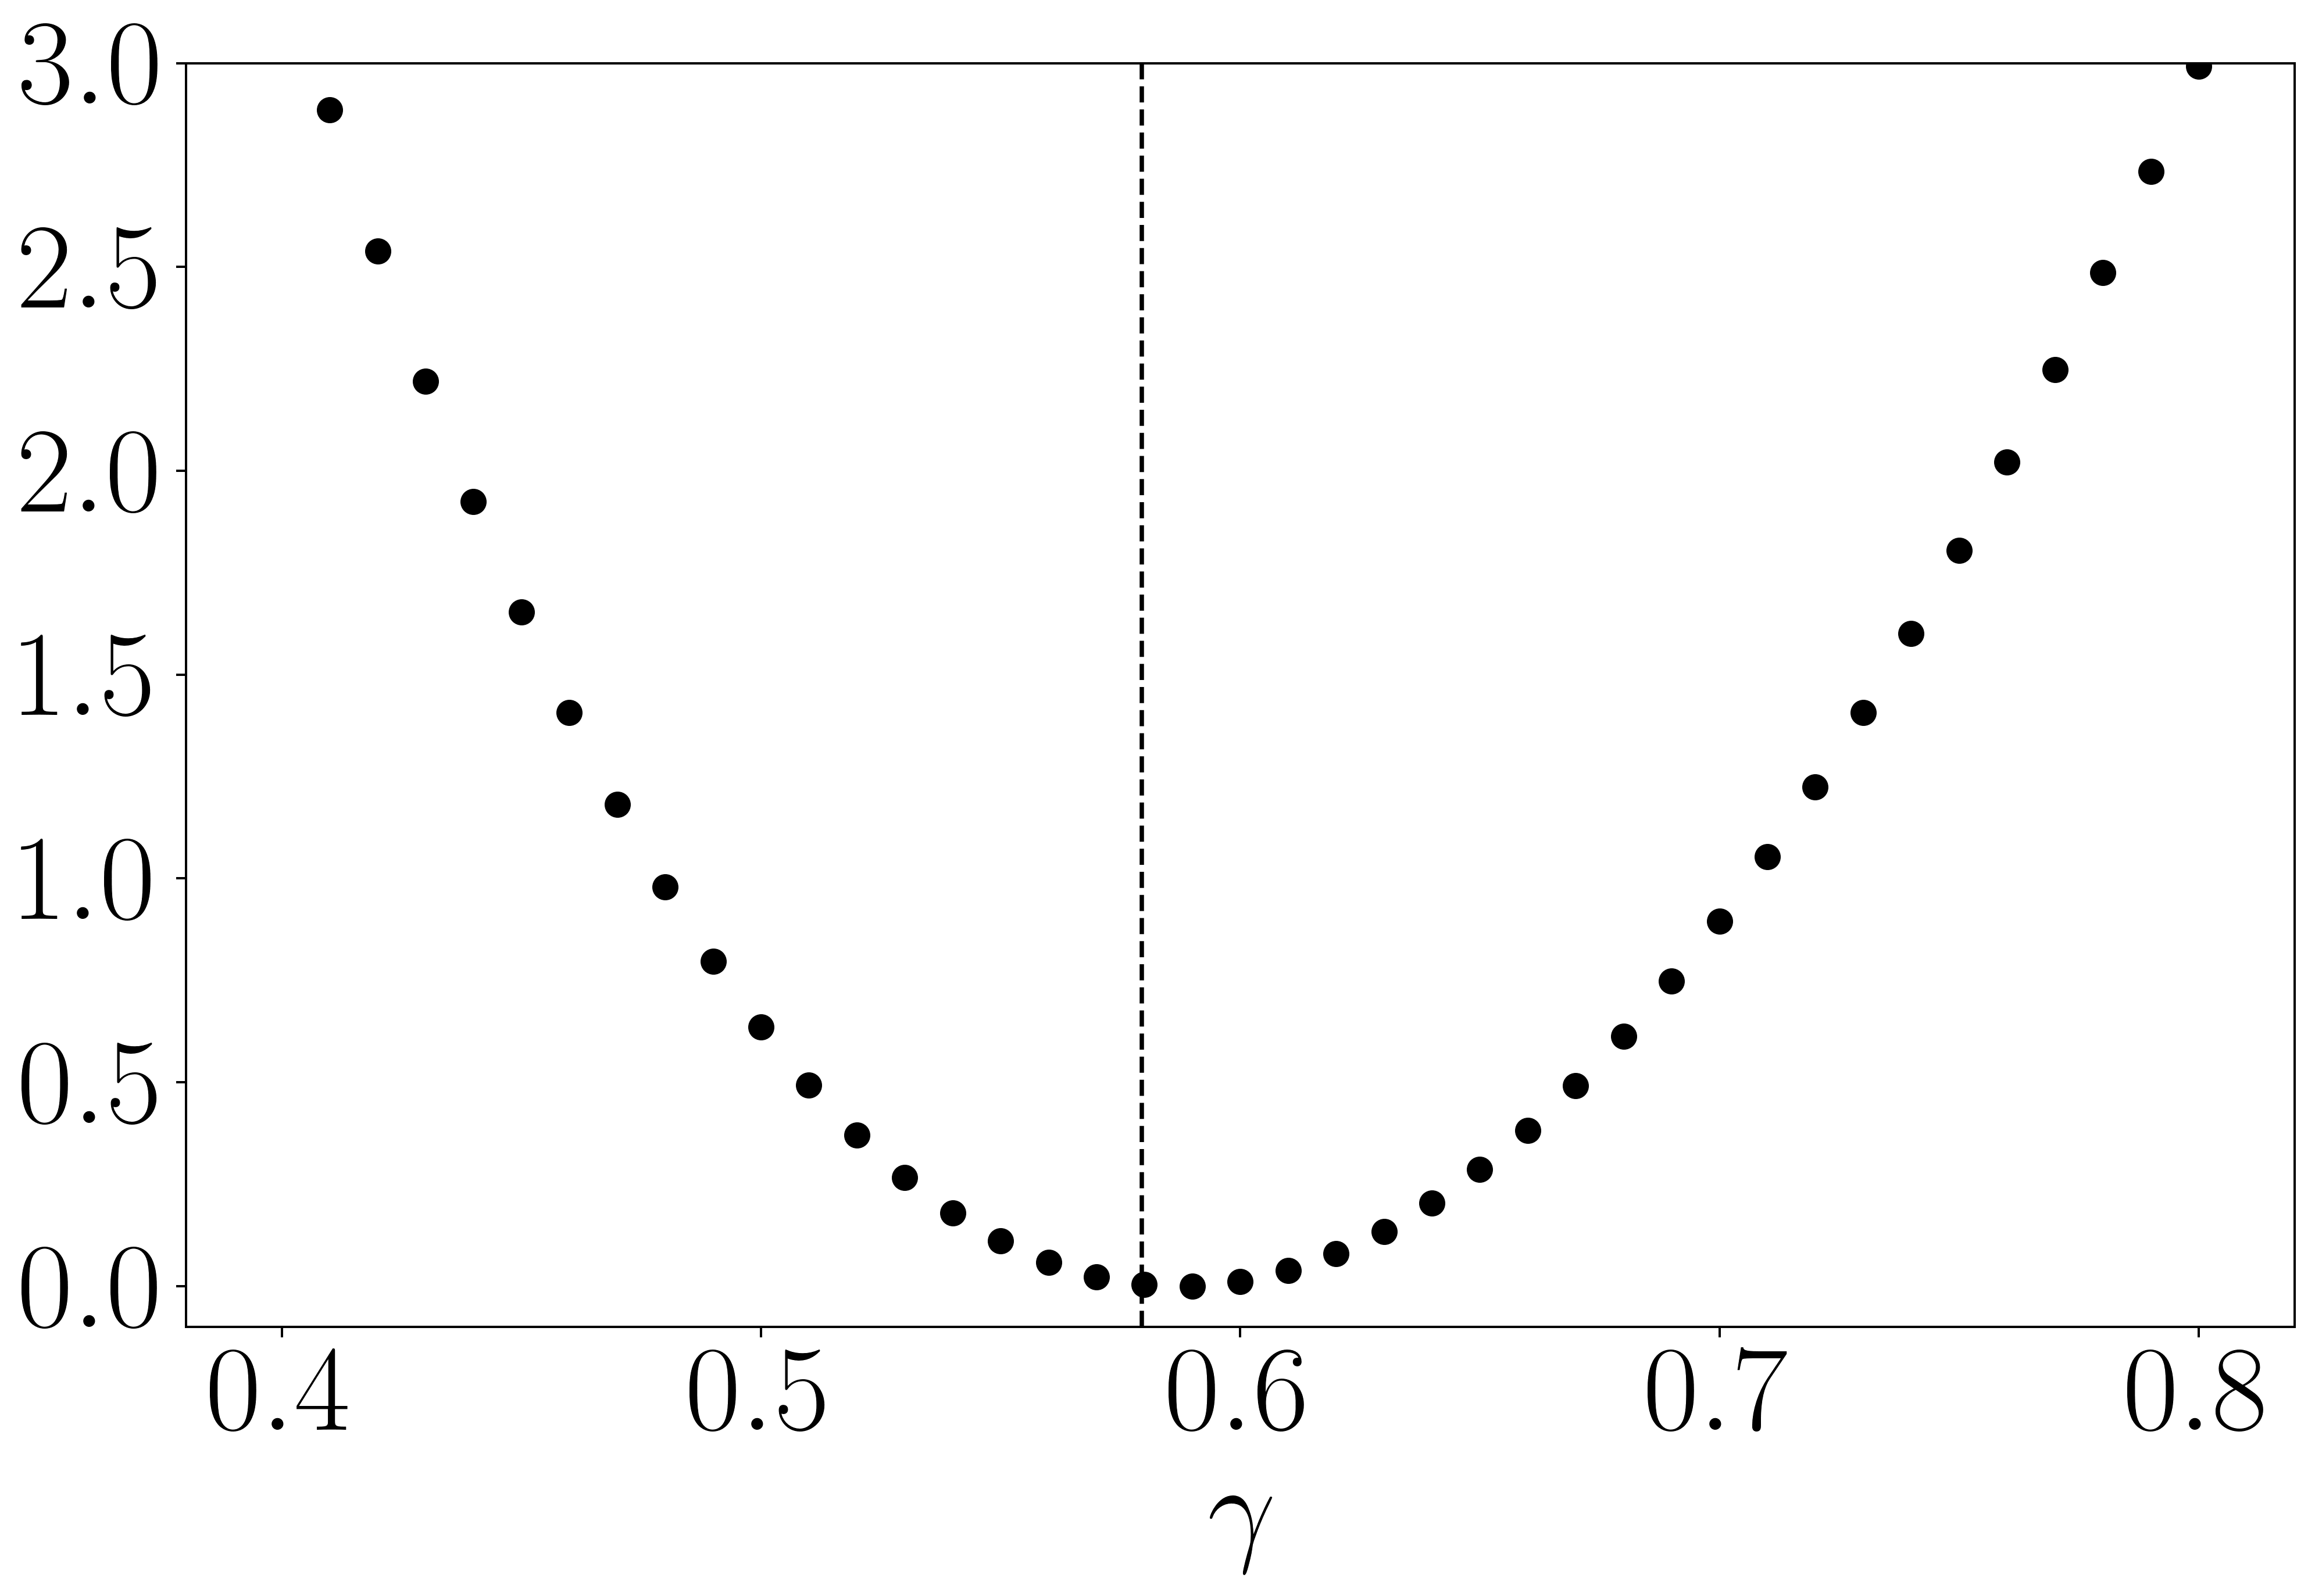

In [602]:
galsominf = min([s['f']-fr_ex(s['x']) for s in gprofile])
plt.figure(figsize=[13,8],dpi=360)
plt.plot(grange, [s['f']-galsominf -fr_ex(s['x']) for s in gprofile], 'o', color='k',markersize=8)
plt.axvline(float(getp(pref)[-5]), linestyle='--', color='k')
plt.ylim([-0.1, 3])
# plt.xlim([0.0001, 0.00025])
# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel('Relative Objective Function Value', font_properties=label_font)
plt.xlabel(' $\\gamma$', font_properties=pub_font2)
plt.xticks(font_properties=pub_font2)
plt.yticks(font_properties=pub_font2);

In [399]:
# profiling for a, g, m
mprofile = []
mrange = np.linspace(0,0.05, num=51)
for m in mrange:
    lbxp = copy(lbx)
    lbxp[-1] = m
    ubxp = [np.inf]*len(lbxp)
    ubxp[-1] = m
    psolve_opts = {
        'x0': pref,
        'p': [prange[idx], alpha],
        'lbx': lbxp,
        'ubx': ubxp,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f'm={m}')
    mprofile.append(solver(**psolve_opts))

m=0.0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7140

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls



Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   1.1129510636641859e+02    3.3495019758605446e+02
Dual infeasibility......:   1.3557833397831302e-10    4.0803222385100598e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.8981181409201202e-09    1.4741219921202780e-08
Overall NLP error.......:   4.8981181409201202e-09    1.4741219921202780e-08


Number of objective function evaluations             = 102
Number of objective gradient evaluations             = 40
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 102
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 41
Number of Lagrangian Hessian evaluations             = 39
Total CPU secs in IPOPT (w/o function evaluations)   =      0.283
Total CPU secs in NLP function evaluati

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7140

Total number of variables............................:      365
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3493581e+02 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.

  50  3.3428086e+02 0.00e+00 4.40e-03  -5.7 3.83e+00  -9.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:   3.3427769879974716e+02    3.3427769879974716e+02
Dual infeasibility......:   6.8417054941398710e-10    6.8417054941398710e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.1300821957835552e-09    1.1300821957835552e-09
Overall NLP error.......:   1.1300821957835552e-09    1.1300821957835552e-09


Number of objective function evaluations             = 106
Number of objective gradient evaluations             = 62
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 106
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 62
Number of Lagrangian Hessian evaluations             = 61
Total CPU secs in IPOPT 

Total CPU secs in NLP function evaluations           =      0.094

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   7.71ms ( 77.83us)   7.77ms ( 78.50us)        99
       nlp_g  |   3.60ms ( 36.32us)   3.61ms ( 36.46us)        99
    nlp_grad  | 195.00us (195.00us) 194.70us (194.70us)         1
  nlp_grad_f  |   9.45ms (168.80us)   9.41ms (168.11us)        56
  nlp_hess_l  |  68.51ms (  1.27ms)  68.82ms (  1.27ms)        54
   nlp_jac_g  |   2.95ms ( 52.66us)   2.96ms ( 52.87us)        56
       total  | 489.45ms (489.45ms) 490.40ms (490.40ms)         1
m=0.017
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7140

Total number of variables......


Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:   2.6649456713645344e+02    3.3433362176162240e+02
Dual infeasibility......:   1.5899059656807170e-09    1.9946336072745126e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4424477867137959e-09    1.8096383649244460e-09
Overall NLP error.......:   1.5899059656807170e-09    1.9946336072745126e-09


Number of objective function evaluations             = 121
Number of objective gradient evaluations             = 67
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 121
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 67
Number of Lagrangian Hessian evaluations             = 66
Total CPU secs in IPOPT (w/o function evaluations)   =      0.480
Total CPU secs in NLP function evaluati

   0  3.3559261e+02 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   1.4418799538977291e+02    3.3460164448576933e+02
Dual infeasibility......:   6.1178156240911652e-09    1.4196959760402015e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.1866134611303475e-09    5.0742397657387010e-09
Overall NLP error.......:   6.1178156240911652e-09    1.4196959760402015e-08


Number of objective function evaluations             = 68
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 68
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 47
Number of Lagrangian Hessian evaluations             = 46
Total CPU secs in IPOPT (w


Number of objective function evaluations             = 74
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 74
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 47
Number of Lagrangian Hessian evaluations             = 46
Total CPU secs in IPOPT (w/o function evaluations)   =      0.323
Total CPU secs in NLP function evaluations           =      0.078

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.96ms ( 80.50us)   5.92ms ( 80.05us)        74
       nlp_g  |   2.77ms ( 37.47us)   2.77ms ( 37.41us)        74
    nlp_grad  | 197.00us (197.00us) 196.63us (196.63us)         1
  nlp_grad_f  |   7.92ms (165.02us)   7.92ms (165.07us)        48
  nlp_hess_l  |  58.48ms (  1.27ms)  58.47ms (  1.27ms)        46
   nlp_jac_g  |   2.45ms ( 51.10us) 

  50  3.3553942e+02 0.00e+00 5.31e-08  -5.7 2.15e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   7.5356780937240018e+01    3.3553792407883276e+02
Dual infeasibility......:   2.9211692773395111e-10    1.3006965836527445e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.8291666340304644e-10    4.3765911000819658e-09
Overall NLP error.......:   9.8291666340304644e-10    4.3765911000819658e-09


Number of objective function evaluations             = 87
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 87
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 58
Number of Lagrangian Hessian evaluations             = 57
Total CPU secs in IPOPT (w


Number of Iterations....: 144

                                   (scaled)                 (unscaled)
Objective...............:   6.3974714094679676e+01    3.3600680951100952e+02
Dual infeasibility......:   3.7018995871038341e-10    1.9443048507446572e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.7276127653412665e-10    5.1091187755893528e-09
Overall NLP error.......:   9.7276127653412665e-10    5.1091187755893528e-09


Number of objective function evaluations             = 243
Number of objective gradient evaluations             = 145
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 243
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 145
Number of Lagrangian Hessian evaluations             = 144
Total CPU secs in IPOPT (w/o function evaluations)   =      1.322
Total CPU secs in NLP function eval

 100  3.5662901e+02 0.00e+00 1.32e+01  -3.8 3.96e+01  -6.2 1.00e+00 2.50e-01f  3
 150  3.4545122e+02 0.00e+00 6.94e-02  -5.7 7.36e-01  -4.5 1.00e+00 1.00e+00f  1
 200  3.3653243e+02 0.00e+00 3.93e-01  -5.7 8.33e+03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 212

                                   (scaled)                 (unscaled)
Objective...............:   5.5609247879345823e+01    3.3653079933898636e+02
Dual infeasibility......:   4.5434799607913884e-10    2.7495803329390029e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.6575146908990697e-10    5.8444436177375267e-09
Overall NLP error.......:   9.6575146908990697e-10    5.8444436177375267e-09


Number of objective function evaluations             = 360
Number of objective gradient evaluations             = 213
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 360
Number of equality constraint Jac

        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4620115e+02 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  6.1989156e+02 0.00e+00 1.19e+03  -1.0 5.27e+02  -7.1 1.00e+00 5.00e-01f  2
 100  4.0494161e+02 0.00e+00 1.15e+02  -2.5 3.25e+02  -7.6 1.00e+00 2.50e-01f  3
 150  3.7568964e+02 0.00e+00 7.52e+01  -2.5 8.96e+02  -8.0 1.00e+00 1.25e-01f  4
 200  3.5484867e+02 0.00e+00 6.32e+00  -3.8 2.67e+02  -8.3 1.00e+00 1.00e+00f  1
 250  3.4379419e+02 0.00e+00 2.68e-02  -3.8 5.01e+01  -7.8 1.00e+00 1.00e+00f  1
 300  3.3710470e+02 0.00e+00 2.30e-09  -8.6 6.93e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 302

                                   (scaled)                 (unscaled)
Objective...............:   4.9203530764025025e+01    3.3710469605252786e+02
Dual infeasibility......:   5.6131129028639242e-10    3.8456726369969069e-09
Constraint violation....:   0.

  50  3.4371196e+02 0.00e+00 5.09e-01  -3.8 6.39e+01  -7.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 96

                                   (scaled)                 (unscaled)
Objective...............:   4.4142549647704996e+01    3.3772378594582187e+02
Dual infeasibility......:   6.9987497725466431e-10    5.3545712446059391e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.5468013315263059e-10    7.3040227967967078e-09
Overall NLP error.......:   9.5468013315263059e-10    7.3040227967967078e-09


Number of objective function evaluations             = 169
Number of objective gradient evaluations             = 97
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 169
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 97
Number of Lagrangian Hessian evaluations             = 96
Total CPU secs in IPOPT 

 150  3.5014822e+02 0.00e+00 4.21e+00  -3.8 5.88e+00  -6.5 1.00e+00 1.00e+00f  1
 200  3.3869366e+02 0.00e+00 8.80e-01  -3.8 3.89e+00  -6.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 232

                                   (scaled)                 (unscaled)
Objective...............:   4.0044104182633021e+01    3.3838381651380604e+02
Dual infeasibility......:   9.4566462493875187e-10    7.9911290678255098e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.4613570530891742e-10    7.9951098279597437e-09
Overall NLP error.......:   9.4613570530891742e-10    7.9951098279597437e-09


Number of objective function evaluations             = 427
Number of objective gradient evaluations             = 233
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 427
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 23

 800  3.5262332e+02 0.00e+00 4.44e+00  -5.7 1.00e+03  -9.7 1.00e+00 1.00e+00f  1
 850  3.4262584e+02 0.00e+00 1.49e-01  -5.7 2.80e+00  -6.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 896

                                   (scaled)                 (unscaled)
Objective...............:   3.7719423446779281e+01    3.3884467780452189e+02
Dual infeasibility......:   5.3493979046997705e-11    4.8055215160531585e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5100921350180338e-09    2.2548896113163515e-08
Overall NLP error.......:   2.5100921350180338e-09    2.2548896113163515e-08


Number of objective function evaluations             = 1229
Number of objective gradient evaluations             = 897
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1229
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

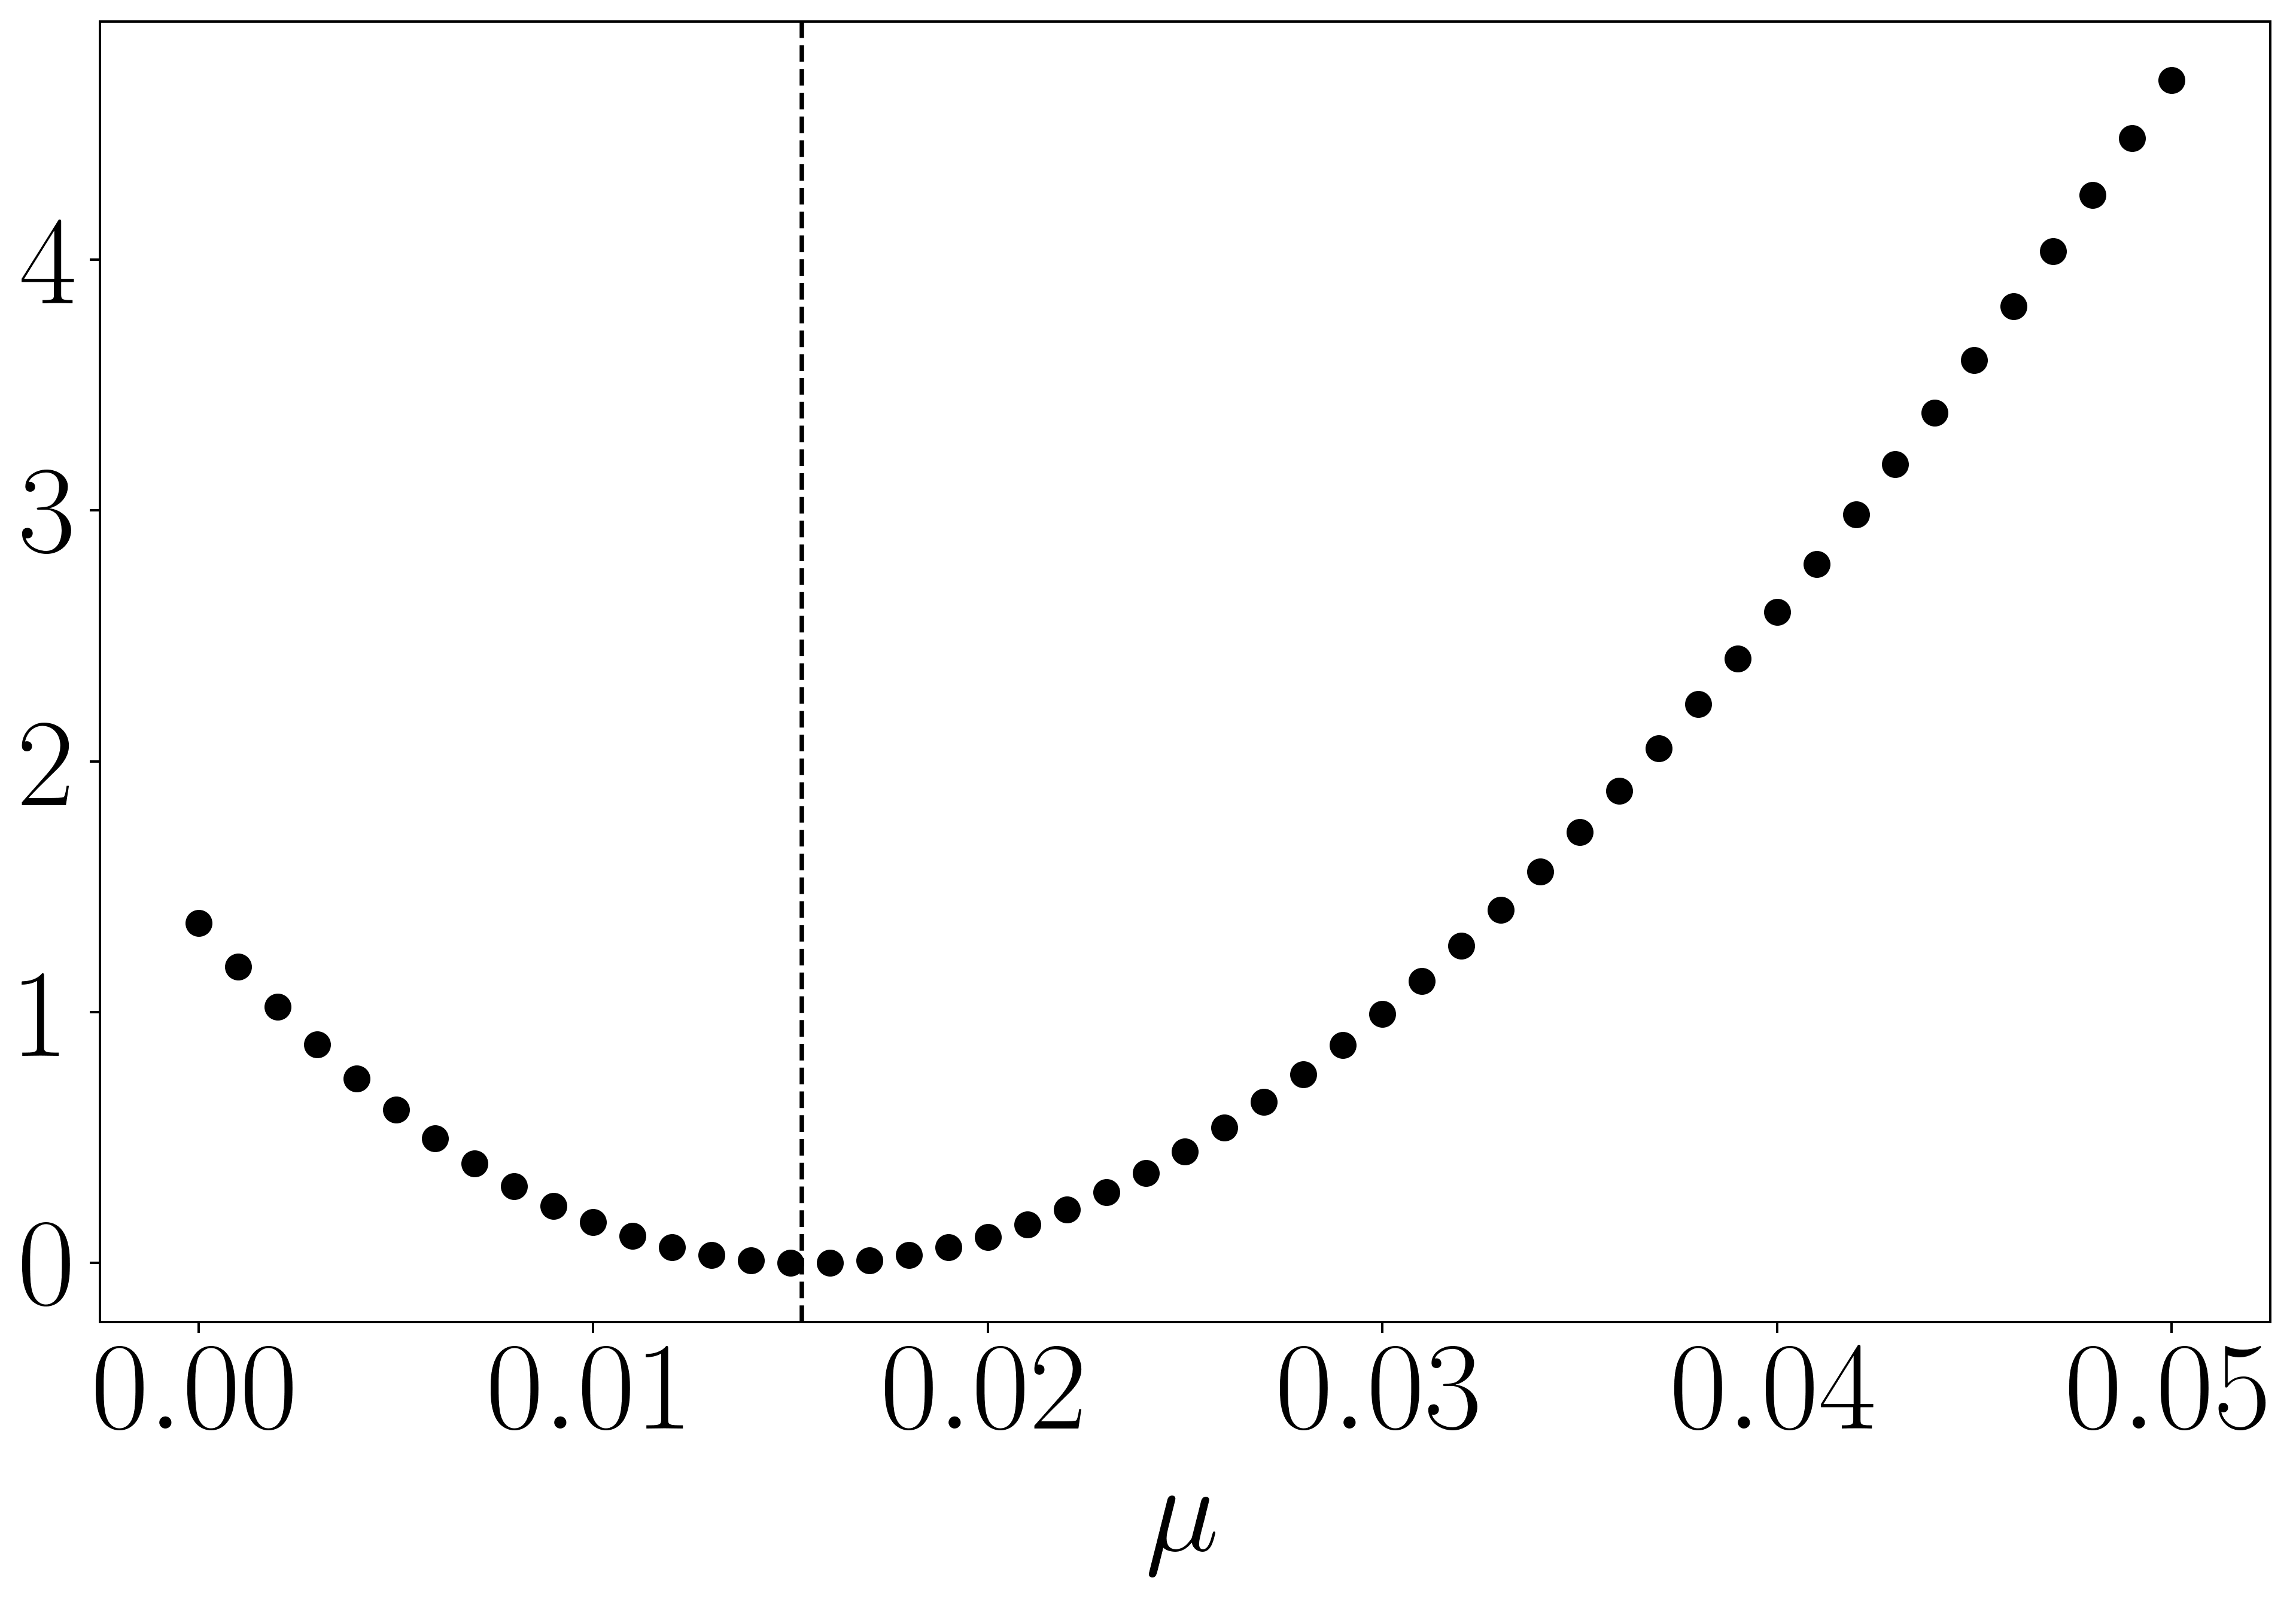

In [603]:
malsominf = min([s['f']-fr_ex(s['x']) for s in mprofile])
plt.figure(figsize=[13,8],dpi=360)
plt.plot(mrange, [s['f']-malsominf -fr_ex(s['x']) for s in mprofile], 'o', color='k',markersize=8)
plt.axvline(float(getp(pref)[-1]), linestyle='--', color='k')
# plt.ylim([-0.1, 2])
# plt.xlim([0.0001, 0.00025])
# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel('Relative Objective Function Value', font_properties=label_font)
plt.xlabel('$\\mu$', font_properties=pub_font2)
plt.xticks(font_properties=pub_font2)
plt.yticks(font_properties=pub_font2);

In [478]:
mpfn = lambda x: np.interp(x, mrange, [s['f']-malsominf -fr_ex(s['x']) for s in mprofile])
optimize.fsolve(lambda x: mpfn(x)-1.96, 0.04)

/home/dwu402/.virtualenvs/scider/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([0.03645578])

In [522]:
print(getx(sols[idx]['x'])[-2][-1])
print(getx(sols[idx]['x'])[-3][-1])

5230.31
81.0681


In [523]:
# bootstrapping
data_pd

array([[0.000e+00, 4.000e+00, 0.000e+00, 2.800e+01, 4.000e+00],
       [0.000e+00, 7.000e+00, 0.000e+00, 3.600e+01, 7.000e+00],
       [0.000e+00, 7.000e+00, 1.000e+00,       nan, 8.000e+00],
       [1.100e+01, 3.700e+01, 1.000e+00, 1.690e+02, 4.900e+01],
       [      nan,       nan, 1.000e+00, 2.130e+02, 5.600e+01],
       [      nan,       nan, 3.000e+00, 3.140e+02, 9.100e+01],
       [      nan,       nan, 3.000e+00, 5.130e+02, 1.950e+02],
       [      nan,       nan, 6.000e+00, 7.160e+02, 2.900e+02],
       [1.890e+02,       nan, 1.600e+01, 1.174e+03,       nan],
       [1.470e+02,       nan, 2.000e+01, 1.644e+03,       nan],
       [1.470e+02,       nan, 2.200e+01, 1.797e+03,       nan],
       [1.830e+02, 4.710e+02, 2.500e+01, 2.194e+03, 6.790e+02],
       [1.760e+02, 5.580e+02, 3.200e+01, 2.437e+03, 7.660e+02],
       [1.930e+02, 5.720e+02, 3.300e+01, 2.686e+03, 7.980e+02],
       [1.900e+02, 6.200e+02, 3.900e+01, 2.936e+03, 8.490e+02],
       [1.970e+02, 6.760e+02, 4.200e+01,

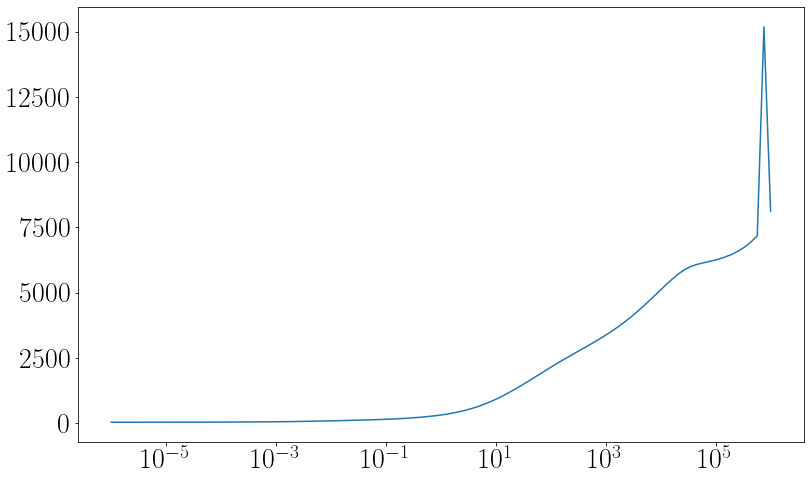

In [608]:
plt.figure(figsize=[13,8])
plt.semilogx(prange, [s['f'] - fr_ex(s['x']) for s in sols])